<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/BNP/BNP_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "BNPFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 15:16:18,025 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 15:16:18,030 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for BNPFREUR
2019-08-27 15:19:29,654 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 15:25:59,538 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 15:29:29,169 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 15:32:54,079 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 15:36:26,251 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 15:40:16,843 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 15:43:55,119 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 15:48:23,454 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 16:00:38,494 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_BNPFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-BNPFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-BNPFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.62597  0.62668  0.62357  0.62358   9.504314
2018-01-02 09:00:00  0.62358  0.62408  0.61647  0.61807  10.688272
2018-01-02 10:00:00  0.61797  0.62058  0.61767  0.61857   6.608482
2018-01-02 11:00:00  0.61858  0.61978  0.61777  0.61877   5.763540
2018-01-02 12:00:00  0.61878  0.62198  0.61857  0.62178   4.258364
...                      ...      ...      ...      ...        ...
2018-12-31 08:00:00  0.39523  0.39667  0.39197  0.39293   7.806012
2018-12-31 09:00:00  0.39283  0.39452  0.39227  0.39452   6.204853
2018-12-31 10:00:00  0.39447  0.39452  0.39327  0.39418   5.660265
2018-12-31 11:00:00  0.39417  0.39428  0.39342  0.39388   4.635186
2018-12-31 12:00:00  0.39392  0.39508  0.39367  0.39483   5.916644

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.554230     0.555833     0.552598     0.554194     7.387558
std       0.075215     0.075347     0.075123     0.075280     4.065609
min       0.382130     0.385230     0.381670     0.382070     0.005880
25%       0.510403     0.511898     0.509095     0.510380     4.518043
50%       0.540570     0.541875     0.538920     0.540380     6.310925
75%       0.624480     0.626180     0.623170     0.624623     9.147432
max       0.685780     0.686480     0.684180     0.685980    38.147446

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-09 13:00:00  0.64847  0.64948  0.64827  0.64918   3.954300    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.648770  0.643307  0.644989  0.649659  0.648079  0.647377    0.647770    0.647730  0.644495  0.648200  0.649511  0.648600  0.648766  0.648200  0.648873  0.644772                0.651294                 0.648200                0.645106                0.652842                 0.648200                0.643558                0.654389                 0.648200                0.642011                0.655936                 0.648200                0.640464  0.648079  0.648966  0.645275                0.651173                 0.648079                0.644984                0.652720                 0.648079                0.643437                0.654268                 0.648079                0.641890                0.655815                 0.648079   
2018-01-09 14:00:00  0.64918  0.65077  0.64827  0.64967   9.843930    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.648815  0.643445  0.645624  0.649936  0.648432  0.647634    0.647770    0.648020  0.644958  0.648649  0.649763  0.648969  0.649093  0.648649  0.649425  0.645251                0.651406                 0.648649                0.645891                0.652785                 0.648649                0.644513                0.654164                 0.648649                0.643134                0.655542                 0.648649                0.641755  0.648432  0.649454  0.645755                0.651190                 0.648432                0.645675                0.652568                 0.648432                0.644296                0.653947                 0.648432                0.642918                0.655326                 0.648432   
2018-01-09 15:00:00  0.64958  0.65268  0.64877  0.65

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.552409     0.554009     0.550771     0.552365     7.403244    15.998654     2.017953   185.310144      30.423698    11.373429      0.034111        0.023339        0.002244          0.004039     6.593357     2.532316    26.925045     2.017953      2.003142    26.925045     0.552892     0.553868    -0.006240     0.552366     0.552764     0.552889     0.552780     0.552748     0.553301     0.552765     0.552365     0.552765     0.552632     0.552765     0.552445     0.553558                0.557686                 0.552765                0.547844                0.560146                 0.552765                0.545384                0.562606                 0.552765                0.542924                0.565067                 0.552765                0.540463     0.552764     0.552449     0.553439                0.557685                 0.552764                0.547843                0.560145                 0.552764                0.545383                0.562605   
std       0.075039     0.075171     0.074938     0.075097     4.098647     8.573751     1.411875   101.814231       0.853958     2.621567      0.181556        0.151013        0.047330          0.063443     3.350474     1.102447    14.545447     1.411875      1.404492    14.545447     0.074875     0.074310     0.557886     0.075124     0.074846     0.074789     0.074899     0.074791     0.074536     0.074874     0.075104     0.074886     0.074939     0.074874     0.075041     0.074410                0.075071                 0.074874                0.074807                0.075218                 0.074874                0.074823                0.075397                 0.074874                0.074871                0.075608                 0.074874                0.074951     0.074846     0.075034     0.074483                0.075038                 0.074846                0.074784                0.075182                 0.074846                0.074803                0.075359   
min       0.382130     0.385230     0.3816

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.877128  0.877178  0.881293  0.878911  0.103520    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.879848  0.868306  0.971728  0.879983  0.878081  0.877884    0.874721    0.875470  0.862259  0.876416  0.880244  0.878002  0.878843  0.876416  0.879419  0.871038                0.873491                 0.876416                0.872796                0.869124                 0.876416                0.871343                0.862474                 0.876416                0.869975                0.855886                 0.876416                0.868703  0.878081  0.879817  0.871890                0.876099                 0.878081                0.873937                0.872130                 0.878081                0.871919                0.865387                 0.878081                0.870479                0.858699                 0.878081   
2018-01-09 14:00:00  0.879467  0.881461  0.881293  0.880524  0.257935    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.880000  0.868780  0.972191  0.880905  0.879270  0.878759    0.874721    0.876444  0.863777  0.877926  0.881077  0.879238  0.879937  0.877926  0.881248  0.872673                0.873868                 0.877926                0.875387                0.868933                 0.877926                0.874452                0.861723                 0.877926                0.873589                0.854585                 0.877926                0.872806  0.879270  0.881436  0.873521                0.876156                 0.879270                0.876222                0.871617                 0.879270                0.874739                0.864314                 0.879270                0.873811                0.857075                 0.879270   
2018-01-09 15:00:00  0.880784  0.887801  

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 20 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_1t03yt
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190827_160958  0.540543  2.716378              0.436938  0.753498  0.567759
1  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.522353  5.659429              0.441683  0.707978  0.501233
2  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.509907  0.717265              0.478230  0.511340  0.261469
3  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.505994  0.696723              0.496212  0.501471  0.251473
4  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.500000  0.686230              0.500000  0.496531  0.246543
5  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.500000  0.692857              0.500000  0.499855  0.249855
6  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.500000  0.689974              0.500000  0.498411  0.248414
7  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.500000  0.684313              0.500000  0.495568  0.245587
8  DeepLearning_grid_1_AutoML_20190827_160958_mod...  0.484515  0.772864              0.473485  0.524143  0.274726

variable  relative_importance  scaled_importance  percentage
0                          day             1.000000           1.000000    0.001707
1            CDLSTALLEDPATTERN             0.951983           0.951983    0.001625
2               CDLSPINNINGTOP             0.947370           0.947370    0.001617
3                       MFI_12             0.935041           0.935041    0.001596
4           CDLCLOSINGMARUBOZU             0.929174           0.929174    0.001586
...                        ...                  ...                ...         ...
1032                  MAVP_8_6             0.270896           0.270896    0.000462
1033   BBANDS_middleband_8_1_2             0.261492           0.261492    0.000446
1034  BBANDS_middleband_20_7_4             0.256251           0.256251    0.000437
1035                 CORREL_12             0.252519           0.252519    0.000431
1036   BBANDS_upperband_20_1_3             0.246025           0.246025    0.000420

[1037 rows x 4 columns]

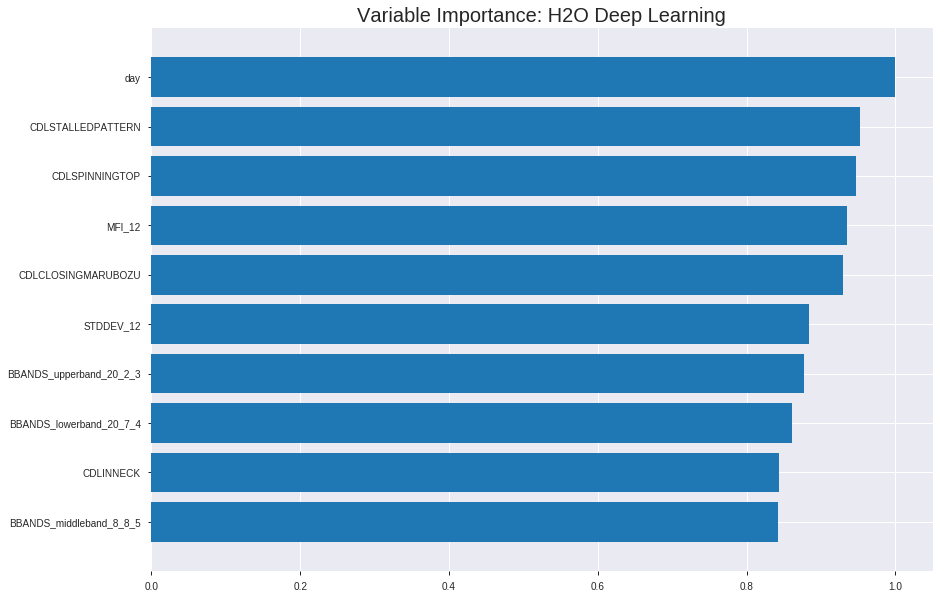

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_160958


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.259887923152179
RMSE: 0.509792039122012
LogLoss: 0.7280267815588984
Mean Per-Class Error: 0.44808058336423184
AUC: 0.5736118320767931
pr_auc: 0.5822372101746602
Gini: 0.14722366415358623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36094352084515846: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      45   730   0.9419   (730.0/775.0)
1      13   770   0.0166   (13.0/783.0)
Total  58   1500  0.4769   (743.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360944     0.674551  358
max f2                       0.239914     0.836896  389
max f0point5                 0.497992     0.576451  281
max accuracy                 0.518526     0.551348  267
max precision                0.996989     1         0
max recall                   0.239914     1         389
max specificity              0.996989     1         0
max absolute_mcc             0.497992     0.128103  281
max min_per_class_accuracy   0.498853     0.45977   280
max mean_per_class_accuracy  0.518526     0.551919  267

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 57.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.969441           1.86542   1.86542            0.9375           0.982228  0.9375                      0.982228            0.0191571       0.0191571                  86.5421   86.5421
    2        0.0205392                   0.947609           1.36798   1.6167             0.6875           0.955923  0.8125                      0.969075            0.0140485       0.0332056                  36.7976   61.6699
    3        0.0301669                   0.93327            1.45917   1.56642            0.733333         0.939513  0.787234                    0.95964             0.0140485       0.0472542                  45.9174   56.6425
    4        0.0404365                   0.924267           1.49234   1.54761            0.75             0.928643  0.777778                    0.951768            0.0153257       0.0625798                  49.2337   54.7609
    5        0.0500642                   0.909232           0.928565  1.42856            0.466667         0.917773  0.717949                    0.945231            0.00893997      0.0715198                  -7.14347  42.8562
    6        0.100128                    0.86042            1.19897   1.31377            0.602564         0.884696  0.660256                    0.914964            0.0600255       0.131545                   19.8972   31.3767
    7        0.150193                    0.792414           1.09693   1.24149            0.551282         0.826691  0.623932                    0.88554             0.054917        0.186462                   9.69316   24.1488
    8        0.200257                    0.726316           0.841831  1.14157            0.423077         0.758349  0.573718                    0.853742            0.0421456       0.228608                   -15.8169  14.1574
    9        0.300385                    0.593263           1.10969   1.13094            0.557692         0.662286  0.568376                    0.789923            0.111111        0.339719                   10.9687   13.0945
    10       0.399872                    0.509771           1.11685   1.12744            0.56129          0.549351  0.566613                    0.73007             0.111111        0.45083                    11.6846   12.7437
    11       0.854942                    0.497993           0.987875  1.05315            0.496474         0.498219  0.529279                    0.60666             0.449553        0.900383                   -1.21247  5.31509
    12       0.899872                    0.43599            0.739062  1.03747            0.371429         0.468475  0.521398                    0.59976             0.0332056       0.933589                   -26.0938  3.74688
    13       1                           0.0339314          0.663261  1                  0.333333         0.352998  0.502567                    0.575052            0.0664112       1                          -33.6739  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.39331631881671236
RMSE: 0.6271493592571967
LogLoss: 1.2652569913864244
Mean Per-Class Error: 0.4540565581695134
AUC: 0.5291048984853368
pr_auc: 0.5217840488157401
Gini: 0.05820979697067363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23381312168864682: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    214  0        (0.0/214.0)
Total  0    446  0.5202   (232.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233813     0.648485  399
max f2                       0.233813     0.821813  399
max f0point5                 0.353422     0.538462  387
max accuracy                 0.97297      0.558296  59
max precision                0.991875     0.8       3
max recall                   0.233813     1         399
max specificity              0.994832     0.99569   0
max absolute_mcc             0.97297      0.122769  59
max min_per_class_accuracy   0.901651     0.504673  184
max mean_per_class_accuracy  0.937491     0.545943  132

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 81.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.991641           1.66729   1.66729            0.8              0.993136  0.8                         0.993136            0.0186916       0.0186916                  66.729     66.729
    2        0.0201794                   0.989907           1.04206   1.38941            0.5              0.990672  0.666667                    0.992041            0.00934579      0.0280374                  4.20561    38.9408
    3        0.0313901                   0.988163           0.833645  1.19092            0.4              0.988932  0.571429                    0.990931            0.00934579      0.0373832                  -16.6355   19.0921
    4        0.0403587                   0.987472           1.56308   1.27362            0.75             0.987776  0.611111                    0.99023             0.0140187       0.0514019                  56.3084    27.3624
    5        0.0515695                   0.98673            0.833645  1.17798            0.4              0.987098  0.565217                    0.989549            0.00934579      0.0607477                  -16.6355   17.7976
    6        0.100897                    0.980326           1.32625   1.25047            0.636364         0.983356  0.6                         0.986521            0.0654206       0.126168                   32.6253    25.0467
    7        0.150224                    0.973329           1.32625   1.27535            0.636364         0.977034  0.61194                     0.983406            0.0654206       0.191589                   32.6253    27.5352
    8        0.201794                    0.965009           0.906136  1.181              0.434783         0.96936   0.566667                    0.979816            0.046729        0.238318                   -9.38643   18.0997
    9        0.300448                    0.948565           1.04206   1.13537            0.5              0.95748   0.544776                    0.972482            0.102804        0.341121                   4.20561    13.5375
    10       0.401345                    0.928615           0.926272  1.08281            0.444444         0.938849  0.519553                    0.964027            0.0934579       0.434579                   -7.37279   8.28069
    11       0.5                         0.891646           0.710493  1.00935            0.340909         0.913033  0.484305                    0.953965            0.0700935       0.504673                   -28.9507   0.934579
    12       0.600897                    0.83382            0.972586  1.00317            0.466667         0.864897  0.481343                    0.93901             0.0981308       0.602804                   -2.74143   0.317339
    13       0.699552                    0.776061           0.99469   1.00198            0.477273         0.80351   0.480769                    0.919901            0.0981308       0.700935                   -0.531011  0.197699
    14       0.800448                    0.6803             1.06521   1.00995            0.511111         0.727442  0.484594                    0.895641            0.107477        0.808411                   6.52129    0.99479
    15       0.899103                    0.516299           0.99469   1.00827            0.477273         0.598566  0.483791                    0.863045            0.0981308       0.906542                   -0.531011  0.827371
    16       1                           0.233813           0.926272  1                  0.444444         0.398868  0.479821                 


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:09:59  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:09:59  0.663 sec   7829 obs/sec      1         1             1558       0.586288         0.999813            -0.374972      0.510447        0.52327            1.11925          0.491656                         0.676952           1.96087               -0.836045        0.507412          0.500146             0.833645           0.511211
    2019-08-27 16:10:00  2.063 sec   10562 obs/sec     10        10            15580      0.509792         0.728027            -0.0395791     0.573612        0.582237           1.86542          0.476893                         0.627149           1.26526               -0.575832        0.529105          0.521784             1.66729            0.520179

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
day                       1.0                    1.0                  0.0017072192465632419
CDLSTALLEDPATTERN         0.951982855796814      0.951982855796814    0.00162524345381456
CDLSPINNINGTOP            0.9473696351051331     0.9473696351051331   0.0016173676746610785
MFI_12                    0.935041069984436      0.935041069984436    0.0015963201110045164
CDLCLOSINGMARUBOZU        0.9291735887527466     0.9291735887527466   0.0015863030341169274
---                       ---                    ---                  ---
MAVP_8_6                  0.2708962857723236     0.2708962857723236   0.00046247935289300693
BBANDS_middleband_8_1_2   0.26149246096611023    0.26149246096611023  0.00044642496219253063
BBANDS_middleband_20_7_4  0.2562507688999176     0.2562507688999176   0.0004374762446125687
CORREL_12                 0.2525186240673065     0.2525186240673065   0.00043110465512337354
BBANDS_upperband_20_1_3   0.24602490663528442    0.24602490663528442  0.00042001845574168216


See the whole table with table.as_data_frame()


('accuracy', 0.6053811659192825)

('F1', 0.6068965517241379)

('auc', 0.5405427905427905)

('logloss', 2.716377584766218)

('mean_per_class_error', 0.42977855477855476)

('rmse', 0.7534977339222387)

('mse', 0.5677588350259489)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


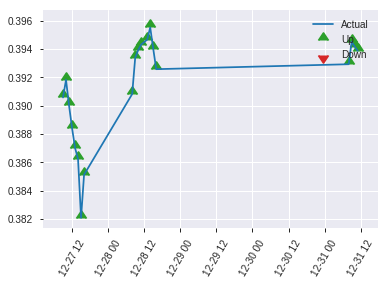


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5677588350259489
RMSE: 0.7534977339222387
LogLoss: 2.716377584766218
Mean Per-Class Error: 0.42977855477855476
AUC: 0.5405427905427905
pr_auc: 0.43585229909158635
Gini: 0.08108558108558106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9557801824584722: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   111  0.8409   (111.0/132.0)
1      3    88   0.033    (3.0/91.0)
Total  24   199  0.5112   (114.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.95578      0.606897  198
max f2                       0.95578      0.781528  198
max f0point5                 0.968082     0.499383  179
max accuracy                 0.998625     0.605381  18
max precision                0.999249     1         0
max recall                   0.846894     1         222
max specificity              0.999249     1         0
max absolute_mcc             0.95578      0.20002   198
max min_per_class_accuracy   0.99009      0.507576  111
max mean_per_class_accuracy  0.98029      0.570221  152

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 98.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.999165           1.6337    1.6337             0.666667         0.999209  0.666667                    0.999209            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.999041           1.22527   1.47033            0.5              0.999073  0.6                         0.999154            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.998999           1.22527   1.40031            0.5              0.999019  0.571429                    0.999116            0.010989        0.043956                   22.5275   40.0314
    4        0.0403587                   0.998947           1.22527   1.36142            0.5              0.998977  0.555556                    0.999085            0.010989        0.0549451                  22.5275   36.1416
    5        0.0538117                   0.998901           1.6337    1.42949            0.666667         0.998921  0.583333                    0.999044            0.021978        0.0769231                  63.37     42.9487
    6        0.103139                    0.998303           0.891109  1.172              0.363636         0.998638  0.478261                    0.99885             0.043956        0.120879                   -10.8891  17.2002
    7        0.152466                    0.997912           0.668332  1.00905            0.272727         0.998168  0.411765                    0.998629            0.032967        0.153846                   -33.1668  0.904977
    8        0.201794                    0.99724            0.891109  0.98022            0.363636         0.99758   0.4                         0.998373            0.043956        0.197802                   -10.8891  -1.97802
    9        0.300448                    0.99516            0.891109  0.950959           0.363636         0.995995  0.38806                     0.997592            0.0879121       0.285714                   -10.8891  -4.90405
    10       0.399103                    0.993127           1.22527   1.01877            0.5              0.994097  0.41573                     0.996728            0.120879        0.406593                   22.5275   1.87677
    11       0.502242                    0.99009            1.06546   1.02836            0.434783         0.991908  0.419643                    0.995738            0.10989         0.516484                   6.54563   2.83556
    12       0.600897                    0.986222           1.0025    1.02411            0.409091         0.988469  0.41791                     0.994545            0.0989011       0.615385                   0.24975   2.41102
    13       0.699552                    0.977629           1.55944   1.09961            0.636364         0.982784  0.448718                    0.992886            0.153846        0.769231                   55.9441   9.96055
    14       0.798206                    0.968716           1.0025    1.0876             0.409091         0.973303  0.44382                     0.990466            0.0989011       0.868132                   0.24975   8.76034
    15       0.896861                    0.953289           1.0025    1.07824            0.409091         0.960728  0.44                        0.987195            0.0989011       0.967033                   0.24975   7.82418
    16       1                           0.846894           0.319637  1                  0.130435         0.92772   0.408072                    0.981061         

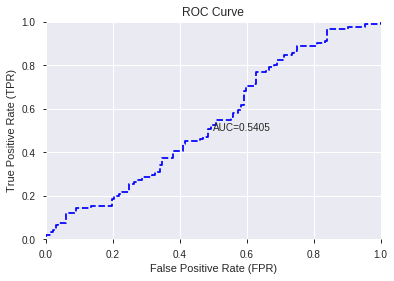

This function is available for GLM models only


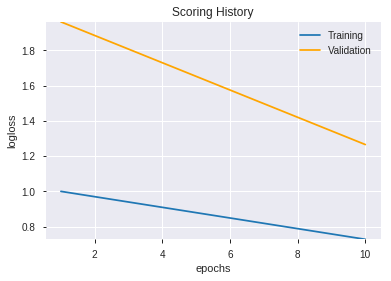

--2019-08-27 16:31:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_160958',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_160958',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_9fff',


In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_163140_model_5  0.560273  0.672663              0.496212  0.489731  0.239836
1  DeepLearning_grid_1_AutoML_20190827_163140_model_7  0.545371  0.721841              0.488262  0.513786  0.263976
2  DeepLearning_grid_1_AutoML_20190827_163140_model_6  0.533217  0.682593              0.478979  0.494707  0.244735
3  DeepLearning_grid_1_AutoML_20190827_163140_model_3  0.530969  0.810337              0.492424  0.532661  0.283728
4  DeepLearning_grid_1_AutoML_20190827_163140_model_9  0.524725  0.689441              0.492424  0.498144  0.248148
5  DeepLearning_grid_1_AutoML_20190827_163140_model_1  0.523227  0.990143              0.484099  0.558871  0.312337
6  DeepLearning_grid_1_AutoML_20190827_163140_model_2  0.522894  1.139982              0.462704  0.567547  0.322109
7  DeepLearning_grid_1_AutoML_20190827_163140_model_4  0.518731  0.855029              0.496212  0.537638  0.289055
8               DeepLearning_1_AutoML_20190827_163140  0.513403  0.816464              0.488262  0.542768  0.294597
9  DeepLearning_grid_1_AutoML_20190827_163140_model_8  0.500000  0.684951              0.500000  0.495889  0.245905

variable  relative_importance  scaled_importance  percentage
0                       hour             1.000000           1.000000    0.029932
1              days_in_month             0.918102           0.918102    0.027480
2                   CORREL_8             0.831921           0.831921    0.024901
3                     MFI_12             0.775908           0.775908    0.023224
4         CDLCLOSINGMARUBOZU             0.769762           0.769762    0.023040
5                  dayofweek             0.769385           0.769385    0.023029
6                STOCH_slowd             0.762282           0.762282    0.022816
7                     CMO_24             0.759678           0.759678    0.022738
8                        day             0.746253           0.746253    0.022337
9             CDLSPINNINGTOP             0.745377           0.745377    0.022310
10                     ATR_8             0.716176           0.716176    0.021436
11                       BOP             0.715582           0.715582    0.021419
12            MACDFIX_hist_8             0.714572           0.714572    0.021388
13                    ADX_12             0.712239           0.712239    0.021319
14           MACDFIX_hist_14             0.705374           0.705374    0.021113
15                aroonup_14             0.703782           0.703782    0.021065
16                    ATR_30             0.695548           0.695548    0.020819
17                PLUS_DM_20             0.694569           0.694569    0.020790
18                PLUS_DM_14             0.674067           0.674067    0.020176
19                 STDDEV_12             0.667122           0.667122    0.019968
20                  WILLR_30             0.655131           0.655131    0.019609
21                     ROC_8             0.643172           0.643172    0.019251
22             MINMAX_min_12             0.642896           0.642896    0.019243
23    BBANDS_upperband_8_8_4             0.642104           0.642104    0.019219
24           CDLADVANCEBLOCK             0.640093           0.640093    0.019159
25   BBANDS_lowerband_20_1_3             0.632933           0.632933    0.018945
26    BBANDS_lowerband_8_4_5             0.632860           0.632860    0.018943
27  BBANDS_middleband_14_7_3             0.632583           0.632583    0.018934
28   BBANDS_lowerband_30_7_5             0.628056           0.628056    0.018799
29            CDLMORNINGSTAR             0.621567           0.621567    0.018605
30               CDLMARUBOZU             0.619008           0.619008    0.018528
31   BBANDS_upperband_20_2_3             0.618507           0.618507    0.018513
32              LINEARREG_30             0.613983           0.613983    0.018378
33   BBANDS_middleband_8_8_5             0.610553           0.610553    0.018275
34   BBANDS_lowerband_14_1_2             0.609975           0.609975    0.018258
35  BBANDS_middleband_30_5_3             0.604973           0.604973    0.018108
36  BBANDS_middleband_24_2_2             0.602787           0.602787    0.018042
37                 MAVP_30_2             0.602181           0.602181    0.018024
38                   MA_14_4             0.601757           0.601757    0.018012
39                 MAVP_30_1             0.601268           0.601268    0.017997
40               MIDPRICE_20             0.598575           0.598575    0.017916
41   BBANDS_upperband_12_6_2             0.597820           0.597820    0.017894
42   BBANDS_lowerband_20_7_4             0.594573           0.594573    0.017797
43   BBANDS_middleband_8_8_2             0.594239           0.594239    0.017787
44    BBANDS_upperband_8_5_5             0.590997           0.590997    0.017690
45  BBANDS_middleband_14_5_2             0.589522           0.589522    0.017645
46  BBANDS_middleband_14_4_4             0.586219           0.586219    0.017547
47                 CDLINNECK             0.585986           0.585986    0.017540
48    BBANDS_upperband_8_2_4             0.579891  

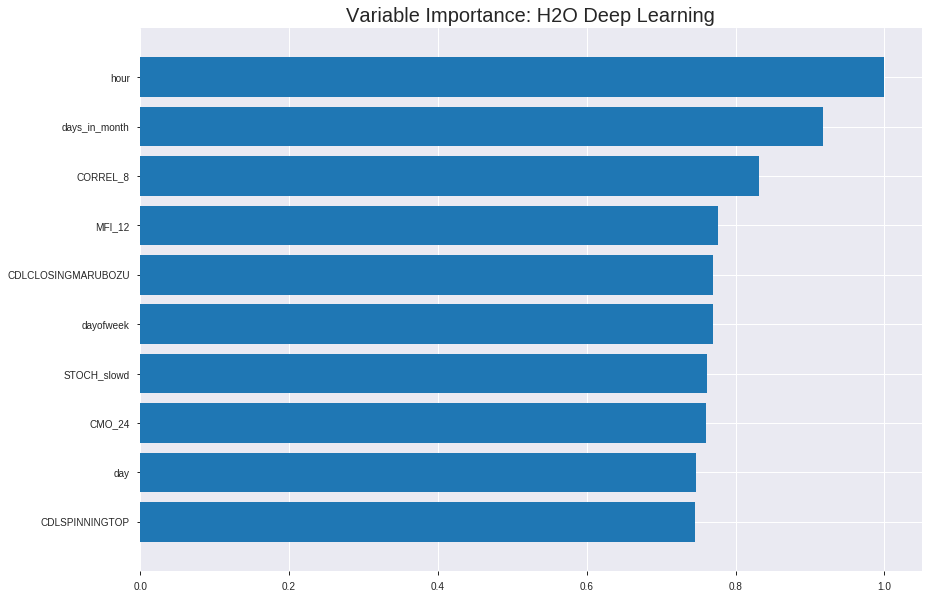

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_163140_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24713831842006967
RMSE: 0.49713008199068953
LogLoss: 0.6873317017883465
Mean Per-Class Error: 0.42739669591727436
AUC: 0.5900276026861121
pr_auc: 0.5922213613091298
Gini: 0.1800552053722242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3774504775096782: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   757   0.9768   (757.0/775.0)
1      3    780   0.0038   (3.0/783.0)
Total  21   1537  0.4878   (760.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37745      0.672414  380
max f2                       0.376288     0.83583   382
max f0point5                 0.439702     0.577967  239
max accuracy                 0.445026     0.572529  223
max precision                0.63311      1         0
max recall                   0.330487     1         393
max specificity              0.63311      1         0
max absolute_mcc             0.445026     0.145263  223
max min_per_class_accuracy   0.444401     0.568327  225
max mean_per_class_accuracy  0.445026     0.572603  223

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 45.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.581701           1.6167    1.6167             0.8125           0.6054    0.8125                      0.6054              0.0166028       0.0166028                  61.6699    61.6699
    2        0.0205392                   0.562332           1.74106   1.67888            0.875            0.571559  0.84375                     0.58848             0.0178799       0.0344828                  74.106     67.8879
    3        0.0301669                   0.55455            1.32652   1.56642            0.666667         0.559259  0.787234                    0.579154            0.0127714       0.0472542                  32.6522    56.6425
    4        0.0404365                   0.543721           1.11925   1.45286            0.5625           0.54828   0.730159                    0.571313            0.0114943       0.0587484                  11.9253    45.2857
    5        0.0500642                   0.537232           1.19387   1.40305            0.6              0.541048  0.705128                    0.565493            0.0114943       0.0702427                  19.387     40.3052
    6        0.100128                    0.511824           1.2755    1.33928            0.641026         0.523985  0.673077                    0.544739            0.063857        0.1341                     27.5502    33.9277
    7        0.150193                    0.497223           1.09693   1.2585             0.551282         0.50384   0.632479                    0.531106            0.054917        0.189017                   9.69316    25.8495
    8        0.200257                    0.480011           1.2755    1.26275            0.641026         0.489116  0.634615                    0.520608            0.063857        0.252874                   27.5502    26.2747
    9        0.300385                    0.462529           0.994891  1.17346            0.5              0.469489  0.589744                    0.503569            0.0996169       0.35249                    -0.510856  17.3462
    10       0.399872                    0.453583           1.02698   1.13702            0.516129         0.458522  0.571429                    0.492361            0.102171        0.454662                   2.69847    13.7019
    11       0.5                         0.443913           1.1352    1.13665            0.570513         0.448539  0.571245                    0.483586            0.113665        0.568327                   13.5197    13.6654
    12       0.600128                    0.436128           0.956626  1.10662            0.480769         0.440029  0.55615                     0.476318            0.0957854       0.664112                   -4.33736   10.6617
    13       0.699615                    0.430163           0.911449  1.07886            0.458065         0.433163  0.542202                    0.470182            0.0906769       0.754789                   -8.85511   7.88639
    14       0.799743                    0.423597           0.854586  1.05078            0.429487         0.427144  0.52809                     0.464793            0.0855683       0.840358                   -14.5414   5.07842
    15       0.899872                    0.411608           0.829076  1.02611            0.416667         0.418474  0.515692                    0.459639            0.083014        0.923372                   -17.0924   2.61149
    16       1                           0.281009           0.765301  1                  0.384615         0.392184  0.502567                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24853708956286605
RMSE: 0.4985349431713549
LogLoss: 0.6901896098600696
Mean Per-Class Error: 0.4192918143731872
AUC: 0.5796205285207863
pr_auc: 0.5211686105842297
Gini: 0.15924105704157254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4189533644305839: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   188  0.8103   (188.0/232.0)
1      19   195  0.0888   (19.0/214.0)
Total  63   383  0.4641   (207.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418953     0.653266  344
max f2                       0.403984     0.821813  399
max f0point5                 0.431299     0.570108  253
max accuracy                 0.436559     0.578475  221
max precision                0.646798     1         0
max recall                   0.403984     1         399
max specificity              0.646798     1         0
max absolute_mcc             0.431299     0.165156  253
max min_per_class_accuracy   0.43752      0.568966  212
max mean_per_class_accuracy  0.431299     0.580708  253

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 45.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.588427           0.833645  0.833645           0.4              0.610471  0.4                         0.610471            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.575309           1.04206   0.926272           0.5              0.582902  0.444444                    0.598218            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.568685           0.833645  0.893191           0.4              0.571909  0.428571                    0.588822            0.00934579      0.0280374                  -16.6355  -10.6809
    4        0.0403587                   0.559984           0.521028  0.810488           0.25             0.565467  0.388889                    0.583632            0.0046729       0.0327103                  -47.8972  -18.9512
    5        0.0515695                   0.551755           1.25047   0.906136           0.6              0.556957  0.434783                    0.577833            0.0140187       0.046729                   25.0467   -9.38643
    6        0.100897                    0.518895           1.04206   0.972586           0.5              0.53331   0.466667                    0.556066            0.0514019       0.0981308                  4.20561   -2.74143
    7        0.150224                    0.504706           1.51572   1.15093            0.727273         0.512822  0.552239                    0.541867            0.0747664       0.172897                   51.5718   15.0928
    8        0.201794                    0.4887             1.17798   1.15784            0.565217         0.496944  0.555556                    0.530386            0.0607477       0.233645                   17.7976   15.784
    9        0.300448                    0.463369           0.947324  1.08872            0.454545         0.474477  0.522388                    0.512028            0.0934579       0.327103                   -5.26763  8.87153
    10       0.401345                    0.446733           1.34309   1.15267            0.644444         0.453715  0.553073                    0.497368            0.135514        0.462617                   34.3094   15.2665
    11       0.5                         0.437399           1.13679   1.14953            0.545455         0.441473  0.55157                     0.48634             0.11215         0.574766                   13.6788   14.9533
    12       0.600897                    0.431869           1.0189    1.1276             0.488889         0.434959  0.541045                    0.477712            0.102804        0.67757                    1.88993   12.7598
    13       0.699552                    0.426439           0.899958  1.09549            0.431818         0.429318  0.525641                    0.470887            0.088785        0.766355                   -10.0042  9.54948
    14       0.800448                    0.422072           0.694704  1.04497            0.333333         0.424433  0.501401                    0.465032            0.0700935       0.836449                   -30.5296  4.4975
    15       0.899103                    0.416586           0.947324  1.03426            0.454545         0.419394  0.496259                    0.460024            0.0934579       0.929907                   -5.26763  3.42601
    16       1                           0.403984           0.694704  1                  0.333333         0.412257  0.479821                    0.455205     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:34:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:34:36  59.204 sec        1275 obs/sec      1.18036   1             1839       0.502873         0.699309            -0.0115499     0.553204        0.542354           1.24361          0.493582                         0.506533           0.706771              -0.0279768       0.53838           0.50657              0.833645           0.506726
    2019-08-27 16:34:41  1 min  4.555 sec  2393 obs/sec      9.67009   8             15066      0.49713          0.687332            0.0114207      0.590028        0.592221           1.6167           0.487805                         0.498535           0.69019               0.0042297        0.579621          0.521169             0.833645           0.464126
    2019-08-27 16:34:46  1 min  9.582 sec  2797 obs/sec      19.4332   16            30277      0.48937          0.671115            0.0420441      0.612898        0.626098           1.86542          0.460205                         0.503093           0.699687              -0.0140627       0.52411           0.486631             0.416822           0.520179
    2019-08-27 16:34:52  1 min 15.028 sec  2990 obs/sec      30.2953   25            47200      0.487507         0.666021            0.0493232      0.628402        0.654599           1.98978          0.452503                         0.510657           0.717733              -0.0447854       0.53842           0.495702             0.416822           0.520179
    2019-08-27 16:34:57  1 min 20.110 sec  3148 obs/sec      41.2157   34            64214      0.479988         0.650385            0.0784224      0.649032        0.667532           1.98978          0.432606                         0.50599            0.706439              -0.0257729       0.519517          0.492078             0.833645           0.520179
    2019-08-27 16:35:02  1 min 25.561 sec  3276 obs/sec      53.3748   44            83158      0.477317         0.644085            0.0886511      0.659202        0.683082           1.98978          0.425546                         0.505404           0.70848               -0.0234007       0.540586          0.511671             0.416822           0.520179
    2019-08-27 16:35:03  1 min 26.043 sec  3274 obs/sec      53.3748   44            83158      0.49713          0.687332            0.0114207      0.590028        0.592221           1.6167           0.487805                         0.498535           0.69019               0.0042297        0.579621          0.521169             0.833645           0.464126

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
hour                      1.0                    1.0                  0.029931686216897856
days_in_month             0.9181024432182312     0.9181024432182312   0.027480354245375378
CORREL_8                  0.8319211006164551     0.8319211006164551   0.024900801340868042
MFI_12                    0.7759076952934265     0.7759076952934265   0.023224225668799236
CDLCLOSINGMARUBOZU        0.7697619199752808     0.7697619199752808   0.02304027225041694
---                       ---                    ---                  ---
BBANDS_middleband_14_5_2  0.5895222425460815     0.5895222425460815   0.017645394781771264
BBANDS_middleband_14_4_4  0.5862189531326294     0.5862189531326294   0.017546521759564213
CDLINNECK                 0.5859856009483337     0.5859856009483337   0.017539537135205847
BBANDS_upperband_8_2_4    0.5798906087875366     0.5798906087875366   0.017357103742354416
CDLSTALLEDPATTERN         0.55750572681427       0.55750572681427     0.016687086479128307


See the whole table with table.as_data_frame()


('accuracy', 0.6098654708520179)

('F1', 0.5814696485623003)

('auc', 0.5602730602730602)

('logloss', 0.6726633605483167)

('mean_per_class_error', 0.4341908091908092)

('rmse', 0.4897309998766287)

('mse', 0.2398364522401625)

deeplearning prediction progress: |███████████████████████████████████████| 100%


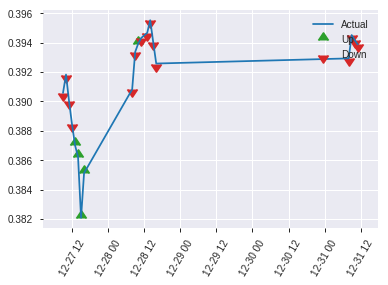


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2398364522401625
RMSE: 0.4897309998766287
LogLoss: 0.6726633605483167
Mean Per-Class Error: 0.4341908091908092
AUC: 0.5602730602730602
pr_auc: 0.45545640381110175
Gini: 0.12054612054612046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39311734632011514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393117     0.58147   221
max f2                       0.393117     0.776451  221
max f0point5                 0.415318     0.486443  133
max accuracy                 0.504984     0.609865  13
max precision                0.553991     1         0
max recall                   0.393117     1         221
max specificity              0.553991     1         0
max absolute_mcc             0.46123      0.138589  43
max min_per_class_accuracy   0.420291     0.55303   109
max mean_per_class_accuracy  0.426127     0.565809  87

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 43.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.54339            0.81685   0.81685            0.333333         0.550258  0.333333                    0.550258            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.535334           1.22527   0.98022            0.5              0.538518  0.4                         0.545562            0.010989        0.021978                   22.5275   -1.97802
    3        0.0313901                   0.525226           2.45055   1.40031            1                0.529579  0.571429                    0.540995            0.021978        0.043956                   145.055   40.0314
    4        0.0403587                   0.511212           0         1.08913            0                0.519205  0.444444                    0.536153            0               0.043956                   -100      8.91331
    5        0.0538117                   0.505739           2.45055   1.42949            1                0.507939  0.583333                    0.5291              0.032967        0.0769231                  145.055   42.9487
    6        0.103139                    0.484967           0.891109  1.172              0.363636         0.495446  0.478261                    0.513005            0.043956        0.120879                   -10.8891  17.2002
    7        0.152466                    0.472938           1.11389   1.1532             0.454545         0.477997  0.470588                    0.501679            0.0549451       0.175824                   11.3886   15.32
    8        0.201794                    0.458926           1.78222   1.30696            0.727273         0.466615  0.533333                    0.493107            0.0879121       0.263736                   78.2218   30.696
    9        0.300448                    0.441432           0.77972   1.13384            0.318182         0.449986  0.462687                    0.478948            0.0769231       0.340659                   -22.028   13.3836
    10       0.399103                    0.425928           1.33666   1.18397            0.545455         0.432692  0.483146                    0.467514            0.131868        0.472527                   33.6663   18.3973
    11       0.502242                    0.419689           0.958911  1.13776            0.391304         0.4222    0.464286                    0.458208            0.0989011       0.571429                   -4.10893  13.7755
    12       0.600897                    0.415279           1.0025    1.11555            0.409091         0.417639  0.455224                    0.451548            0.0989011       0.67033                    0.24975   11.5549
    13       0.699552                    0.411379           0.556943  1.03677            0.227273         0.413713  0.423077                    0.446212            0.0549451       0.725275                   -44.3057  3.67709
    14       0.798206                    0.407525           0.77972   1.005              0.318182         0.409509  0.410112                    0.441676            0.0769231       0.802198                   -22.028   0.500062
    15       0.896861                    0.403774           1.11389   1.01698            0.454545         0.405599  0.415                       0.437707            0.10989         0.912088                   11.3886   1.6978
    16       1                           0.392175           0.852365  1                  0.347826         0.400892  0.408072                    0.43391            

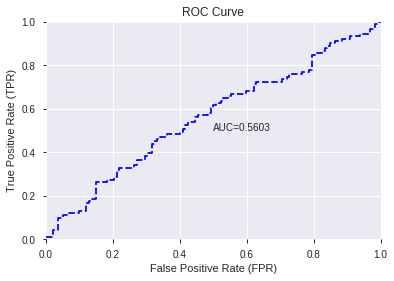

This function is available for GLM models only


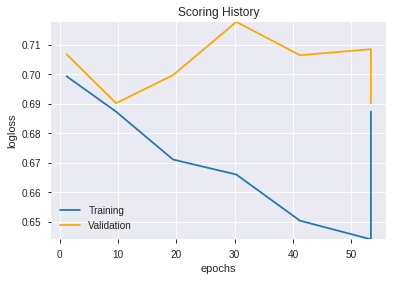

--2019-08-27 16:38:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.120
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_163140_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_163140_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'days_in_month',
 'CORREL_8',
 'MFI_12',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'STOCH_slowd',
 'CMO_24',
 'day',
 'CDLSPINNINGTOP',
 'ATR_8',
 'BOP',
 'MACDFIX_hist_8',
 'ADX_12',
 'MACDFIX_hist_14',
 'aroonup_14',
 'ATR_30',
 'PLUS_DM_20',
 'PLUS_DM_14',
 'STDDEV_12',
 'WILLR_30',
 'ROC_8',
 'MINMAX_min_12',
 'BBANDS_upperband_8_8_4',
 'CDLADVANCEBLOCK',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lowerband_30_7_5',
 'CDLMORNINGSTAR',
 'CDLMARUBOZU',
 'BBANDS_upperband_20_2_3',
 'LINEARREG_30',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_middleband_30_5_3',
 'BBANDS_middleband_24_2_2',
 'MAVP_30_2',
 'MA_14_4',
 'MAVP_30_1',
 'MIDPRICE_20',
 'BBANDS_upperband_12_6_2',
 'BBANDS_lowerband_20_7_4',
 'BBANDS_middleband_8_8_2',
 'BBANDS_upperband_8_5_5',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_14_4_4',
 'CDLINNECK',
 'BBANDS_upperband_8_2_4',
 'CDLSTALLEDPATTERN']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_163823_model_1  0.535298  0.69337              0.496212  0.500157  0.250157

variable  relative_importance  scaled_importance  percentage
0                       hour             0.082520           1.000000    0.111809
1         CDLCLOSINGMARUBOZU             0.065187           0.789950    0.088323
2                   CORREL_8             0.045624           0.552885    0.061817
3                     CMO_24             0.043096           0.522248    0.058392
4                      ATR_8             0.042357           0.513300    0.057392
5             CDLSPINNINGTOP             0.037971           0.460142    0.051448
6          CDLSTALLEDPATTERN             0.035243           0.427091    0.047753
7                 PLUS_DM_14             0.031335           0.379724    0.042457
8             MACDFIX_hist_8             0.031179           0.377840    0.042246
9              days_in_month             0.030791           0.373132    0.041720
10                    ADX_12             0.029290           0.354945    0.039686
11                 STDDEV_12             0.027194           0.329549    0.036846
12                 CDLINNECK             0.026939           0.326459    0.036501
13           MACDFIX_hist_14             0.022775           0.275991    0.030858
14                 dayofweek             0.019828           0.240286    0.026866
15                       BOP             0.019122           0.231722    0.025909
16                     ROC_8             0.015433           0.187020    0.020911
17                PLUS_DM_20             0.015043           0.182290    0.020382
18           CDLADVANCEBLOCK             0.014532           0.176100    0.019690
19                    MFI_12             0.013086           0.158582    0.017731
20   BBANDS_lowerband_30_7_5             0.010566           0.128042    0.014316
21            CDLMORNINGSTAR             0.009662           0.117087    0.013091
22               STOCH_slowd             0.009538           0.115580    0.012923
23    BBANDS_upperband_8_5_5             0.005340           0.064711    0.007235
24   BBANDS_lowerband_20_7_4             0.005271           0.063875    0.007142
25                    ATR_30             0.005159           0.062517    0.006990
26    BBANDS_lowerband_8_4_5             0.005066           0.061397    0.006865
27    BBANDS_upperband_8_2_4             0.004552           0.055162    0.006168
28   BBANDS_upperband_20_2_3             0.004283           0.051906    0.005804
29             MINMAX_min_12             0.004110           0.049805    0.005569
30    BBANDS_upperband_8_8_4             0.003802           0.046077    0.005152
31               CDLMARUBOZU             0.003418           0.041423    0.004631
32  BBANDS_middleband_30_5_3             0.003404           0.041250    0.004612
33                       day             0.003347           0.040562    0.004535
34              LINEARREG_30             0.002541           0.030794    0.003443
35   BBANDS_lowerband_20_1_3             0.001557           0.018869    0.002110
36   BBANDS_lowerband_14_1_2             0.001198           0.014520    0.001624
37  BBANDS_middleband_24_2_2             0.000997           0.012080    0.001351
38                aroonup_14             0.000897           0.010875    0.001216
39   BBANDS_middleband_8_8_2             0.000886           0.010738    0.001201
40                  WILLR_30             0.000850           0.010306    0.001152
41   BBANDS_middleband_8_8_5             0.000609           0.007385    0.000826
42                 MAVP_30_2             0.000582           0.007051    0.000788
43                   MA_14_4             0.000405           0.004907    0.000549
44  BBANDS_middleband_14_4_4             0.000364           0.004407    0.000493
45                 MAVP_30_1             0.000310           0.003758    0.000420
46  BBANDS_middleband_14_5_2             0.000269           0.003258    0.000364
47   BBANDS_upperband_12_6_2             0.000264           0.003202    0.000358
48               MIDPRICE_20             0.000181  

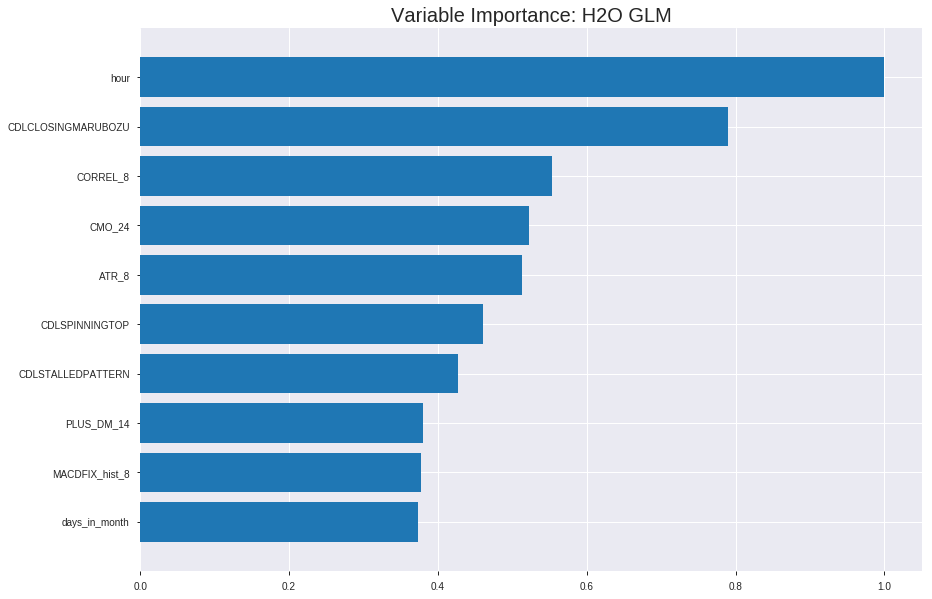

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163823_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2452521307344029
RMSE: 0.49522937184137505
LogLoss: 0.683533343941153
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.805536138753
Residual deviance: 2129.8898997206325
AIC: 2231.8898997206325
AUC: 0.585525480987105
pr_auc: 0.5901636567799983
Gini: 0.17105096197421
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41560920713495647: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   751   0.969    (751.0/775.0)
1      6    777   0.0077   (6.0/783.0)
Total  30   1528  0.4859   (757.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415609     0.672436  380
max f2                       0.395007     0.835289  396
max f0point5                 0.491065     0.570728  231
max accuracy                 0.505919     0.567394  190
max precision                0.783371     1         0
max recall                   0.395007     1         396
max specificity              0.783371     1         0
max absolute_mcc             0.531567     0.150828  113
max min_per_class_accuracy   0.503697     0.566452  196
max mean_per_class_accuracy  0.505919     0.567528  190

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.585249           1.6167    1.6167             0.8125           0.616867  0.8125                      0.616867            0.0166028       0.0166028                  61.6699   61.6699
    2        0.0205392                   0.578828           1.24361   1.43016            0.625            0.58195   0.71875                     0.599409            0.0127714       0.0293742                  24.3614   43.0156
    3        0.0301669                   0.573179           1.45917   1.43942            0.733333         0.575692  0.723404                    0.59184             0.0140485       0.0434227                  45.9174   43.9417
    4        0.0404365                   0.566006           1.24361   1.38969            0.625            0.570284  0.698413                    0.586365            0.0127714       0.0561941                  24.3614   38.969
    5        0.0500642                   0.563163           1.45917   1.40305            0.733333         0.564587  0.705128                    0.582177            0.0140485       0.0702427                  45.9174   40.3052
    6        0.100128                    0.552611           1.40305   1.40305            0.705128         0.558054  0.705128                    0.570115            0.0702427       0.140485                   40.3052   40.3052
    7        0.150193                    0.544132           1.07142   1.29251            0.538462         0.547998  0.649573                    0.562743            0.0536398       0.194125                   7.14216   29.2509
    8        0.200257                    0.535613           1.2755    1.28826            0.641026         0.540099  0.647436                    0.557082            0.063857        0.257982                   27.5502   28.8257
    9        0.300385                    0.523436           0.931116  1.16921            0.467949         0.529149  0.587607                    0.547771            0.0932312       0.351213                   -6.88836  16.921
    10       0.399872                    0.51302            1.09117   1.14979            0.548387         0.518172  0.577849                    0.540407            0.108557        0.45977                    9.11713   14.9794
    11       0.5                         0.50353            1.05867   1.13155            0.532051         0.507969  0.568678                    0.533911            0.106003        0.565773                   5.86665   13.1545
    12       0.600128                    0.49372            0.905606  1.09385            0.455128         0.498356  0.549733                    0.527979            0.0906769       0.65645                    -9.43937  9.38486
    13       0.699615                    0.4826             0.821588  1.05513            0.412903         0.488325  0.530275                    0.52234             0.0817369       0.738186                   -17.8412  5.51326
    14       0.799743                    0.470537           0.931116  1.03961            0.467949         0.477335  0.522472                    0.516705            0.0932312       0.831418                   -6.88836  3.96057
    15       0.899872                    0.451456           0.956626  1.03037            0.480769         0.462092  0.517832                    0.510628            0.0957854       0.927203                   -4.33736  3.03726
    16       1                           0.245683           0.727036  1                  0.365385         0.430121  0.502567                    0.502567           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.247677684858402
RMSE: 0.49767226651522584
LogLoss: 0.6884996100124966
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.4838984721613
Residual deviance: 614.141652131147
AIC: 716.141652131147
AUC: 0.5628726232678053
pr_auc: 0.5179494154436188
Gini: 0.1257452465356106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4282341868367184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   222  0.9569   (222.0/232.0)
1      3    211  0.014    (3.0/214.0)
Total  13   433  0.5045   (225.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428234     0.652241  386
max f2                       0.39766      0.822444  398
max f0point5                 0.495536     0.555556  228
max accuracy                 0.495984     0.56278   226
max precision                0.555664     0.583333  32
max recall                   0.39766      1         398
max specificity              0.609894     0.99569   0
max absolute_mcc             0.495536     0.133381  228
max min_per_class_accuracy   0.50346      0.542056  196
max mean_per_class_accuracy  0.495536     0.565964  228

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.588288           0.833645  0.833645           0.4              0.596308  0.4                         0.596308            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.575181           1.04206   0.926272           0.5              0.58113   0.444444                    0.589563            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.569849           0.833645  0.893191           0.4              0.57291   0.428571                    0.583615            0.00934579      0.0280374                  -16.6355  -10.6809
    4        0.0403587                   0.564754           0.521028  0.810488           0.25             0.566959  0.388889                    0.579914            0.0046729       0.0327103                  -47.8972  -18.9512
    5        0.0515695                   0.561279           1.66729   0.996749           0.8              0.562869  0.478261                    0.576208            0.0186916       0.0514019                  66.729    -0.325071
    6        0.100897                    0.551488           1.32625   1.15784            0.636364         0.556342  0.555556                    0.566496            0.0654206       0.116822                   32.6253   15.784
    7        0.150224                    0.539324           1.04206   1.11982            0.5              0.543441  0.537313                    0.558926            0.0514019       0.168224                   4.20561   11.9821
    8        0.201794                    0.533208           1.08736   1.11153            0.521739         0.536317  0.533333                    0.553148            0.0560748       0.224299                   8.73629   11.1526
    9        0.300448                    0.52254            1.13679   1.11982            0.545455         0.527296  0.537313                    0.544659            0.11215         0.336449                   13.6788   11.9821
    10       0.401345                    0.514801           1.0189    1.09445            0.488889         0.518797  0.52514                     0.538158            0.102804        0.439252                   1.88993   9.445
    11       0.5                         0.503403           1.04206   1.08411            0.5              0.508955  0.520179                    0.532396            0.102804        0.542056                   4.20561   8.41121
    12       0.600897                    0.492991           1.20415   1.10427            0.577778         0.498485  0.529851                    0.526702            0.121495        0.663551                   20.4154   10.4268
    13       0.699552                    0.482264           0.852591  1.06878            0.409091         0.488184  0.512821                    0.52127             0.0841121       0.747664                   -14.7409  6.87755
    14       0.800448                    0.472411           0.787331  1.0333             0.377778         0.477255  0.495798                    0.515722            0.0794393       0.827103                   -21.2669  3.32993
    15       0.899103                    0.454323           0.899958  1.01867            0.431818         0.464327  0.488778                    0.510082            0.088785        0.915888                   -10.0042  1.86683
    16       1                           0.393654           0.833645  1                  0.4              0.435268  0.479821                    0.502534      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:38:23  0.000 sec   2            4         51            1.38304           1.3834
    2019-08-27 16:38:23  0.010 sec   4            2.5       51            1.38154           1.38229
    2019-08-27 16:38:23  0.022 sec   6            1.6       51            1.37954           1.38103
    2019-08-27 16:38:23  0.034 sec   8            0.96      51            1.37699           1.3797
    2019-08-27 16:38:23  0.045 sec   10           0.6       51            1.37394           1.37847
    2019-08-27 16:38:23  0.055 sec   12           0.37      51            1.37055           1.37751
    2019-08-27 16:38:23  0.065 sec   14           0.23      51            1.36707           1.377
    2019-08-27 16:38:23  0.075 sec   16           0.14      51            1.36377           1.37709
    2019-08-27 16:38:23  0.088 sec   18           0.089     51            1.36089           1.37779
    2019-08-27 16:38:23  0.101 sec   20           0.055     51            1.35853           1.37896
    2019-08-27 16:38:23  0.116 sec   22           0.034     51            1.35669           1.38039
    2019-08-27 16:38:23  0.132 sec   24           0.021     51            1.35529           1.38186

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6233183856502242)

('F1', 0.5814696485623003)

('auc', 0.5352980352980353)

('logloss', 0.6933701051997117)

('mean_per_class_error', 0.441017316017316)

('rmse', 0.5001566879511891)

('mse', 0.2501567125023031)

glm prediction progress: |████████████████████████████████████████████████| 100%


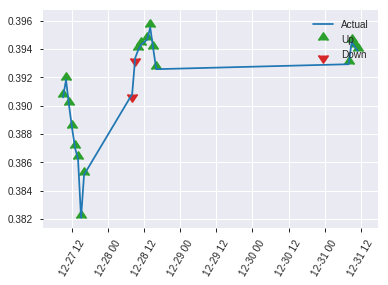


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501567125023031
RMSE: 0.5001566879511891
LogLoss: 0.6933701051997117
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.5705785684792
Residual deviance: 309.2430669190714
AIC: 411.2430669190714
AUC: 0.5352980352980353
pr_auc: 0.46191376848832255
Gini: 0.07059607059607065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40676592607959455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406766     0.58147   221
max f2                       0.406766     0.776451  221
max f0point5                 0.521294     0.474453  79
max accuracy                 0.56598      0.623318  12
max precision                0.730935     1         0
max recall                   0.406766     1         221
max specificity              0.730935     1         0
max absolute_mcc             0.56598      0.182834  12
max min_per_class_accuracy   0.512101     0.505495  104
max mean_per_class_accuracy  0.521294     0.558983  79

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.599932           1.6337    1.6337             0.666667         0.64565   0.666667                    0.64565             0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.578776           1.22527   1.47033            0.5              0.586443  0.6                         0.621967            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.57237            2.45055   1.75039            1                0.5733    0.714286                    0.608062            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.571822           1.22527   1.6337             0.5              0.572112  0.666667                    0.600073            0.010989        0.0659341                  22.5275   63.37
    5        0.0538117                   0.567129           2.45055   1.83791            1                0.569669  0.75                        0.592472            0.032967        0.0989011                  145.055   83.7912
    6        0.103139                    0.554686           0.891109  1.38509            0.363636         0.5602    0.565217                    0.577038            0.043956        0.142857                   -10.8891  38.5093
    7        0.152466                    0.545322           0.445554  1.08112            0.181818         0.549875  0.441176                    0.56825             0.021978        0.164835                   -55.4446  8.11248
    8        0.201794                    0.538733           1.33666   1.14359            0.545455         0.54176   0.466667                    0.561775            0.0659341       0.230769                   33.6663   14.359
    9        0.300448                    0.526294           0.891109  1.06069            0.363636         0.532035  0.432836                    0.552009            0.0879121       0.318681                   -10.8891  6.06856
    10       0.399103                    0.518091           1.33666   1.1289             0.545455         0.522113  0.460674                    0.544619            0.131868        0.450549                   33.6663   12.8905
    11       0.502242                    0.508336           0.532728  1.00648            0.217391         0.513807  0.410714                    0.538292            0.0549451       0.505495                   -46.7272  0.647567
    12       0.600897                    0.497255           1.0025    1.00582            0.409091         0.501876  0.410448                    0.532313            0.0989011       0.604396                   0.24975   0.582254
    13       0.699552                    0.486533           1.22527   1.03677            0.5              0.491744  0.423077                    0.526592            0.120879        0.725275                   22.5275   3.67709
    14       0.798206                    0.471282           0.668332  0.991233           0.272727         0.479196  0.404494                    0.520734            0.0659341       0.791209                   -33.1668  -0.876651
    15       0.896861                    0.454341           1.0025    0.992473           0.409091         0.463942  0.405                       0.514487            0.0989011       0.89011                    0.24975   -0.752747
    16       1                           0.39254            1.06546   1                  0.434783         0.432152  0.408072                    0.505995         

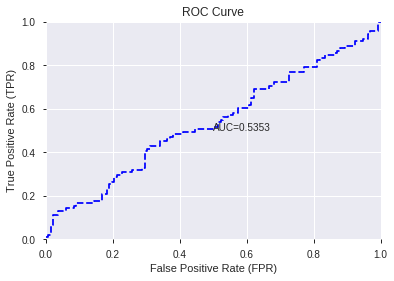

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


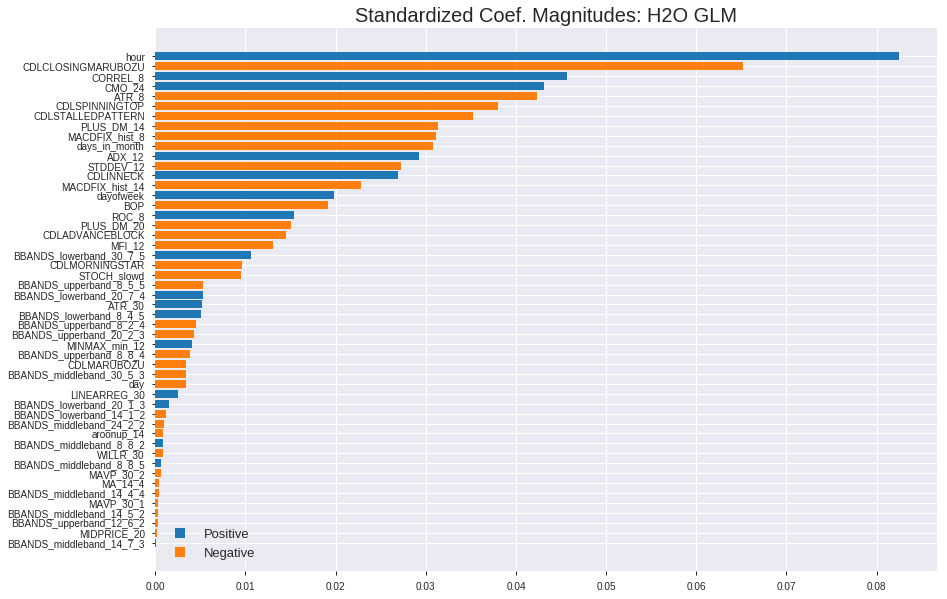

'log_likelihood'
--2019-08-27 16:38:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163823_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163823_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['hour',
 'CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'CMO_24',
 'ATR_8',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'PLUS_DM_14',
 'MACDFIX_hist_8',
 'days_in_month',
 'ADX_12',
 'STDDEV_12',
 'CDLINNECK',
 'MACDFIX_hist_14',
 'dayofweek',
 'BOP',
 'ROC_8',
 'PLUS_DM_20',
 'CDLADVANCEBLOCK',
 'MFI_12',
 'BBANDS_lowerband_30_7_5',
 'CDLMORNINGSTAR',
 'STOCH_slowd',
 'BBANDS_upperband_8_5_5',
 'BBANDS_lowerband_20_7_4',
 'ATR_30',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_upperband_8_2_4',
 'BBANDS_upperband_20_2_3',
 'MINMAX_min_12',
 'BBANDS_upperband_8_8_4',
 'CDLMARUBOZU',
 'BBANDS_middleband_30_5_3',
 'day',
 'LINEARREG_30',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_middleband_24_2_2',
 'aroonup_14',
 'BBANDS_middleband_8_8_2',
 'WILLR_30',
 'BBANDS_middleband_8_8_5',
 'MAVP_30_2',
 'MA_14_4',
 'BBANDS_middleband_14_4_4',
 'MAVP_30_1',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_12_6_2',
 'MIDPRICE_20',
 'BBANDS_middleband_14_7_3']

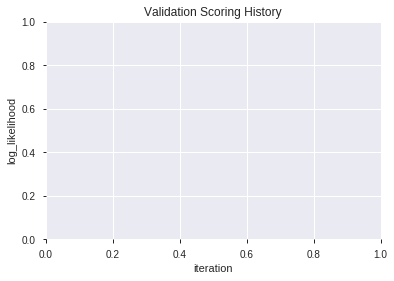

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_163835_model_5  0.555778  0.758419              0.488636  0.527622  0.278385
1  XGBoost_grid_1_AutoML_20190827_163835_model_1  0.545538  0.696609              0.496212  0.501357  0.251359
2               XGBoost_2_AutoML_20190827_163835  0.537629  0.692285              0.492424  0.499378  0.249378
3               XGBoost_1_AutoML_20190827_163835  0.528971  0.702286              0.500000  0.504227  0.254245
4  XGBoost_grid_1_AutoML_20190827_163835_model_4  0.525225  0.693863              0.496212  0.500272  0.250272
5               XGBoost_3_AutoML_20190827_163835  0.520813  0.703822              0.496212  0.505109  0.255135
6  XGBoost_grid_1_AutoML_20190827_163835_model_7  0.512071  0.695986              0.490343  0.500943  0.250944
7  XGBoost_grid_1_AutoML_20190827_163835_model_2  0.502747  0.700767              0.496212  0.503718  0.253731
8  XGBoost_grid_1_AutoML_20190827_163835_model_6  0.502581  0.717195              0.492424  0.511472  0.261604
9  XGBoost_grid_1_AutoML_20190827_163835_model_3  0.487429  0.708073              0.496212  0.507158  0.257209

variable  relative_importance  scaled_importance  percentage
0                     MFI_12          1299.844238           1.000000    0.060488
1                        BOP          1294.677124           0.996025    0.060248
2                STOCH_slowd          1014.979126           0.780847    0.047232
3                       hour           960.035217           0.738577    0.044675
4                   WILLR_30           902.916504           0.694634    0.042017
5             MACDFIX_hist_8           896.865234           0.689979    0.041736
6     BBANDS_upperband_8_2_4           857.658997           0.659817    0.039911
7                 PLUS_DM_14           852.391479           0.655764    0.039666
8            MACDFIX_hist_14           838.274292           0.644904    0.039009
9                      ATR_8           826.554565           0.635887    0.038464
10                    ATR_30           811.402527           0.624231    0.037759
11                    ADX_12           798.510620           0.614313    0.037159
12                    CMO_24           761.924133           0.586166    0.035456
13                     ROC_8           753.095886           0.579374    0.035045
14    BBANDS_lowerband_8_4_5           735.916077           0.566157    0.034246
15                PLUS_DM_20           701.871643           0.539966    0.032662
16                 STDDEV_12           696.687256           0.535977    0.032420
17                       day           611.200378           0.470210    0.028442
18                aroonup_14           486.349487           0.374160    0.022632
19   BBANDS_lowerband_30_7_5           440.240417           0.338687    0.020487
20   BBANDS_upperband_12_6_2           368.080841           0.283173    0.017129
21    BBANDS_upperband_8_5_5           364.373779           0.280321    0.016956
22   BBANDS_lowerband_20_7_4           351.992279           0.270796    0.016380
23   BBANDS_middleband_8_8_2           327.176025           0.251704    0.015225
24   BBANDS_lowerband_20_1_3           324.364899           0.249541    0.015094
25    BBANDS_upperband_8_8_4           318.448517           0.244990    0.014819
26                 dayofweek           273.250488           0.210218    0.012716
27   BBANDS_lowerband_14_1_2           256.886414           0.197629    0.011954
28   BBANDS_upperband_20_2_3           243.753448           0.187525    0.011343
29                   MA_14_4           241.071793           0.185462    0.011218
30            CDLSPINNINGTOP           224.501556           0.172714    0.010447
31  BBANDS_middleband_30_5_3           190.741440           0.146742    0.008876
32                  CORREL_8           181.391418           0.139549    0.008441
33                 MAVP_30_2           180.412308           0.138795    0.008396
34                 MAVP_30_1           178.654678           0.137443    0.008314
35  BBANDS_middleband_14_5_2           145.168320           0.111681    0.006755
36   BBANDS_middleband_8_8_5           119.772995           0.092144    0.005574
37             days_in_month           104.502098           0.080396    0.004863
38               MIDPRICE_20            99.222565           0.076334    0.004617
39              LINEARREG_30            97.718697           0.075177    0.004547
40        CDLCLOSINGMARUBOZU            92.743202           0.071349    0.004316
41  BBANDS_middleband_14_7_3            71.379364           0.054914    0.003322
42  BBANDS_middleband_24_2_2            56.665512           0.043594    0.002637
43  BBANDS_middleband_14_4_4            55.216297           0.042479    0.002569
44             MINMAX_min_12            46.147003           0.035502    0.002147
45               CDLMARUBOZU            28.722486           0.022097    0.001337
46           CDLADVANCEBLOCK             5.403780           0.004157    0.000251

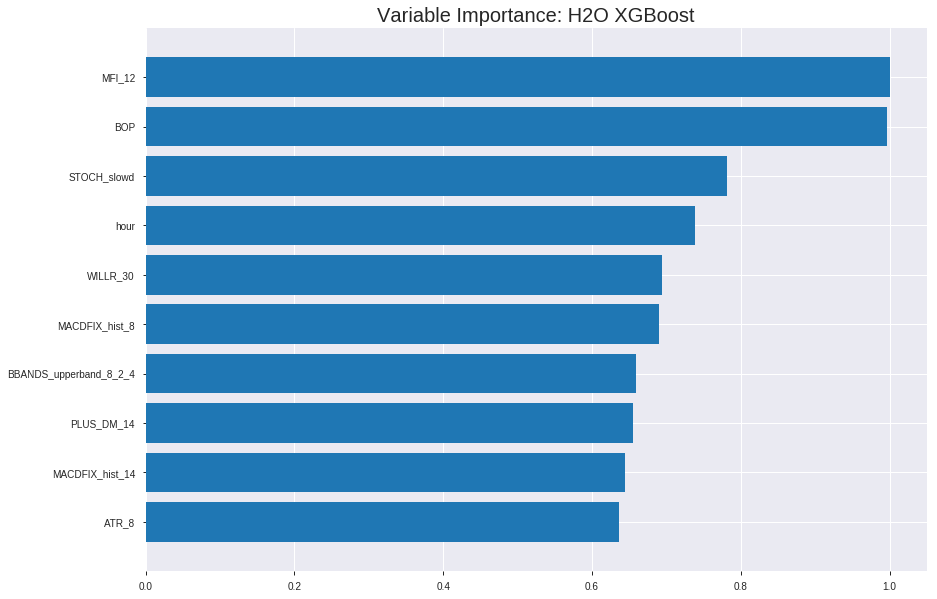

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_163835_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.050367185351031574
RMSE: 0.2244263472746272
LogLoss: 0.24486234449420796
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987228607918264
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5324389338493347: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      775  0    0        (0.0/775.0)
1      0    783  0        (0.0/783.0)
Total  775  783  0        (0.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.532439     1        201
max f2                       0.532439     1        201
max f0point5                 0.532439     1        201
max accuracy                 0.532439     1        201
max precision                0.927702     1        0
max recall                   0.532439     1        201
max specificity              0.927702     1        0
max absolute_mcc             0.532439     1        201
max min_per_class_accuracy   0.532439     1        201
max mean_per_class_accuracy  0.532439     1        201

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.28 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102696                   0.89476            1.98978    1.98978            1                0.908652  1                           0.908652            0.0204342       0.0204342                  98.9783  98.9783
    2        0.0205392                   0.886867           1.98978    1.98978            1                0.890326  1                           0.899489            0.0204342       0.0408685                  98.9783  98.9783
    3        0.0301669                   0.880816           1.98978    1.98978            1                0.883999  1                           0.894546            0.0191571       0.0600255                  98.9783  98.9783
    4        0.0404365                   0.874533           1.98978    1.98978            1                0.876683  1                           0.890009            0.0204342       0.0804598                  98.9783  98.9783
    5        0.0500642                   0.870698           1.98978    1.98978            1                0.873019  1                           0.886742            0.0191571       0.0996169                  98.9783  98.9783
    6        0.100128                    0.846438           1.98978    1.98978            1                0.858471  1                           0.872607            0.0996169       0.199234                   98.9783  98.9783
    7        0.150193                    0.824196           1.98978    1.98978            1                0.835571  1                           0.860261            0.0996169       0.298851                   98.9783  98.9783
    8        0.200257                    0.807624           1.98978    1.98978            1                0.815668  1                           0.849113            0.0996169       0.398467                   98.9783  98.9783
    9        0.300385                    0.77667            1.98978    1.98978            1                0.792997  1                           0.830408            0.199234        0.597701                   98.9783  98.9783
    10       0.399872                    0.734202           1.98978    1.98978            1                0.756958  1                           0.812134            0.197957        0.795658                   98.9783  98.9783
    11       0.5                         0.571408           1.98978    1.98978            1                0.693865  1                           0.78845             0.199234        0.994891                   98.9783  98.9783
    12       0.600128                    0.266099           0.0510201  1.66631            0.025641         0.326271  0.837433                    0.711338            0.00510856      1                          -94.898  66.631
    13       0.699615                    0.225903           0          1.42936            0                0.243468  0.718349                    0.644806            0               1                          -100     42.9358
    14       0.799743                    0.191503           0          1.2504             0                0.209947  0.628411                    0.590361            0               1                          -100     25.0401
    15       0.899872                    0.156213           0          1.11127            0                0.173717  0.558488                    0.544001            0               1                          -100     11.127
    16       1                           0.0881847          0          1                  0                0.132934  0.502567                    0.502842          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2687789776916954
RMSE: 0.5184389816474986
LogLoss: 0.7352468406174894
Mean Per-Class Error: 0.47367466967450855
AUC: 0.5146833709313567
pr_auc: 0.5001948341230924
Gini: 0.029366741862713486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20169009268283844: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    214  0        (0.0/214.0)
Total  1    445  0.5179   (231.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.20169      0.649469   398
max f2                       0.20169      0.822444   398
max f0point5                 0.413255     0.537701   308
max accuracy                 0.686348     0.535874   65
max precision                0.873936     1          0
max recall                   0.20169      1          398
max specificity              0.873936     1          0
max absolute_mcc             0.850576     0.0698812  1
max min_per_class_accuracy   0.528092     0.504673   199
max mean_per_class_accuracy  0.420246     0.526325   299

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 53.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.830192           1.66729   1.66729            0.8              0.851517  0.8                         0.851517            0.0186916       0.0186916                  66.729     66.729
    2        0.0201794                   0.807983           1.04206   1.38941            0.5              0.817963  0.666667                    0.836604            0.00934579      0.0280374                  4.20561    38.9408
    3        0.0313901                   0.796294           0.833645  1.19092            0.4              0.802614  0.571429                    0.824465            0.00934579      0.0373832                  -16.6355   19.0921
    4        0.0403587                   0.782761           1.56308   1.27362            0.75             0.786829  0.611111                    0.816101            0.0140187       0.0514019                  56.3084    27.3624
    5        0.0515695                   0.776517           0.833645  1.17798            0.4              0.780379  0.565217                    0.808336            0.00934579      0.0607477                  -16.6355   17.7976
    6        0.100897                    0.731688           0.947324  1.06521            0.454545         0.751541  0.511111                    0.780569            0.046729        0.107477                   -5.26763   6.52129
    7        0.150224                    0.688597           1.23152   1.11982            0.590909         0.712869  0.537313                    0.75834             0.0607477       0.168224                   23.1521    11.9821
    8        0.201794                    0.661702           0.634295  0.995742           0.304348         0.675164  0.477778                    0.737083            0.0327103       0.200935                   -36.5705   -0.425753
    9        0.300448                    0.614281           1.18415   1.05761            0.568182         0.6372    0.507463                    0.704286            0.116822        0.317757                   18.4155    5.76092
    10       0.401345                    0.577298           0.879958  1.01295            0.422222         0.595449  0.486034                    0.676925            0.088785        0.406542                   -12.0042   1.29484
    11       0.5                         0.527263           0.99469   1.00935            0.477273         0.549723  0.484305                    0.651827            0.0981308       0.504673                   -0.531011  0.934579
    12       0.600897                    0.486424           0.972586  1.00317            0.466667         0.508306  0.481343                    0.627728            0.0981308       0.602804                   -2.74143   0.317339
    13       0.699552                    0.447834           1.08942   1.01534            0.522727         0.465304  0.487179                    0.604822            0.107477        0.71028                    8.94223    1.53367
    14       0.800448                    0.405807           1.06521   1.02162            0.511111         0.425006  0.490196                    0.582156            0.107477        0.817757                   6.52129    2.16236
    15       0.899103                    0.340852           0.852591  1.00308            0.409091         0.375273  0.481297                    0.559456            0.0841121       0.901869                   -14.7409   0.307642
    16       1                           0.195313           0.972586  1                  0.466667         0.294583  0.479821                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:38:42  3.240 sec   0                  0.5              0.693147            0.5             0                  1                0.497433                         0.5                0.693147              0.5               0                    1                  0.520179
    2019-08-27 16:38:42  3.576 sec   5                  0.456471         0.6093              0.950632        0.949879           1.98978          0.120668                         0.49886            0.690904              0.541563          0.52112              2.08411            0.517937
    2019-08-27 16:38:43  3.868 sec   10                 0.41566          0.535912            0.989433        0.987226           1.98978          0.0449294                        0.497813           0.688888              0.561886          0.510206             0.416822           0.511211
    2019-08-27 16:38:43  4.176 sec   15                 0.383154         0.480519            0.996735        0.995427           1.98978          0.0263158                        0.503269           0.700061              0.527675          0.499088             1.66729            0.517937
    2019-08-27 16:38:43  4.487 sec   20                 0.351064         0.428467            0.999312        0.998049           1.98978          0.0134788                        0.505867           0.705705              0.524754          0.50004              1.25047            0.517937
    2019-08-27 16:38:44  4.835 sec   25                 0.320997         0.382032            0.99984         0.998567           1.98978          0.00641849                       0.509176           0.712816              0.515983          0.497213             1.25047            0.520179
    2019-08-27 16:38:44  5.166 sec   30                 0.298188         0.347799            0.999975        0.998698           1.98978          0.00256739                       0.511329           0.717443              0.509376          0.500932             1.66729            0.515695
    2019-08-27 16:38:44  5.480 sec   35                 0.279391         0.320428            0.999983        0.998706           1.98978          0.000641849                      0.51348            0.72265               0.510907          0.495898             1.25047            0.515695
    2019-08-27 16:38:45  5.840 sec   40                 0.258506         0.290917            0.999997        0.99872            1.98978          0.000641849                      0.514345           0.725073              0.515459          0.49769              1.66729            0.511211
    2019-08-27 16:38:45  6.206 sec   45                 0.241043         0.266935            0.999998        0.99872            1.98978          0.000641849                      0.515739           0.728731              0.515711          0.49717              1.66729            0.515695
    2019-08-27 16:38:45  6.575 sec   50                 0.224426         0.244862            1               0.998723           1.98978          0                                0.518439           0.735247              0.514683          0.500195             1.66729            0.517937

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
MFI_12                    1299.84423828125       1.0                   0.06048837624164804
BOP                       1294.6771240234375     0.996024820431835     0.06024792408430077
STOCH_slowd               1014.9791259765625     0.7808467323120521    0.047232150931152836
hour                      960.0352172851562      0.7385771225593811    0.04467533087284564
WILLR_30                  902.91650390625        0.6946343856554327    0.04201730606991186
---                       ---                    ---                   ---
BBANDS_middleband_24_2_2  56.66551208496094      0.04359407874891861   0.002636935037272622
BBANDS_middleband_14_4_4  55.2162971496582       0.04247916444409468   0.0025694956813252364
MINMAX_min_12             46.147003173828125     0.03550194847564744   0.002147455216706565
CDLMARUBOZU               28.72248649597168      0.022096867955464165  0.0013366036626521324
CDLADVANCEBLOCK           5.403779983520508      0.00415725194171402   0.0002514654195817195


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6053811659192825)

('F1', 0.5852090032154341)

('auc', 0.5557775557775557)

('logloss', 0.7584188032741153)

('mean_per_class_error', 0.41903929403929396)

('rmse', 0.5276219566974448)

('mse', 0.2783849291892403)

xgboost prediction progress: |████████████████████████████████████████████| 100%


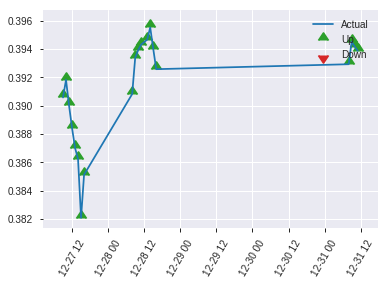


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2783849291892403
RMSE: 0.5276219566974448
LogLoss: 0.7584188032741153
Mean Per-Class Error: 0.41903929403929396
AUC: 0.5557775557775557
pr_auc: 0.44474041144403675
Gini: 0.11155511155511144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30400246381759644: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    129  0.9773   (129.0/132.0)
1      0    91   0        (0.0/91.0)
Total  3    220  0.5785   (129.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304002     0.585209  219
max f2                       0.304002     0.77911   219
max f0point5                 0.634984     0.503513  83
max accuracy                 0.685284     0.605381  46
max precision                0.685284     0.531915  46
max recall                   0.304002     1         219
max specificity              0.877314     0.992424  0
max absolute_mcc             0.634984     0.164235  83
max min_per_class_accuracy   0.607274     0.56044   108
max mean_per_class_accuracy  0.634984     0.580961  83

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 58.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.828395           0.81685   0.81685            0.333333         0.850822  0.333333                    0.850822            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.824242           1.22527   0.98022            0.5              0.824651  0.4                         0.840354            0.010989        0.021978                   22.5275   -1.97802
    3        0.0313901                   0.815883           0         0.700157           0                0.820442  0.285714                    0.834664            0               0.021978                   -100      -29.9843
    4        0.0403587                   0.80421            2.45055   1.08913            1                0.811413  0.444444                    0.829497            0.021978        0.043956                   145.055   8.91331
    5        0.0538117                   0.794742           0.81685   1.02106            0.333333         0.799812  0.416667                    0.822076            0.010989        0.0549451                  -18.315   2.10623
    6        0.103139                    0.754997           1.33666   1.172              0.545455         0.771363  0.478261                    0.797822            0.0659341       0.120879                   33.6663   17.2002
    7        0.152466                    0.719813           0.891109  1.08112            0.363636         0.738883  0.441176                    0.778753            0.043956        0.164835                   -10.8891  8.11248
    8        0.201794                    0.686859           1.78222   1.2525             0.727273         0.700793  0.511111                    0.759696            0.0879121       0.252747                   78.2218   25.2503
    9        0.300448                    0.657968           0.891109  1.13384            0.363636         0.674635  0.462687                    0.731766            0.0879121       0.340659                   -10.8891  13.3836
    10       0.399103                    0.627165           1.33666   1.18397            0.545455         0.640855  0.483146                    0.709293            0.131868        0.472527                   33.6663   18.3973
    11       0.502242                    0.605305           0.958911  1.13776            0.391304         0.616362  0.464286                    0.690209            0.0989011       0.571429                   -4.10893  13.7755
    12       0.600897                    0.55053            0.668332  1.06069            0.272727         0.574488  0.432836                    0.67121             0.0659341       0.637363                   -33.1668  6.06856
    13       0.699552                    0.500964           1.0025    1.05248            0.409091         0.525083  0.429487                    0.650602            0.0989011       0.736264                   0.24975   5.24796
    14       0.798206                    0.455373           0.668332  1.005              0.272727         0.477054  0.410112                    0.629153            0.0659341       0.802198                   -33.1668  0.500062
    15       0.896861                    0.404715           0.891109  0.992473           0.363636         0.433872  0.405                       0.607672            0.0879121       0.89011                    -10.8891  -0.752747
    16       1                           0.286691           1.06546   1                  0.434783         0.351332  0.408072                    0.581233    

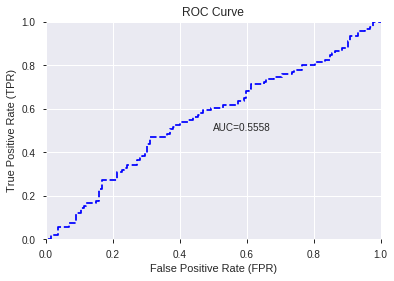

This function is available for GLM models only


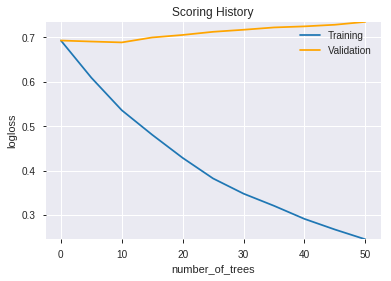

--2019-08-27 16:38:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_163835_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_163835_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MFI_12',
 'BOP',
 'STOCH_slowd',
 'hour',
 'WILLR_30',
 'MACDFIX_hist_8',
 'BBANDS_upperband_8_2_4',
 'PLUS_DM_14',
 'MACDFIX_hist_14',
 'ATR_8',
 'ATR_30',
 'ADX_12',
 'CMO_24',
 'ROC_8',
 'BBANDS_lowerband_8_4_5',
 'PLUS_DM_20',
 'STDDEV_12',
 'day',
 'aroonup_14',
 'BBANDS_lowerband_30_7_5',
 'BBANDS_upperband_12_6_2',
 'BBANDS_upperband_8_5_5',
 'BBANDS_lowerband_20_7_4',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_upperband_8_8_4',
 'dayofweek',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_20_2_3',
 'MA_14_4',
 'CDLSPINNINGTOP',
 'BBANDS_middleband_30_5_3',
 'CORREL_8',
 'MAVP_30_2',
 'MAVP_30_1',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_8_8_5',
 'days_in_month',
 'MIDPRICE_20',
 'LINEARREG_30',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_middleband_14_7_3',
 'BBANDS_middleband_24_2_2',
 'BBANDS_middleband_14_4_4',
 'MINMAX_min_12',
 'CDLMARUBOZU',
 'CDLADVANCEBLOCK']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190827_163859_model_1  0.544123  0.694733              0.496212  0.50077  0.25077

variable  relative_importance  scaled_importance    percentage
0                         hour         2.522471e-02           1.000000  1.760224e-02
1                        DX_30         2.034328e-02           0.806482  1.419590e-02
2           CDLCLOSINGMARUBOZU         2.000156e-02           0.792935  1.395744e-02
3                       Volume         1.884657e-02           0.747147  1.315146e-02
4                        DX_24         1.809014e-02           0.717160  1.262362e-02
...                        ...                  ...                ...           ...
1032    LINEARREG_INTERCEPT_24         1.852703e-06           0.000073  1.292849e-06
1033                  MEDPRICE         8.596957e-07           0.000034  5.999106e-07
1034                   MA_12_2         6.243883e-07           0.000025  4.357090e-07
1035   BBANDS_lowerband_24_1_2         2.621120e-07           0.000010  1.829063e-07
1036  BBANDS_middleband_12_2_2         1.713743e-07           0.000007  1.195879e-07

[1037 rows x 4 columns]

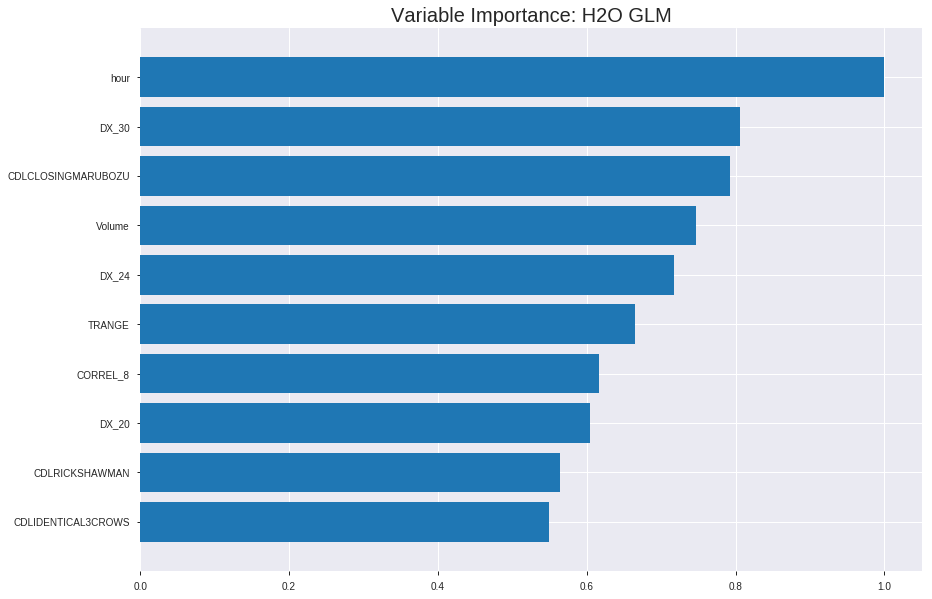

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163859_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24239381890018194
RMSE: 0.49233506771322105
LogLoss: 0.6778004798339731
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2159.805536138753
Residual deviance: 2112.02629516266
AIC: 4188.02629516266
AUC: 0.6235603345280765
pr_auc: 0.6186814077594271
Gini: 0.24712066905615293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41993714298829893: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   727   0.9381   (727.0/775.0)
1      13   770   0.0166   (13.0/783.0)
Total  61   1497  0.475    (740.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419937     0.675439  360
max f2                       0.393318     0.837977  382
max f0point5                 0.503123     0.601999  189
max accuracy                 0.503123     0.598845  189
max precision                0.638801     1         0
max recall                   0.382353     1         388
max specificity              0.638801     1         0
max absolute_mcc             0.503123     0.19778   189
max min_per_class_accuracy   0.506386     0.595147  180
max mean_per_class_accuracy  0.503123     0.598679  189

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.590742           1.74106   1.74106            0.875            0.600597  0.875                       0.600597            0.0178799       0.0178799                  74.106    74.106
    2        0.0205392                   0.580197           1.6167    1.67888            0.8125           0.58498   0.84375                     0.592789            0.0166028       0.0344828                  61.6699   67.8879
    3        0.0301669                   0.574991           0.928565  1.43942            0.466667         0.577303  0.723404                    0.587847            0.00893997      0.0434227                  -7.14347  43.9417
    4        0.0404365                   0.569961           1.36798   1.42127            0.6875           0.572353  0.714286                    0.583912            0.0140485       0.0574713                  36.7976   42.1273
    5        0.0500642                   0.568248           1.45917   1.42856            0.733333         0.568947  0.717949                    0.581034            0.0140485       0.0715198                  45.9174   42.8562
    6        0.100128                    0.554489           1.40305   1.41581            0.705128         0.560997  0.711538                    0.571015            0.0702427       0.141762                   40.3052   41.5807
    7        0.150193                    0.544916           1.17346   1.33503            0.589744         0.54988   0.67094                     0.56397             0.0587484       0.200511                   17.3462   33.5025
    8        0.200257                    0.538137           1.12244   1.28188            0.564103         0.541214  0.644231                    0.558281            0.0561941       0.256705                   12.2442   28.1879
    9        0.300385                    0.526314           1.28826   1.28401            0.647436         0.531776  0.645299                    0.549446            0.128991        0.385696                   28.8257   28.4005
    10       0.399872                    0.516271           1.05266   1.22645            0.529032         0.521149  0.616372                    0.542406            0.104725        0.490421                   5.26593   22.6447
    11       0.5                         0.506151           1.04591   1.19029            0.525641         0.511371  0.598203                    0.536191            0.104725        0.595147                   4.59115   19.0294
    12       0.600128                    0.495692           0.880096  1.13854            0.442308         0.501281  0.572193                    0.530367            0.0881226       0.683269                   -11.9904  13.8539
    13       0.699615                    0.484307           0.872937  1.10077            0.43871          0.489848  0.553211                    0.524605            0.0868455       0.770115                   -12.7063  10.077
    14       0.799743                    0.469214           0.841831  1.06835            0.423077         0.477255  0.536918                    0.518677            0.0842912       0.854406                   -15.8169  6.83505
    15       0.899872                    0.444763           0.727036  1.03037            0.365385         0.458593  0.517832                    0.511991            0.0727969       0.927203                   -27.2964  3.03726
    16       1                           0.310363           0.727036  1                  0.365385         0.417876  0.502567                    0.502567           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2468692106807906
RMSE: 0.49685934697939477
LogLoss: 0.686899301840685
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 618.4838984721613
Residual deviance: 612.7141772418911
AIC: 2688.714177241891
AUC: 0.5816044956493716
pr_auc: 0.5405608130081007
Gini: 0.1632089912987431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3750224247429853: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    214  0        (0.0/214.0)
Total  1    445  0.5179   (231.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375022     0.649469  398
max f2                       0.375022     0.822444  398
max f0point5                 0.493924     0.564516  237
max accuracy                 0.525415     0.573991  133
max precision                0.571301     0.625     22
max recall                   0.375022     1         398
max specificity              0.60904      0.99569   0
max absolute_mcc             0.499171     0.152131  226
max min_per_class_accuracy   0.50821      0.551724  196
max mean_per_class_accuracy  0.499171     0.575129  226

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.592384           0.833645  0.833645           0.4              0.602794  0.4                         0.602794            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.580487           1.04206   0.926272           0.5              0.585826  0.444444                    0.595253            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.577934           1.25047   1.04206            0.6              0.579548  0.5                         0.589644            0.0140187       0.0327103                  25.0467   4.20561
    4        0.0403587                   0.573419           2.08411   1.27362            1                0.574541  0.611111                    0.586288            0.0186916       0.0514019                  108.411   27.3624
    5        0.0515695                   0.571573           1.25047   1.26859            0.6              0.572762  0.608696                    0.583347            0.0140187       0.0654206                  25.0467   26.859
    6        0.100897                    0.557317           1.23152   1.25047            0.590909         0.564803  0.6                         0.574281            0.0607477       0.126168                   23.1521   25.0467
    7        0.150224                    0.54774            0.947324  1.15093            0.454545         0.552423  0.552239                    0.567104            0.046729        0.172897                   -5.26763  15.0928
    8        0.201794                    0.540925           1.3592    1.20415            0.652174         0.544642  0.577778                    0.561364            0.0700935       0.242991                   35.9204   20.4154
    9        0.300448                    0.528621           1.13679   1.18203            0.545455         0.535547  0.567164                    0.552887            0.11215         0.35514                    13.6788   18.2034
    10       0.401345                    0.519512           1.15784   1.17595            0.555556         0.523921  0.564246                    0.545605            0.116822        0.471963                   15.784    17.5952
    11       0.5                         0.507822           0.852591  1.11215            0.409091         0.512664  0.533632                    0.539105            0.0841121       0.556075                   -14.7409  11.215
    12       0.600897                    0.496577           1.15784   1.11982            0.555556         0.501807  0.537313                    0.532842            0.116822        0.672897                   15.784    11.9821
    13       0.699552                    0.483812           0.757859  1.06878            0.363636         0.488923  0.512821                    0.526649            0.0747664       0.747664                   -24.2141  6.87755
    14       0.800448                    0.469373           0.972586  1.05665            0.466667         0.477355  0.507003                    0.520435            0.0981308       0.845794                   -2.74143  5.66507
    15       0.899103                    0.45168            0.663127  1.01347            0.318182         0.461877  0.486284                    0.51401             0.0654206       0.911215                   -33.6873  1.3471
    16       1                           0.362134           0.879958  1                  0.422222         0.424393  0.479821                    0.504968          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:39:02  0.000 sec   2            4         1038          1.37211           1.37623
    2019-08-27 16:39:04  1.956 sec   4            2.9       1038          1.36891           1.37525
    2019-08-27 16:39:06  3.908 sec   6            2.1       1038          1.36513           1.37437
    2019-08-27 16:39:08  5.872 sec   8            1.6       1038          1.36071           1.37386
    2019-08-27 16:39:10  7.859 sec   10           1.1       1038          1.3556            1.3738
    2019-08-27 16:39:12  9.821 sec   12           0.82      1038          1.34983           1.37431
    2019-08-27 16:39:14  11.817 sec  14           0.6       1038          1.34346           1.3756
    2019-08-27 16:39:16  13.802 sec  16           0.44      1038          1.33659           1.37783
    2019-08-27 16:39:18  15.881 sec  18           0.32      1038          1.32937           1.38114
    2019-08-27 16:39:20  17.899 sec  20           0.23      1038          1.32197           1.38573

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.5814696485623003)

('auc', 0.5441225441225441)

('logloss', 0.6947334059094757)

('mean_per_class_error', 0.4328588078588078)

('rmse', 0.500769724124348)

('mse', 0.2507703165995756)

glm prediction progress: |████████████████████████████████████████████████| 100%


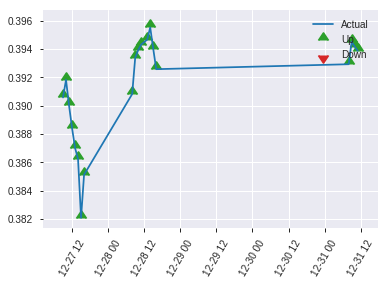


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2507703165995756
RMSE: 0.500769724124348
LogLoss: 0.6947334059094757
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 309.5705785684792
Residual deviance: 309.85109903562625
AIC: 2385.8510990356262
AUC: 0.5441225441225441
pr_auc: 0.4391096284476076
Gini: 0.08824508824508825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4021639766269723: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402164     0.58147   221
max f2                       0.402164     0.776451  221
max f0point5                 0.513913     0.488323  94
max accuracy                 0.5447       0.600897  35
max precision                0.599223     0.666667  2
max recall                   0.402164     1         221
max specificity              0.612704     0.992424  0
max absolute_mcc             0.517512     0.134582  82
max min_per_class_accuracy   0.510278     0.56044   107
max mean_per_class_accuracy  0.513913     0.567141  94

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.598823           1.6337    1.6337             0.666667         0.605496  0.666667                    0.605496            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.584038           0         0.98022            0                0.591095  0.4                         0.599736            0               0.021978                   -100      -1.97802
    3        0.0313901                   0.581551           1.22527   1.05024            0.5              0.582982  0.428571                    0.594949            0.010989        0.032967                   22.5275   5.02355
    4        0.0403587                   0.576849           0         0.81685            0                0.579457  0.333333                    0.591506            0               0.032967                   -100      -18.315
    5        0.0538117                   0.566879           1.6337    1.02106            0.666667         0.571708  0.416667                    0.586557            0.021978        0.0549451                  63.37     2.10623
    6        0.103139                    0.55582            0.891109  0.958911           0.363636         0.560069  0.391304                    0.573889            0.043956        0.0989011                  -10.8891  -4.10893
    7        0.152466                    0.54572            1.78222   1.22527            0.727273         0.549774  0.5                         0.566087            0.0879121       0.186813                   78.2218   22.5275
    8        0.201794                    0.538108           0.668332  1.08913            0.272727         0.541565  0.444444                    0.560093            0.032967        0.21978                    -33.1668  8.91331
    9        0.300448                    0.525136           1.33666   1.17041            0.545455         0.531645  0.477612                    0.550752            0.131868        0.351648                   33.6663   17.0412
    10       0.399103                    0.515132           1.11389   1.15644            0.454545         0.519474  0.47191                     0.54302             0.10989         0.461538                   11.3886   15.6439
    11       0.502242                    0.508947           0.958911  1.11588            0.391304         0.512139  0.455357                    0.536678            0.0989011       0.56044                    -4.10893  11.5875
    12       0.600897                    0.498714           1.0025    1.09726            0.409091         0.503639  0.447761                    0.531254            0.0989011       0.659341                   0.24975   9.72609
    13       0.699552                    0.486926           0.668332  1.03677            0.272727         0.492191  0.423077                    0.525745            0.0659341       0.725275                   -33.1668  3.67709
    14       0.798206                    0.471216           0.77972   1.005              0.318182         0.480085  0.410112                    0.520102            0.0769231       0.802198                   -22.028   0.500062
    15       0.896861                    0.456663           0.77972   0.98022            0.318182         0.463918  0.4                         0.513921            0.0769231       0.879121                   -22.028   -1.97802
    16       1                           0.386512           1.172     1                  0.478261         0.433575  0.408072                    0.505635       

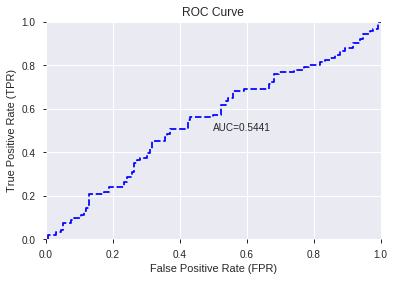

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


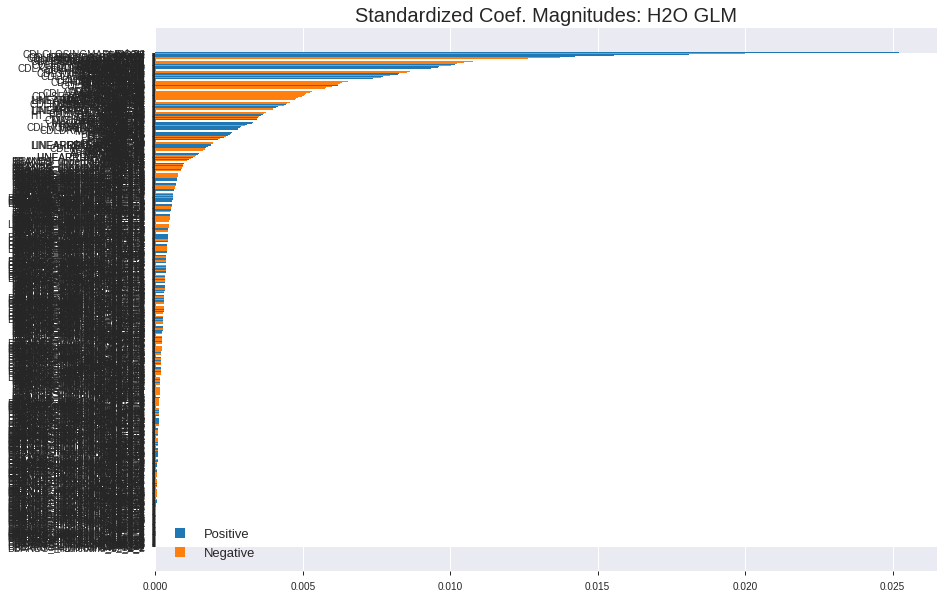

'log_likelihood'
--2019-08-27 16:39:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163859_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163859_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

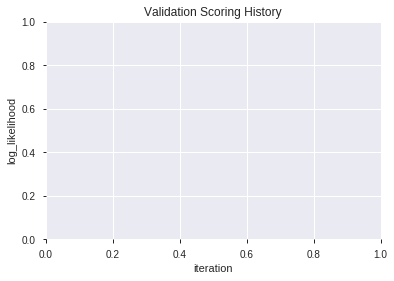

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_163953_model_2  0.507076  0.701901              0.488636  0.504245  0.254263
1  XGBoost_grid_1_AutoML_20190827_163953_model_4  0.498834  0.703575              0.500000  0.505019  0.255044
2  XGBoost_grid_1_AutoML_20190827_163953_model_5  0.493673  0.760585              0.492424  0.529736  0.280620
3  XGBoost_grid_1_AutoML_20190827_163953_model_6  0.489261  0.732288              0.474817  0.518165  0.268495
4               XGBoost_1_AutoML_20190827_163953  0.487512  0.717426              0.500000  0.511298  0.261426
5  XGBoost_grid_1_AutoML_20190827_163953_model_1  0.486097  0.725761              0.500000  0.515142  0.265371
6               XGBoost_2_AutoML_20190827_163953  0.478771  0.713049              0.500000  0.509039  0.259121
7               XGBoost_3_AutoML_20190827_163953  0.477356  0.715017              0.496212  0.510540  0.260651
8  XGBoost_grid_1_AutoML_20190827_163953_model_3  0.472694  0.712198              0.488636  0.509133  0.259217
9  XGBoost_grid_1_AutoML_20190827_163953_model_7  0.468032  0.735569              0.500000  0.519245  0.269615

variable  relative_importance  scaled_importance  percentage
0                        BOP           150.426239           1.000000    0.024878
1                   STDDEV_8           120.341698           0.800005    0.019903
2                       hour           110.142258           0.732201    0.018216
3               MACDEXT_hist            99.169762           0.659258    0.016401
4                      CCI_8            97.387566           0.647411    0.016107
..                       ...                  ...                ...         ...
308   BBANDS_lowerband_8_0_2             0.600158           0.003990    0.000099
309  BBANDS_lowerband_12_7_2             0.474082           0.003152    0.000078
310              MIDPRICE_12             0.394487           0.002622    0.000065
311   BBANDS_lowerband_8_1_4             0.365963           0.002433    0.000061
312  BBANDS_lowerband_12_0_3             0.193844           0.001289    0.000032

[313 rows x 4 columns]

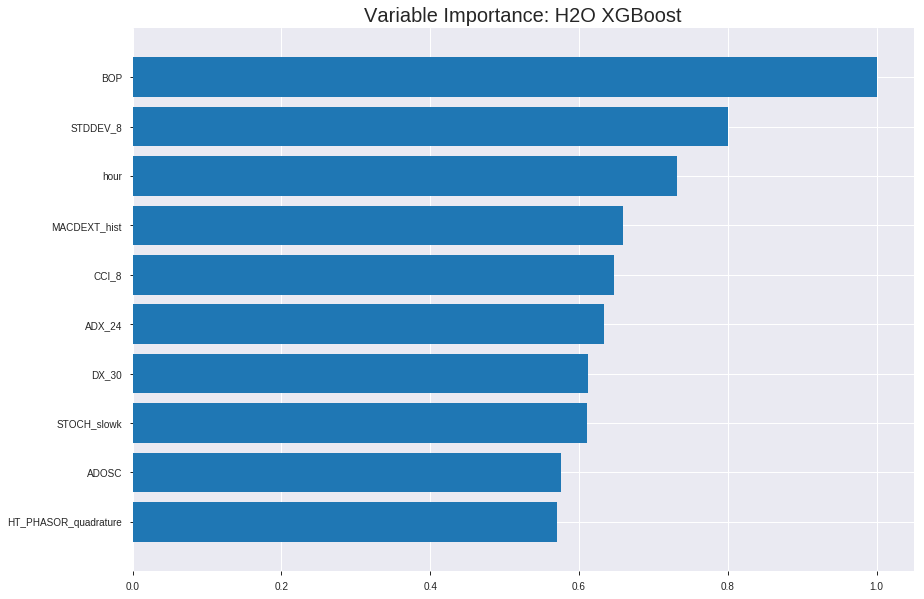

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_163953_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17575066915361606
RMSE: 0.41922627440752813
LogLoss: 0.5408996892015157
Mean Per-Class Error: 0.10462077205125042
AUC: 0.9611222345816339
pr_auc: 0.960336112804965
Gini: 0.9222444691632679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.501217782497406: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      694  81   0.1045   (81.0/775.0)
1      82   701  0.1047   (82.0/783.0)
Total  776  782  0.1046   (163.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501218     0.895847  207
max f2                       0.455345     0.924708  250
max f0point5                 0.526194     0.917603  183
max accuracy                 0.501218     0.895379  207
max precision                0.769975     1         0
max recall                   0.357229     1         343
max specificity              0.769975     1         0
max absolute_mcc             0.501218     0.790754  207
max min_per_class_accuracy   0.501218     0.895275  207
max mean_per_class_accuracy  0.501218     0.895379  207

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.732522           1.98978   1.98978            1                0.745271  1                           0.745271            0.0204342       0.0204342                  98.9783   98.9783
    2        0.0205392                   0.709313           1.98978   1.98978            1                0.720128  1                           0.7327              0.0204342       0.0408685                  98.9783   98.9783
    3        0.0301669                   0.694033           1.98978   1.98978            1                0.701894  1                           0.722868            0.0191571       0.0600255                  98.9783   98.9783
    4        0.0404365                   0.682433           1.98978   1.98978            1                0.687311  1                           0.713838            0.0204342       0.0804598                  98.9783   98.9783
    5        0.0500642                   0.672727           1.98978   1.98978            1                0.67739   1                           0.706829            0.0191571       0.0996169                  98.9783   98.9783
    6        0.100128                    0.646251           1.96427   1.97703            0.987179         0.659208  0.99359                     0.683018            0.0983397       0.197957                   96.4273   97.7028
    7        0.150193                    0.624259           1.93876   1.96427            0.974359         0.635148  0.987179                    0.667062            0.0970626       0.295019                   93.8763   96.4273
    8        0.200257                    0.607408           1.98978   1.97065            1                0.6161    0.990385                    0.654321            0.0996169       0.394636                   98.9783   97.065
    9        0.300385                    0.573771           1.92601   1.95577            0.967949         0.589938  0.982906                    0.63286             0.192848        0.587484                   92.6008   95.577
    10       0.399872                    0.534928           1.78439   1.91313            0.896774         0.556474  0.961477                    0.613855            0.177522        0.765006                   78.4386   91.313
    11       0.5                         0.501356           1.2755    1.78544            0.641026         0.518857  0.897304                    0.594831            0.127714        0.89272                    27.5502   78.5441
    12       0.600128                    0.462938           0.663261  1.59821            0.333333         0.481566  0.803209                    0.575934            0.0664112       0.959132                   -33.6739  59.8211
    13       0.699615                    0.427434           0.295258  1.41293            0.148387         0.445946  0.710092                    0.557449            0.0293742       0.988506                   -70.4742  41.2928
    14       0.799743                    0.39306            0.10204   1.2488             0.0512821        0.410827  0.627608                    0.539092            0.0102171       0.998723                   -89.796   24.8804
    15       0.899872                    0.355314           0.012755  1.11127            0.00641026       0.373229  0.558488                    0.520636            0.00127714      1                          -98.7245  11.127
    16       1                           0.275744           0         1                  0                0.329146  0.502567                    0.501463            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25246665420307807
RMSE: 0.5024605996524285
LogLoss: 0.6986690876746027
Mean Per-Class Error: 0.4358282307444409
AUC: 0.5414518208185627
pr_auc: 0.496042408458902
Gini: 0.08290364163712538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534581959247589: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      0    214  0        (0.0/214.0)
Total  2    444  0.5157   (230.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353458     0.650456  397
max f2                       0.353458     0.823077  397
max f0point5                 0.491868     0.554675  237
max accuracy                 0.500965     0.560538  219
max precision                0.537901     0.550633  143
max recall                   0.353458     1         397
max specificity              0.727225     0.99569   0
max absolute_mcc             0.491868     0.130246  237
max min_per_class_accuracy   0.506561     0.538793  200
max mean_per_class_accuracy  0.491868     0.564172  237

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.691612           0         0                  0                0.707858  0                           0.707858            0               0                          -100       -100
    2        0.0201794                   0.673881           1.04206   0.463136           0.5              0.686087  0.222222                    0.698182            0.00934579      0.00934579                 4.20561    -53.6864
    3        0.0313901                   0.662323           0.833645  0.595461           0.4              0.668372  0.285714                    0.687536            0.00934579      0.0186916                  -16.6355   -40.4539
    4        0.0403587                   0.651567           1.04206   0.694704           0.5              0.656777  0.333333                    0.6807              0.00934579      0.0280374                  4.20561    -30.5296
    5        0.0515695                   0.64389            1.66729   0.906136           0.8              0.648222  0.434783                    0.67364             0.0186916       0.046729                   66.729     -9.38643
    6        0.100897                    0.613316           1.13679   1.0189             0.545455         0.627041  0.488889                    0.650858            0.0560748       0.102804                   13.6788    1.88993
    7        0.150224                    0.596251           0.947324  0.995397           0.454545         0.60431   0.477612                    0.635574            0.046729        0.149533                   -5.26763   -0.460315
    8        0.201794                    0.58411            0.996749  0.995742           0.478261         0.588377  0.477778                    0.623512            0.0514019       0.200935                   -0.325071  -0.425753
    9        0.300448                    0.553857           1.32625   1.10427            0.636364         0.567584  0.529851                    0.605148            0.130841        0.331776                   32.6253    10.4268
    10       0.401345                    0.530145           1.20415   1.12938            0.577778         0.540632  0.541899                    0.588929            0.121495        0.453271                   20.4154    12.9379
    11       0.5                         0.506269           0.899958  1.08411            0.431818         0.517253  0.520179                    0.574786            0.088785        0.542056                   -10.0042   8.41121
    12       0.600897                    0.489562           1.15784   1.09649            0.555556         0.498954  0.526119                    0.562053            0.116822        0.658879                   15.784     9.64918
    13       0.699552                    0.471315           0.710493  1.04206            0.340909         0.48071   0.5                         0.550582            0.0700935       0.728972                   -28.9507   4.20561
    14       0.800448                    0.446917           0.787331  1.00995            0.377778         0.461104  0.484594                    0.539303            0.0794393       0.808411                   -21.2669   0.99479
    15       0.899103                    0.418914           0.947324  1.00308            0.454545         0.433825  0.481297                    0.527729            0.0934579       0.901869                   -5.26763   0.307642
    16       1                           0.30926            0.972586  1                  0.466667         0.395746  0.479821              


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:40:13  3.408 sec   0                  0.5              0.693147            0.5             0                  1                0.497433                         0.5                0.693147              0.5               0                    1                  0.520179
    2019-08-27 16:40:14  4.471 sec   5                  0.489627         0.672594            0.818468        0.814718           1.98978          0.261874                         0.499242           0.691632              0.540404          0.510526             1.25047            0.517937
    2019-08-27 16:40:14  4.707 sec   10                 0.480241         0.654299            0.868852        0.869695           1.98978          0.226573                         0.498997           0.691153              0.553084          0.498043             0.416822           0.517937
    2019-08-27 16:40:14  4.954 sec   15                 0.470406         0.635411            0.898841        0.898525           1.98978          0.175866                         0.498717           0.690607              0.55968           0.515066             0.416822           0.513453
    2019-08-27 16:40:14  5.206 sec   20                 0.462595         0.620582            0.915068        0.912356           1.98978          0.161104                         0.49969            0.692583              0.545047          0.506082             0.833645           0.520179
    2019-08-27 16:40:15  5.448 sec   25                 0.45446          0.605301            0.926784        0.927155           1.98978          0.156611                         0.499745           0.692736              0.547394          0.507083             0.416822           0.515695
    2019-08-27 16:40:15  5.695 sec   30                 0.446183         0.589907            0.936168        0.935898           1.98978          0.140565                         0.500536           0.69441               0.542439          0.5008               0                  0.517937
    2019-08-27 16:40:15  5.943 sec   35                 0.439898         0.578317            0.941909        0.942344           1.98978          0.138639                         0.501126           0.695704              0.542006          0.499377             0.416822           0.517937
    2019-08-27 16:40:15  6.197 sec   40                 0.433328         0.56629             0.948091        0.94831            1.98978          0.125802                         0.501638           0.69681               0.540153          0.498755             0.416822           0.517937
    2019-08-27 16:40:16  6.479 sec   45                 0.425934         0.552983            0.95723         0.955754           1.98978          0.114891                         0.502351           0.698299              0.534855          0.494011             0                  0.517937
    2019-08-27 16:40:16  6.736 sec   50                 0.419226         0.5409              0.961122        0.960336           1.98978          0.104621                         0.502461           0.698669              0.541452          0.496042             0                  0.515695

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      150.42623901367188     1.0                    0.024878393165278026
STDDEV_8                 120.3416976928711      0.8000046965339174     0.019902831374439732
hour                     110.14225769042969     0.7322011001047438     0.01821598684445491
MACDEXT_hist             99.16976165771484      0.6592584000501505     0.01640128967395979
CCI_8                    97.38756561279297      0.6474107592621634     0.016106539408355262
---                      ---                    ---                    ---
BBANDS_lowerband_8_0_2   0.6001583337783813     0.003989718400948882   9.925778299755064e-05
BBANDS_lowerband_12_7_2  0.47408199310302734    0.0031515910801967147  7.840652198931713e-05
MIDPRICE_12              0.39448702335357666    0.0026224615196137604  6.52426287457636e-05
BBANDS_lowerband_8_1_4   0.3659634590148926     0.0024328432420731537  6.052523068578557e-05
BBANDS_lowerband_12_0_3  0.1938435137271881     0.0012886283337149055  3.205900233007651e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.5852090032154341)

('auc', 0.507076257076257)

('logloss', 0.7019008132021172)

('mean_per_class_error', 0.45329670329670324)

('rmse', 0.5042449123667985)

('mse', 0.2542629316478002)

xgboost prediction progress: |████████████████████████████████████████████| 100%


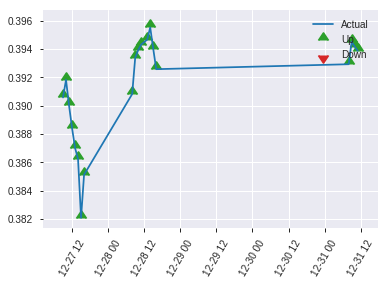


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2542629316478002
RMSE: 0.5042449123667985
LogLoss: 0.7019008132021172
Mean Per-Class Error: 0.45329670329670324
AUC: 0.507076257076257
pr_auc: 0.4128623858106506
Gini: 0.014152514152514062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39563116431236267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    129  0.9773   (129.0/132.0)
1      0    91   0        (0.0/91.0)
Total  3    220  0.5785   (129.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395631     0.585209  219
max f2                       0.395631     0.77911   219
max f0point5                 0.495901     0.472855  119
max accuracy                 0.651766     0.596413  0
max precision                0.651766     1         0
max recall                   0.395631     1         219
max specificity              0.651766     1         0
max absolute_mcc             0.436133     0.106867  186
max min_per_class_accuracy   0.499898     0.515152  110
max mean_per_class_accuracy  0.495901     0.546703  119

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.64024            0.81685   0.81685            0.333333         0.647292  0.333333                    0.647292            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.639241           1.22527   0.98022            0.5              0.639694  0.4                         0.644253            0.010989        0.021978                   22.5275   -1.97802
    3        0.0313901                   0.62947            1.22527   1.05024            0.5              0.635523  0.428571                    0.641758            0.010989        0.032967                   22.5275   5.02355
    4        0.0403587                   0.623612           1.22527   1.08913            0.5              0.628143  0.444444                    0.638733            0.010989        0.043956                   22.5275   8.91331
    5        0.0538117                   0.61575            1.6337    1.22527            0.666667         0.620438  0.5                         0.634159            0.021978        0.0659341                  63.37     22.5275
    6        0.103139                    0.599648           1.11389   1.172              0.454545         0.607211  0.478261                    0.621271            0.0549451       0.120879                   11.3886   17.2002
    7        0.152466                    0.582361           0.668332  1.00905            0.272727         0.591286  0.411765                    0.61157             0.032967        0.153846                   -33.1668  0.904977
    8        0.201794                    0.563183           1.33666   1.08913            0.545455         0.572187  0.444444                    0.601943            0.0659341       0.21978                    33.6663   8.91331
    9        0.300448                    0.545771           0.77972   0.987535           0.318182         0.553307  0.402985                    0.585973            0.0769231       0.296703                   -22.028   -1.24651
    10       0.399103                    0.520735           1.11389   1.01877            0.454545         0.530774  0.41573                     0.572328            0.10989         0.406593                   11.3886   1.87677
    11       0.502242                    0.499685           1.172     1.05024            0.478261         0.510148  0.428571                    0.559559            0.120879        0.527473                   17.2002   5.02355
    12       0.600897                    0.482152           1.0025    1.0424             0.409091         0.49148   0.425373                    0.548382            0.0989011       0.626374                   0.24975   4.23979
    13       0.699552                    0.458576           0.891109  1.02106            0.363636         0.469329  0.416667                    0.537234            0.0879121       0.714286                   -10.8891  2.10623
    14       0.798206                    0.444972           0.668332  0.977466           0.272727         0.451916  0.398876                    0.526689            0.0659341       0.78022                    -33.1668  -2.25336
    15       0.896861                    0.423411           1.0025    0.98022            0.409091         0.434295  0.4                         0.516525            0.0989011       0.879121                   0.24975   -1.97802
    16       1                           0.382033           1.172     1                  0.478261         0.40937   0.408072                    0.505473    

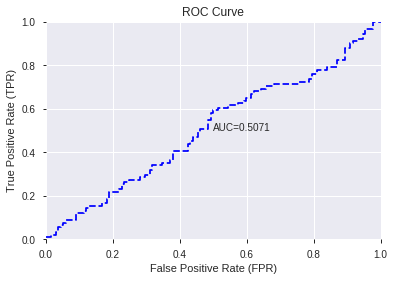

This function is available for GLM models only


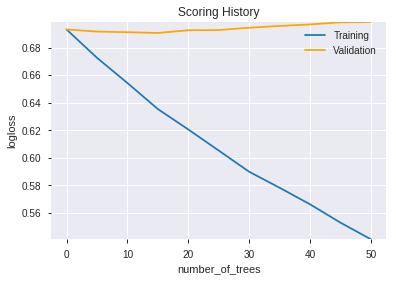

--2019-08-27 16:40:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_163953_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_163953_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_164055  0.552031  0.941370              0.478979  0.582716  0.339558
1  DeepLearning_grid_1_AutoML_20190827_164055_model_9  0.542374  0.680349              0.471404  0.493586  0.243627
2  DeepLearning_grid_1_AutoML_20190827_164055_model_6  0.540876  0.700464              0.486555  0.503595  0.253608
3  DeepLearning_grid_1_AutoML_20190827_164055_model_2  0.538711  1.367585              0.466492  0.603731  0.364491
4  DeepLearning_grid_1_AutoML_20190827_164055_model_3  0.530636  0.761911              0.488636  0.518782  0.269134
5  DeepLearning_grid_1_AutoML_20190827_164055_model_4  0.508658  0.721284              0.496212  0.509952  0.260051
6  DeepLearning_grid_1_AutoML_20190827_164055_model_8  0.507326  0.685322              0.500000  0.496075  0.246090
7  DeepLearning_grid_1_AutoML_20190827_164055_model_7  0.504745  0.812626              0.500000  0.548246  0.300574
8  DeepLearning_grid_1_AutoML_20190827_164055_model_1  0.499001  1.207550              0.500000  0.590123  0.348245
9  DeepLearning_grid_1_AutoML_20190827_164055_model_5  0.479104  0.692485              0.500000  0.499695  0.249695

variable  relative_importance  scaled_importance  percentage
0          CDLSTALLEDPATTERN             1.000000           1.000000    0.031301
1                  CDLINNECK             0.951284           0.951284    0.029777
2                      ATR_8             0.920377           0.920377    0.028809
3    BBANDS_lowerband_20_1_3             0.842403           0.842403    0.026368
4    BBANDS_middleband_8_8_2             0.793556           0.793556    0.024839
5               LINEARREG_30             0.778385           0.778385    0.024365
6    BBANDS_lowerband_14_1_2             0.770558           0.770558    0.024120
7                     CMO_24             0.753640           0.753640    0.023590
8     BBANDS_upperband_8_5_5             0.741075           0.741075    0.023197
9             CDLMORNINGSTAR             0.736425           0.736425    0.023051
10  BBANDS_middleband_24_2_2             0.729929           0.729929    0.022848
11                PLUS_DM_20             0.717349           0.717349    0.022454
12                 dayofweek             0.711942           0.711942    0.022285
13                   MA_14_4             0.710987           0.710987    0.022255
14  BBANDS_middleband_30_5_3             0.706368           0.706368    0.022110
15    BBANDS_lowerband_8_4_5             0.701456           0.701456    0.021957
16                 MAVP_30_2             0.688672           0.688672    0.021556
17                  CORREL_8             0.684593           0.684593    0.021429
18               MIDPRICE_20             0.678510           0.678510    0.021238
19   BBANDS_lowerband_30_7_5             0.670309           0.670309    0.020982
20                 STDDEV_12             0.666706           0.666706    0.020869
21   BBANDS_upperband_20_2_3             0.660387           0.660387    0.020671
22                    ADX_12             0.660339           0.660339    0.020670
23             MINMAX_min_12             0.658121           0.658121    0.020600
24  BBANDS_middleband_14_5_2             0.639471           0.639471    0.020016
25                       day             0.626292           0.626292    0.019604
26   BBANDS_lowerband_20_7_4             0.623302           0.623302    0.019510
27        CDLCLOSINGMARUBOZU             0.615953           0.615953    0.019280
28             days_in_month             0.605794           0.605794    0.018962
29  BBANDS_middleband_14_7_3             0.593269           0.593269    0.018570
30    BBANDS_upperband_8_2_4             0.582761           0.582761    0.018241
31                  WILLR_30             0.579717           0.579717    0.018146
32                PLUS_DM_14             0.575831           0.575831    0.018024
33   BBANDS_middleband_8_8_5             0.571918           0.571918    0.017902
34                     ROC_8             0.557234           0.557234    0.017442
35                aroonup_14             0.556671           0.556671    0.017425
36               CDLMARUBOZU             0.554859           0.554859    0.017368
37            MACDFIX_hist_8             0.545529           0.545529    0.017076
38   BBANDS_upperband_12_6_2             0.533737           0.533737    0.016707
39  BBANDS_middleband_14_4_4             0.528587           0.528587    0.016546
40                    ATR_30             0.523718           0.523718    0.016393
41                      hour             0.522850           0.522850    0.016366
42           MACDFIX_hist_14             0.520560           0.520560    0.016294
43                 MAVP_30_1             0.517800           0.517800    0.016208
44            CDLSPINNINGTOP             0.512401           0.512401    0.016039
45    BBANDS_upperband_8_8_4             0.511684           0.511684    0.016016
46           CDLADVANCEBLOCK             0.496008           0.496008    0.015526
47               STOCH_slowd             0.468848           0.468848    0.014676
48                       BOP             0.330112  

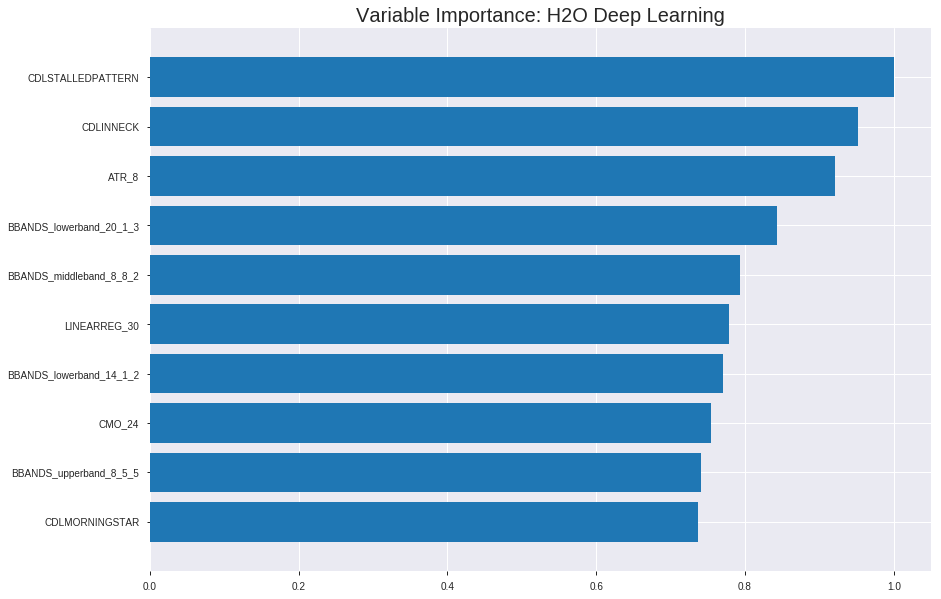

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_164055


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2511589996106575
RMSE: 0.5011576594352894
LogLoss: 0.6968361171772608
Mean Per-Class Error: 0.4377596506406295
AUC: 0.5815828286573559
pr_auc: 0.5887637655497703
Gini: 0.16316565731471178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15473469094208736: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   756   0.9755   (756.0/775.0)
1      3    780   0.0038   (3.0/783.0)
Total  22   1536  0.4872   (759.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.154735     0.672704  381
max f2                       0.154735     0.835476  381
max f0point5                 0.369818     0.579602  280
max accuracy                 0.403385     0.562901  254
max precision                0.998349     1         0
max recall                   0.0461703    1         396
max specificity              0.998349     1         0
max absolute_mcc             0.369818     0.134451  280
max min_per_class_accuracy   0.451167     0.537676  218
max mean_per_class_accuracy  0.403385     0.56224   254

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 47.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.848884           1.74106   1.74106            0.875            0.881701  0.875                       0.881701            0.0178799       0.0178799                  74.106     74.106
    2        0.0205392                   0.811138           1.49234   1.6167             0.75             0.827857  0.8125                      0.854779            0.0153257       0.0332056                  49.2337    61.6699
    3        0.0301669                   0.782698           1.45917   1.56642            0.733333         0.792118  0.787234                    0.834781            0.0140485       0.0472542                  45.9174    56.6425
    4        0.0404365                   0.766979           1.6167    1.57919            0.8125           0.775228  0.793651                    0.819656            0.0166028       0.063857                   61.6699    57.9193
    5        0.0500642                   0.751767           1.19387   1.50509            0.6              0.759018  0.75641                     0.807995            0.0114943       0.0753512                  19.387     50.5092
    6        0.100128                    0.692364           1.14795   1.32652            0.576923         0.721143  0.666667                    0.764569            0.0574713       0.132822                   14.7952    32.6522
    7        0.150193                    0.653767           1.17346   1.2755             0.589744         0.672892  0.641026                    0.73401             0.0587484       0.191571                   17.3462    27.5502
    8        0.200257                    0.616908           0.994891  1.20535            0.5              0.635626  0.605769                    0.709414            0.0498084       0.241379                   -0.510856  20.5349
    9        0.300385                    0.551138           1.0204    1.1437             0.512821         0.583266  0.574786                    0.667365            0.102171        0.34355                    2.04015    14.37
    10       0.399872                    0.499164           0.975635  1.10189            0.490323         0.522478  0.553772                    0.631317            0.0970626       0.440613                   -2.43645   10.1886
    11       0.5                         0.449495           0.982136  1.07791            0.49359          0.474093  0.54172                     0.599832            0.0983397       0.538953                   -1.78636   7.79055
    12       0.600128                    0.410673           1.17346   1.09385            0.589744         0.43056   0.549733                    0.57159             0.117497        0.65645                    17.3462    9.38486
    13       0.699615                    0.381033           0.962798  1.07521            0.483871         0.395335  0.540367                    0.546526            0.0957854       0.752235                   -3.72018   7.5213
    14       0.799743                    0.35147            0.892851  1.05238            0.448718         0.365857  0.528892                    0.523906            0.0893997       0.841635                   -10.7149   5.23812
    15       0.899872                    0.302976           0.880096  1.03321            0.442308         0.329009  0.519258                    0.50222             0.0881226       0.929757                   -11.9904   3.32111
    16       1                           2.58863e-09        0.701526  1                  0.352564         0.225971  0.502567                    0.47



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26578987622991385
RMSE: 0.515548131826616
LogLoss: 0.7366693226236257
Mean Per-Class Error: 0.42148727038349987
AUC: 0.5866298743151789
pr_auc: 0.5654093674344296
Gini: 0.17325974863035776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2505292851978747: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   220  0.9483   (220.0/232.0)
1      5    209  0.0234   (5.0/214.0)
Total  17   429  0.5045   (225.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250529     0.650078  382
max f2                       0.0449187    0.821813  399
max f0point5                 0.587283     0.562613  194
max accuracy                 0.587283     0.578475  194
max precision                0.971798     1         0
max recall                   0.0449187    1         399
max specificity              0.971798     1         0
max absolute_mcc             0.820979     0.182997  32
max min_per_class_accuracy   0.587283     0.577586  194
max mean_per_class_accuracy  0.587283     0.578513  194

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 58.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.87789            1.25047   1.25047            0.6              0.90649   0.6                         0.90649             0.0140187       0.0140187                  25.0467   25.0467
    2        0.0201794                   0.866647           1.04206   1.15784            0.5              0.873716  0.555556                    0.891923            0.00934579      0.0233645                  4.20561   15.784
    3        0.0313901                   0.855871           2.08411   1.48865            1                0.860717  0.714286                    0.880778            0.0233645       0.046729                   108.411   48.8652
    4        0.0403587                   0.844824           2.08411   1.62098            1                0.848926  0.777778                    0.8737              0.0186916       0.0654206                  108.411   62.0976
    5        0.0515695                   0.837922           2.08411   1.72166            1                0.841524  0.826087                    0.866705            0.0233645       0.088785                   108.411   72.1658
    6        0.100897                    0.81121            1.32625   1.52835            0.636364         0.823552  0.733333                    0.845608            0.0654206       0.154206                   32.6253   52.8349
    7        0.150224                    0.787843           0.852591  1.30646            0.409091         0.797462  0.626866                    0.829799            0.0420561       0.196262                   -14.7409  30.6458
    8        0.201794                    0.757183           0.815522  1.181              0.391304         0.772953  0.566667                    0.815272            0.0420561       0.238318                   -18.4478  18.0997
    9        0.300448                    0.686955           1.08942   1.15093            0.522727         0.721211  0.552239                    0.784386            0.107477        0.345794                   8.94223   15.0928
    10       0.401345                    0.630159           1.15784   1.15267            0.555556         0.662122  0.553073                    0.753649            0.116822        0.462617                   15.784    15.2665
    11       0.5                         0.586009           1.18415   1.15888            0.568182         0.605861  0.556054                    0.724489            0.116822        0.579439                   18.4155   15.8879
    12       0.600897                    0.542919           0.787331  1.09649            0.377778         0.564645  0.526119                    0.69765             0.0794393       0.658879                   -21.2669  9.64918
    13       0.699552                    0.496515           1.04206   1.08882            0.5              0.521664  0.522436                    0.672831            0.102804        0.761682                   4.20561   8.8815
    14       0.800448                    0.447422           0.833645  1.05665            0.4              0.4722    0.507003                    0.647542            0.0841121       0.845794                   -16.6355  5.66507
    15       0.899103                    0.389561           0.61576   1.00827            0.295455         0.416299  0.483791                    0.622168            0.0607477       0.906542                   -38.424   0.827371
    16       1                           0.0449187          0.926272  1                  0.444444         0.271463  0.479821                    0.586783          


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:40:55  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:40:55  0.071 sec   51933 obs/sec     1         1             1558       0.572783         0.964               -0.312355      0.526064        0.521174           0.746169         0.496791                         0.569006           0.953887              -0.297182        0.558462          0.524023             1.25047            0.520179
    2019-08-27 16:40:56  0.246 sec   82433 obs/sec     10        10            15580      0.501158         0.696836            -0.00466249    0.581583        0.588764           1.74106          0.487163                         0.515548           0.736669              -0.064894        0.58663           0.565409             1.25047            0.504484

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN        1.0                    1.0                  0.0313014182364631
CDLINNECK                0.951283872127533      0.951283872127533    0.029776534343065986
ATR_8                    0.9203774333000183     0.9203774333000183   0.02880911897512629
BBANDS_lowerband_20_1_3  0.8424031138420105     0.8424031138420105   0.026368412190067605
BBANDS_middleband_8_8_2  0.7935563921928406     0.7935563921928406   0.02483944052624684
---                      ---                    ---                  ---
BBANDS_upperband_8_8_4   0.511684238910675      0.511684238910675    0.016016442367149344
CDLADVANCEBLOCK          0.49600815773010254    0.49600815773010254  0.015525758793807494
STOCH_slowd              0.46884849667549133    0.46884849667549133  0.014675622883976532
BOP                      0.33011218905448914    0.33011218905448914  0.01033297969454894
MFI_12                   0.31915709376335144    0.31915709376335144  0.009990069675020731


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6098654708520179)

('F1', 0.5882352941176471)

('auc', 0.552031302031302)

('logloss', 0.9413698228666239)

('mean_per_class_error', 0.43152680652680653)

('rmse', 0.5827163496450241)

('mse', 0.3395583441436219)

deeplearning prediction progress: |███████████████████████████████████████| 100%


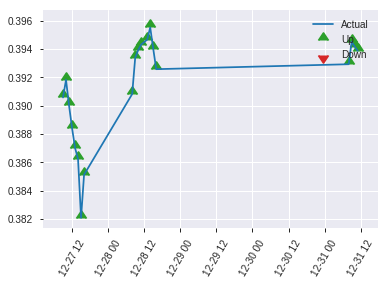


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3395583441436219
RMSE: 0.5827163496450241
LogLoss: 0.9413698228666239
Mean Per-Class Error: 0.43152680652680653
AUC: 0.552031302031302
pr_auc: 0.4511682890937522
Gini: 0.10406260406260404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09419369253276062: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    125  0.947    (125.0/132.0)
1      1    90   0.011    (1.0/91.0)
Total  8    215  0.565    (126.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0941937    0.588235  214
max f2                       0.0941937    0.777202  214
max f0point5                 0.738977     0.490982  101
max accuracy                 0.891665     0.609865  25
max precision                0.999839     1         0
max recall                   0.0429367    1         221
max specificity              0.999839     1         0
max absolute_mcc             0.738977     0.135103  101
max min_per_class_accuracy   0.724191     0.545455  109
max mean_per_class_accuracy  0.738977     0.568473  101

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 67.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.962027           1.6337    1.6337             0.666667         0.981225  0.666667                    0.981225            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.933541           0         0.98022            0                0.948137  0.4                         0.96799             0               0.021978                   -100      -1.97802
    3        0.0313901                   0.920874           1.22527   1.05024            0.5              0.924535  0.428571                    0.955574            0.010989        0.032967                   22.5275   5.02355
    4        0.0403587                   0.918417           0         0.81685            0                0.920504  0.333333                    0.947781            0               0.032967                   -100      -18.315
    5        0.0538117                   0.914598           1.6337    1.02106            0.666667         0.916479  0.416667                    0.939955            0.021978        0.0549451                  63.37     2.10623
    6        0.103139                    0.895803           1.55944   1.27855            0.636364         0.906322  0.521739                    0.92387             0.0769231       0.131868                   55.9441   27.8548
    7        0.152466                    0.878398           1.11389   1.22527            0.454545         0.88759   0.5                         0.912132            0.0549451       0.186813                   11.3886   22.5275
    8        0.201794                    0.860978           0.891109  1.14359            0.363636         0.868971  0.466667                    0.901582            0.043956        0.230769                   -10.8891  14.359
    9        0.300448                    0.807645           0.891109  1.06069            0.363636         0.834608  0.432836                    0.87959             0.0879121       0.318681                   -10.8891  6.06856
    10       0.399103                    0.761208           1.22527   1.10137            0.5              0.780615  0.449438                    0.855125            0.120879        0.43956                    22.5275   10.1371
    11       0.502242                    0.721959           1.06546   1.094              0.434783         0.741312  0.446429                    0.831752            0.10989         0.549451                   6.54563   9.39953
    12       0.600897                    0.66315            1.0025    1.07897            0.409091         0.698921  0.440299                    0.809944            0.0989011       0.648352                   0.24975   7.89733
    13       0.699552                    0.581433           1.0025    1.06819            0.409091         0.630698  0.435897                    0.784666            0.0989011       0.747253                   0.24975   6.81882
    14       0.798206                    0.515696           0.668332  1.01877            0.272727         0.551728  0.41573                     0.755876            0.0659341       0.813187                   -33.1668  1.87677
    15       0.896861                    0.426646           0.891109  1.00473            0.363636         0.476274  0.41                        0.72512             0.0879121       0.901099                   -10.8891  0.472527
    16       1                           0.0252668          0.958911  1                  0.391304         0.192506  0.408072                    0.670186          

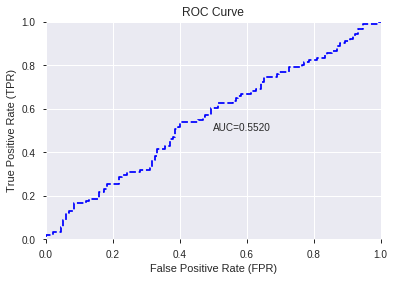

This function is available for GLM models only


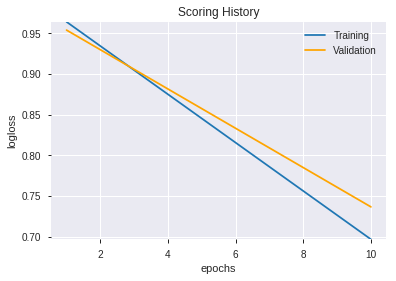

--2019-08-27 16:48:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.92
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.92|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_164055',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_164055',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_9fff'

['CDLSTALLEDPATTERN',
 'CDLINNECK',
 'ATR_8',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_middleband_8_8_2',
 'LINEARREG_30',
 'BBANDS_lowerband_14_1_2',
 'CMO_24',
 'BBANDS_upperband_8_5_5',
 'CDLMORNINGSTAR',
 'BBANDS_middleband_24_2_2',
 'PLUS_DM_20',
 'dayofweek',
 'MA_14_4',
 'BBANDS_middleband_30_5_3',
 'BBANDS_lowerband_8_4_5',
 'MAVP_30_2',
 'CORREL_8',
 'MIDPRICE_20',
 'BBANDS_lowerband_30_7_5',
 'STDDEV_12',
 'BBANDS_upperband_20_2_3',
 'ADX_12',
 'MINMAX_min_12',
 'BBANDS_middleband_14_5_2',
 'day',
 'BBANDS_lowerband_20_7_4',
 'CDLCLOSINGMARUBOZU',
 'days_in_month',
 'BBANDS_middleband_14_7_3',
 'BBANDS_upperband_8_2_4',
 'WILLR_30',
 'PLUS_DM_14',
 'BBANDS_middleband_8_8_5',
 'ROC_8',
 'aroonup_14',
 'CDLMARUBOZU',
 'MACDFIX_hist_8',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_14_4_4',
 'ATR_30',
 'hour',
 'MACDFIX_hist_14',
 'MAVP_30_1',
 'CDLSPINNINGTOP',
 'BBANDS_upperband_8_8_4',
 'CDLADVANCEBLOCK',
 'STOCH_slowd',
 'BOP',
 'MFI_12']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_164840_model_1  0.535298  0.69337              0.496212  0.500157  0.250157

variable  relative_importance  scaled_importance  percentage
0                       hour             0.082520           1.000000    0.111809
1         CDLCLOSINGMARUBOZU             0.065187           0.789950    0.088323
2                   CORREL_8             0.045624           0.552885    0.061817
3                     CMO_24             0.043096           0.522248    0.058392
4                      ATR_8             0.042357           0.513300    0.057392
5             CDLSPINNINGTOP             0.037971           0.460142    0.051448
6          CDLSTALLEDPATTERN             0.035243           0.427091    0.047753
7                 PLUS_DM_14             0.031335           0.379724    0.042457
8             MACDFIX_hist_8             0.031179           0.377840    0.042246
9              days_in_month             0.030791           0.373132    0.041720
10                    ADX_12             0.029290           0.354945    0.039686
11                 STDDEV_12             0.027194           0.329549    0.036846
12                 CDLINNECK             0.026939           0.326459    0.036501
13           MACDFIX_hist_14             0.022775           0.275991    0.030858
14                 dayofweek             0.019828           0.240286    0.026866
15                       BOP             0.019122           0.231722    0.025909
16                     ROC_8             0.015433           0.187020    0.020911
17                PLUS_DM_20             0.015043           0.182290    0.020382
18           CDLADVANCEBLOCK             0.014532           0.176100    0.019690
19                    MFI_12             0.013086           0.158582    0.017731
20   BBANDS_lowerband_30_7_5             0.010566           0.128042    0.014316
21            CDLMORNINGSTAR             0.009662           0.117087    0.013091
22               STOCH_slowd             0.009538           0.115580    0.012923
23    BBANDS_upperband_8_5_5             0.005340           0.064711    0.007235
24   BBANDS_lowerband_20_7_4             0.005271           0.063875    0.007142
25                    ATR_30             0.005159           0.062517    0.006990
26    BBANDS_lowerband_8_4_5             0.005066           0.061397    0.006865
27    BBANDS_upperband_8_2_4             0.004552           0.055162    0.006168
28   BBANDS_upperband_20_2_3             0.004283           0.051906    0.005804
29             MINMAX_min_12             0.004110           0.049805    0.005569
30    BBANDS_upperband_8_8_4             0.003802           0.046077    0.005152
31               CDLMARUBOZU             0.003418           0.041423    0.004631
32  BBANDS_middleband_30_5_3             0.003404           0.041250    0.004612
33                       day             0.003347           0.040562    0.004535
34              LINEARREG_30             0.002541           0.030794    0.003443
35   BBANDS_lowerband_20_1_3             0.001557           0.018869    0.002110
36   BBANDS_lowerband_14_1_2             0.001198           0.014520    0.001624
37  BBANDS_middleband_24_2_2             0.000997           0.012080    0.001351
38                aroonup_14             0.000897           0.010875    0.001216
39   BBANDS_middleband_8_8_2             0.000886           0.010738    0.001201
40                  WILLR_30             0.000850           0.010306    0.001152
41   BBANDS_middleband_8_8_5             0.000609           0.007385    0.000826
42                 MAVP_30_2             0.000582           0.007051    0.000788
43                   MA_14_4             0.000405           0.004907    0.000549
44  BBANDS_middleband_14_4_4             0.000364           0.004407    0.000493
45                 MAVP_30_1             0.000310           0.003758    0.000420
46  BBANDS_middleband_14_5_2             0.000269           0.003258    0.000364
47   BBANDS_upperband_12_6_2             0.000264           0.003202    0.000358
48               MIDPRICE_20             0.000181  

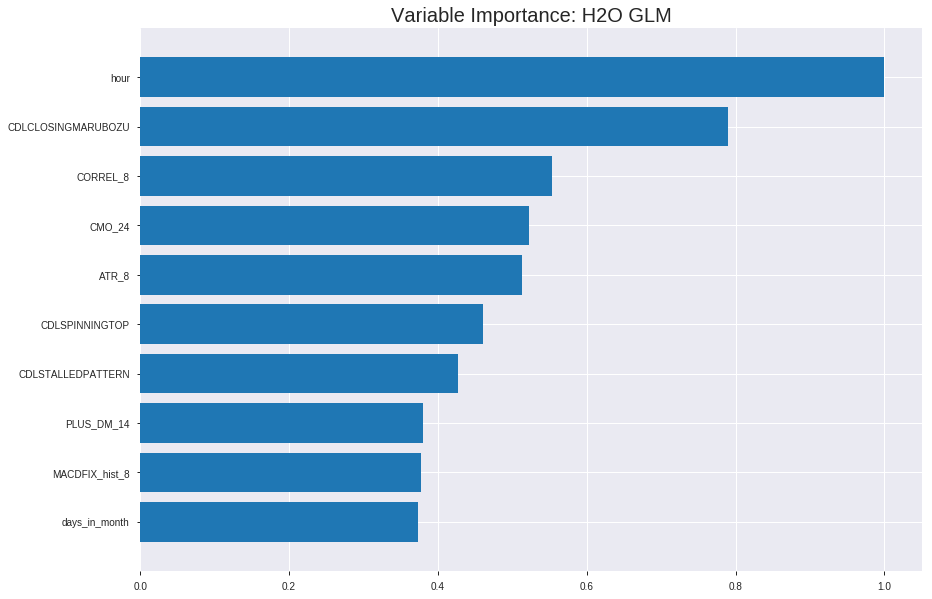

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_164840_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2452521307344029
RMSE: 0.49522937184137505
LogLoss: 0.683533343941153
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.805536138753
Residual deviance: 2129.8898997206325
AIC: 2231.8898997206325
AUC: 0.585525480987105
pr_auc: 0.5901636567799983
Gini: 0.17105096197421
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41560920713495647: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   751   0.969    (751.0/775.0)
1      6    777   0.0077   (6.0/783.0)
Total  30   1528  0.4859   (757.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415609     0.672436  380
max f2                       0.395007     0.835289  396
max f0point5                 0.491065     0.570728  231
max accuracy                 0.505919     0.567394  190
max precision                0.783371     1         0
max recall                   0.395007     1         396
max specificity              0.783371     1         0
max absolute_mcc             0.531567     0.150828  113
max min_per_class_accuracy   0.503697     0.566452  196
max mean_per_class_accuracy  0.505919     0.567528  190

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.585249           1.6167    1.6167             0.8125           0.616867  0.8125                      0.616867            0.0166028       0.0166028                  61.6699   61.6699
    2        0.0205392                   0.578828           1.24361   1.43016            0.625            0.58195   0.71875                     0.599409            0.0127714       0.0293742                  24.3614   43.0156
    3        0.0301669                   0.573179           1.45917   1.43942            0.733333         0.575692  0.723404                    0.59184             0.0140485       0.0434227                  45.9174   43.9417
    4        0.0404365                   0.566006           1.24361   1.38969            0.625            0.570284  0.698413                    0.586365            0.0127714       0.0561941                  24.3614   38.969
    5        0.0500642                   0.563163           1.45917   1.40305            0.733333         0.564587  0.705128                    0.582177            0.0140485       0.0702427                  45.9174   40.3052
    6        0.100128                    0.552611           1.40305   1.40305            0.705128         0.558054  0.705128                    0.570115            0.0702427       0.140485                   40.3052   40.3052
    7        0.150193                    0.544132           1.07142   1.29251            0.538462         0.547998  0.649573                    0.562743            0.0536398       0.194125                   7.14216   29.2509
    8        0.200257                    0.535613           1.2755    1.28826            0.641026         0.540099  0.647436                    0.557082            0.063857        0.257982                   27.5502   28.8257
    9        0.300385                    0.523436           0.931116  1.16921            0.467949         0.529149  0.587607                    0.547771            0.0932312       0.351213                   -6.88836  16.921
    10       0.399872                    0.51302            1.09117   1.14979            0.548387         0.518172  0.577849                    0.540407            0.108557        0.45977                    9.11713   14.9794
    11       0.5                         0.50353            1.05867   1.13155            0.532051         0.507969  0.568678                    0.533911            0.106003        0.565773                   5.86665   13.1545
    12       0.600128                    0.49372            0.905606  1.09385            0.455128         0.498356  0.549733                    0.527979            0.0906769       0.65645                    -9.43937  9.38486
    13       0.699615                    0.4826             0.821588  1.05513            0.412903         0.488325  0.530275                    0.52234             0.0817369       0.738186                   -17.8412  5.51326
    14       0.799743                    0.470537           0.931116  1.03961            0.467949         0.477335  0.522472                    0.516705            0.0932312       0.831418                   -6.88836  3.96057
    15       0.899872                    0.451456           0.956626  1.03037            0.480769         0.462092  0.517832                    0.510628            0.0957854       0.927203                   -4.33736  3.03726
    16       1                           0.245683           0.727036  1                  0.365385         0.430121  0.502567                    0.502567           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.247677684858402
RMSE: 0.49767226651522584
LogLoss: 0.6884996100124966
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.4838984721613
Residual deviance: 614.141652131147
AIC: 716.141652131147
AUC: 0.5628726232678053
pr_auc: 0.5179494154436188
Gini: 0.1257452465356106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4282341868367184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   222  0.9569   (222.0/232.0)
1      3    211  0.014    (3.0/214.0)
Total  13   433  0.5045   (225.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428234     0.652241  386
max f2                       0.39766      0.822444  398
max f0point5                 0.495536     0.555556  228
max accuracy                 0.495984     0.56278   226
max precision                0.555664     0.583333  32
max recall                   0.39766      1         398
max specificity              0.609894     0.99569   0
max absolute_mcc             0.495536     0.133381  228
max min_per_class_accuracy   0.50346      0.542056  196
max mean_per_class_accuracy  0.495536     0.565964  228

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.588288           0.833645  0.833645           0.4              0.596308  0.4                         0.596308            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.575181           1.04206   0.926272           0.5              0.58113   0.444444                    0.589563            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.569849           0.833645  0.893191           0.4              0.57291   0.428571                    0.583615            0.00934579      0.0280374                  -16.6355  -10.6809
    4        0.0403587                   0.564754           0.521028  0.810488           0.25             0.566959  0.388889                    0.579914            0.0046729       0.0327103                  -47.8972  -18.9512
    5        0.0515695                   0.561279           1.66729   0.996749           0.8              0.562869  0.478261                    0.576208            0.0186916       0.0514019                  66.729    -0.325071
    6        0.100897                    0.551488           1.32625   1.15784            0.636364         0.556342  0.555556                    0.566496            0.0654206       0.116822                   32.6253   15.784
    7        0.150224                    0.539324           1.04206   1.11982            0.5              0.543441  0.537313                    0.558926            0.0514019       0.168224                   4.20561   11.9821
    8        0.201794                    0.533208           1.08736   1.11153            0.521739         0.536317  0.533333                    0.553148            0.0560748       0.224299                   8.73629   11.1526
    9        0.300448                    0.52254            1.13679   1.11982            0.545455         0.527296  0.537313                    0.544659            0.11215         0.336449                   13.6788   11.9821
    10       0.401345                    0.514801           1.0189    1.09445            0.488889         0.518797  0.52514                     0.538158            0.102804        0.439252                   1.88993   9.445
    11       0.5                         0.503403           1.04206   1.08411            0.5              0.508955  0.520179                    0.532396            0.102804        0.542056                   4.20561   8.41121
    12       0.600897                    0.492991           1.20415   1.10427            0.577778         0.498485  0.529851                    0.526702            0.121495        0.663551                   20.4154   10.4268
    13       0.699552                    0.482264           0.852591  1.06878            0.409091         0.488184  0.512821                    0.52127             0.0841121       0.747664                   -14.7409  6.87755
    14       0.800448                    0.472411           0.787331  1.0333             0.377778         0.477255  0.495798                    0.515722            0.0794393       0.827103                   -21.2669  3.32993
    15       0.899103                    0.454323           0.899958  1.01867            0.431818         0.464327  0.488778                    0.510082            0.088785        0.915888                   -10.0042  1.86683
    16       1                           0.393654           0.833645  1                  0.4              0.435268  0.479821                    0.502534      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:48:40  0.000 sec   2            4         51            1.38304           1.3834
    2019-08-27 16:48:40  0.010 sec   4            2.5       51            1.38154           1.38229
    2019-08-27 16:48:40  0.020 sec   6            1.6       51            1.37954           1.38103
    2019-08-27 16:48:40  0.031 sec   8            0.96      51            1.37699           1.3797
    2019-08-27 16:48:40  0.042 sec   10           0.6       51            1.37394           1.37847
    2019-08-27 16:48:40  0.053 sec   12           0.37      51            1.37055           1.37751
    2019-08-27 16:48:40  0.063 sec   14           0.23      51            1.36707           1.377
    2019-08-27 16:48:40  0.075 sec   16           0.14      51            1.36377           1.37709
    2019-08-27 16:48:40  0.096 sec   18           0.089     51            1.36089           1.37779
    2019-08-27 16:48:40  0.116 sec   20           0.055     51            1.35853           1.37896
    2019-08-27 16:48:40  0.137 sec   22           0.034     51            1.35669           1.38039
    2019-08-27 16:48:40  0.156 sec   24           0.021     51            1.35529           1.38186

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6233183856502242)

('F1', 0.5814696485623003)

('auc', 0.5352980352980353)

('logloss', 0.6933701051997117)

('mean_per_class_error', 0.441017316017316)

('rmse', 0.5001566879511891)

('mse', 0.2501567125023031)

glm prediction progress: |████████████████████████████████████████████████| 100%


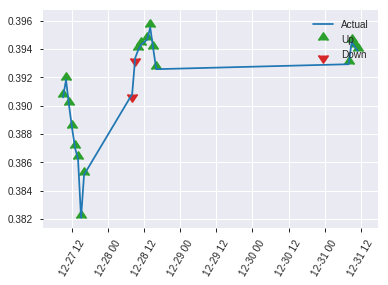


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501567125023031
RMSE: 0.5001566879511891
LogLoss: 0.6933701051997117
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.5705785684792
Residual deviance: 309.2430669190714
AIC: 411.2430669190714
AUC: 0.5352980352980353
pr_auc: 0.46191376848832255
Gini: 0.07059607059607065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40676592607959455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406766     0.58147   221
max f2                       0.406766     0.776451  221
max f0point5                 0.521294     0.474453  79
max accuracy                 0.56598      0.623318  12
max precision                0.730935     1         0
max recall                   0.406766     1         221
max specificity              0.730935     1         0
max absolute_mcc             0.56598      0.182834  12
max min_per_class_accuracy   0.512101     0.505495  104
max mean_per_class_accuracy  0.521294     0.558983  79

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.599932           1.6337    1.6337             0.666667         0.64565   0.666667                    0.64565             0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.578776           1.22527   1.47033            0.5              0.586443  0.6                         0.621967            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.57237            2.45055   1.75039            1                0.5733    0.714286                    0.608062            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.571822           1.22527   1.6337             0.5              0.572112  0.666667                    0.600073            0.010989        0.0659341                  22.5275   63.37
    5        0.0538117                   0.567129           2.45055   1.83791            1                0.569669  0.75                        0.592472            0.032967        0.0989011                  145.055   83.7912
    6        0.103139                    0.554686           0.891109  1.38509            0.363636         0.5602    0.565217                    0.577038            0.043956        0.142857                   -10.8891  38.5093
    7        0.152466                    0.545322           0.445554  1.08112            0.181818         0.549875  0.441176                    0.56825             0.021978        0.164835                   -55.4446  8.11248
    8        0.201794                    0.538733           1.33666   1.14359            0.545455         0.54176   0.466667                    0.561775            0.0659341       0.230769                   33.6663   14.359
    9        0.300448                    0.526294           0.891109  1.06069            0.363636         0.532035  0.432836                    0.552009            0.0879121       0.318681                   -10.8891  6.06856
    10       0.399103                    0.518091           1.33666   1.1289             0.545455         0.522113  0.460674                    0.544619            0.131868        0.450549                   33.6663   12.8905
    11       0.502242                    0.508336           0.532728  1.00648            0.217391         0.513807  0.410714                    0.538292            0.0549451       0.505495                   -46.7272  0.647567
    12       0.600897                    0.497255           1.0025    1.00582            0.409091         0.501876  0.410448                    0.532313            0.0989011       0.604396                   0.24975   0.582254
    13       0.699552                    0.486533           1.22527   1.03677            0.5              0.491744  0.423077                    0.526592            0.120879        0.725275                   22.5275   3.67709
    14       0.798206                    0.471282           0.668332  0.991233           0.272727         0.479196  0.404494                    0.520734            0.0659341       0.791209                   -33.1668  -0.876651
    15       0.896861                    0.454341           1.0025    0.992473           0.409091         0.463942  0.405                       0.514487            0.0989011       0.89011                    0.24975   -0.752747
    16       1                           0.39254            1.06546   1                  0.434783         0.432152  0.408072                    0.505995         

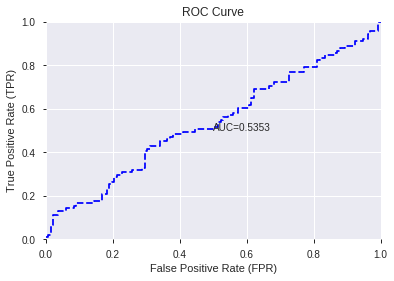

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


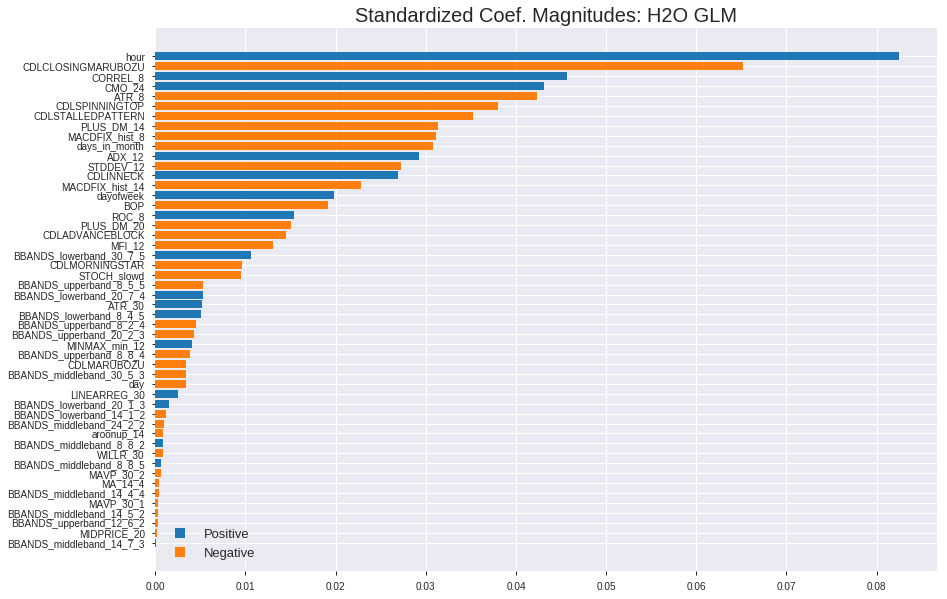

'log_likelihood'
--2019-08-27 16:48:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_164840_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_164840_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['hour',
 'CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'CMO_24',
 'ATR_8',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'PLUS_DM_14',
 'MACDFIX_hist_8',
 'days_in_month',
 'ADX_12',
 'STDDEV_12',
 'CDLINNECK',
 'MACDFIX_hist_14',
 'dayofweek',
 'BOP',
 'ROC_8',
 'PLUS_DM_20',
 'CDLADVANCEBLOCK',
 'MFI_12',
 'BBANDS_lowerband_30_7_5',
 'CDLMORNINGSTAR',
 'STOCH_slowd',
 'BBANDS_upperband_8_5_5',
 'BBANDS_lowerband_20_7_4',
 'ATR_30',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_upperband_8_2_4',
 'BBANDS_upperband_20_2_3',
 'MINMAX_min_12',
 'BBANDS_upperband_8_8_4',
 'CDLMARUBOZU',
 'BBANDS_middleband_30_5_3',
 'day',
 'LINEARREG_30',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_middleband_24_2_2',
 'aroonup_14',
 'BBANDS_middleband_8_8_2',
 'WILLR_30',
 'BBANDS_middleband_8_8_5',
 'MAVP_30_2',
 'MA_14_4',
 'BBANDS_middleband_14_4_4',
 'MAVP_30_1',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_12_6_2',
 'MIDPRICE_20',
 'BBANDS_middleband_14_7_3']

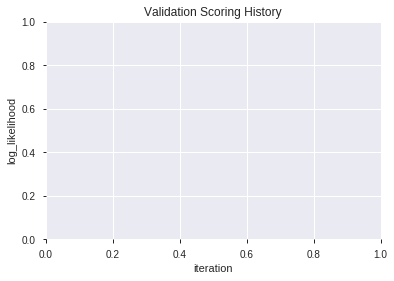

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_164851_model_5  0.555778  0.758419              0.488636  0.527622  0.278385
1  XGBoost_grid_1_AutoML_20190827_164851_model_1  0.545538  0.696609              0.496212  0.501357  0.251359
2               XGBoost_2_AutoML_20190827_164851  0.537629  0.692285              0.492424  0.499378  0.249378
3               XGBoost_1_AutoML_20190827_164851  0.528971  0.702286              0.500000  0.504227  0.254245
4  XGBoost_grid_1_AutoML_20190827_164851_model_4  0.525225  0.693863              0.496212  0.500272  0.250272
5               XGBoost_3_AutoML_20190827_164851  0.520813  0.703822              0.496212  0.505109  0.255135
6  XGBoost_grid_1_AutoML_20190827_164851_model_7  0.512071  0.695986              0.490343  0.500943  0.250944
7  XGBoost_grid_1_AutoML_20190827_164851_model_2  0.502747  0.700767              0.496212  0.503718  0.253731
8  XGBoost_grid_1_AutoML_20190827_164851_model_6  0.502581  0.717195              0.492424  0.511472  0.261604
9  XGBoost_grid_1_AutoML_20190827_164851_model_3  0.487429  0.708073              0.496212  0.507158  0.257209

variable  relative_importance  scaled_importance  percentage
0                     MFI_12          1299.844238           1.000000    0.060488
1                        BOP          1294.677124           0.996025    0.060248
2                STOCH_slowd          1014.979126           0.780847    0.047232
3                       hour           960.035217           0.738577    0.044675
4                   WILLR_30           902.916504           0.694634    0.042017
5             MACDFIX_hist_8           896.865234           0.689979    0.041736
6     BBANDS_upperband_8_2_4           857.658997           0.659817    0.039911
7                 PLUS_DM_14           852.391479           0.655764    0.039666
8            MACDFIX_hist_14           838.274292           0.644904    0.039009
9                      ATR_8           826.554565           0.635887    0.038464
10                    ATR_30           811.402527           0.624231    0.037759
11                    ADX_12           798.510620           0.614313    0.037159
12                    CMO_24           761.924133           0.586166    0.035456
13                     ROC_8           753.095886           0.579374    0.035045
14    BBANDS_lowerband_8_4_5           735.916077           0.566157    0.034246
15                PLUS_DM_20           701.871643           0.539966    0.032662
16                 STDDEV_12           696.687256           0.535977    0.032420
17                       day           611.200378           0.470210    0.028442
18                aroonup_14           486.349487           0.374160    0.022632
19   BBANDS_lowerband_30_7_5           440.240417           0.338687    0.020487
20   BBANDS_upperband_12_6_2           368.080841           0.283173    0.017129
21    BBANDS_upperband_8_5_5           364.373779           0.280321    0.016956
22   BBANDS_lowerband_20_7_4           351.992279           0.270796    0.016380
23   BBANDS_middleband_8_8_2           327.176025           0.251704    0.015225
24   BBANDS_lowerband_20_1_3           324.364899           0.249541    0.015094
25    BBANDS_upperband_8_8_4           318.448517           0.244990    0.014819
26                 dayofweek           273.250488           0.210218    0.012716
27   BBANDS_lowerband_14_1_2           256.886414           0.197629    0.011954
28   BBANDS_upperband_20_2_3           243.753448           0.187525    0.011343
29                   MA_14_4           241.071793           0.185462    0.011218
30            CDLSPINNINGTOP           224.501556           0.172714    0.010447
31  BBANDS_middleband_30_5_3           190.741440           0.146742    0.008876
32                  CORREL_8           181.391418           0.139549    0.008441
33                 MAVP_30_2           180.412308           0.138795    0.008396
34                 MAVP_30_1           178.654678           0.137443    0.008314
35  BBANDS_middleband_14_5_2           145.168320           0.111681    0.006755
36   BBANDS_middleband_8_8_5           119.772995           0.092144    0.005574
37             days_in_month           104.502098           0.080396    0.004863
38               MIDPRICE_20            99.222565           0.076334    0.004617
39              LINEARREG_30            97.718697           0.075177    0.004547
40        CDLCLOSINGMARUBOZU            92.743202           0.071349    0.004316
41  BBANDS_middleband_14_7_3            71.379364           0.054914    0.003322
42  BBANDS_middleband_24_2_2            56.665512           0.043594    0.002637
43  BBANDS_middleband_14_4_4            55.216297           0.042479    0.002569
44             MINMAX_min_12            46.147003           0.035502    0.002147
45               CDLMARUBOZU            28.722486           0.022097    0.001337
46           CDLADVANCEBLOCK             5.403780           0.004157    0.000251

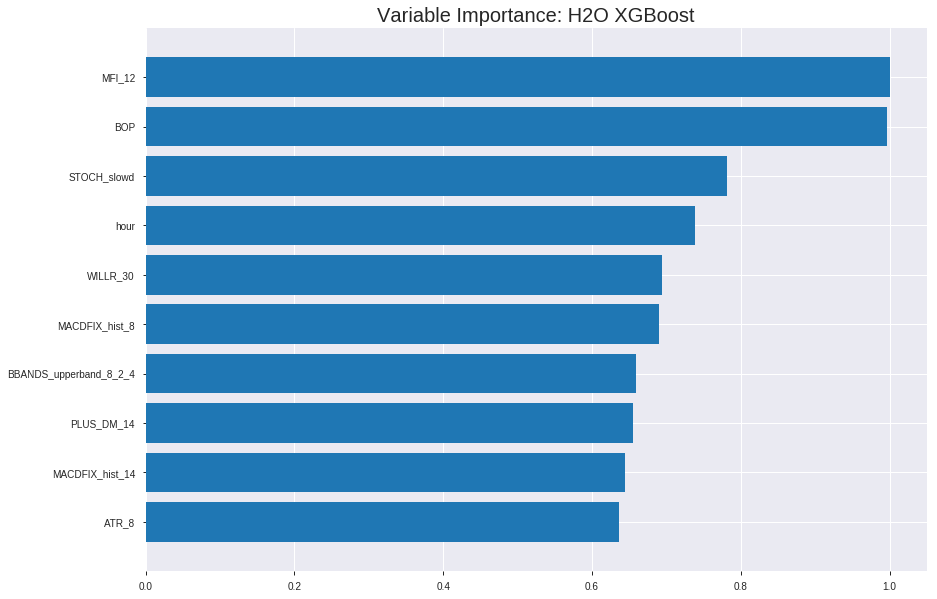

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_164851_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06090261106413132
RMSE: 0.24678454381125922
LogLoss: 0.27438323969757733
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987228607918264
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.513517439365387: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      775  0    0        (0.0/775.0)
1      0    783  0        (0.0/783.0)
Total  775  783  0        (0.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.513517     1        201
max f2                       0.513517     1        201
max f0point5                 0.513517     1        201
max accuracy                 0.513517     1        201
max precision                0.927702     1        0
max recall                   0.513517     1        201
max specificity              0.927702     1        0
max absolute_mcc             0.513517     1        201
max min_per_class_accuracy   0.513517     1        201
max mean_per_class_accuracy  0.513517     1        201

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102696                   0.887208           1.98978    1.98978            1                0.90359   1                           0.90359             0.0204342       0.0204342                  98.9783  98.9783
    2        0.0205392                   0.875225           1.98978    1.98978            1                0.880471  1                           0.892031            0.0204342       0.0408685                  98.9783  98.9783
    3        0.0301669                   0.871767           1.98978    1.98978            1                0.873445  1                           0.886099            0.0191571       0.0600255                  98.9783  98.9783
    4        0.0404365                   0.861244           1.98978    1.98978            1                0.866351  1                           0.881084            0.0204342       0.0804598                  98.9783  98.9783
    5        0.0500642                   0.853762           1.98978    1.98978            1                0.857771  1                           0.876601            0.0191571       0.0996169                  98.9783  98.9783
    6        0.100128                    0.825616           1.98978    1.98978            1                0.840059  1                           0.85833             0.0996169       0.199234                   98.9783  98.9783
    7        0.150193                    0.804248           1.98978    1.98978            1                0.814098  1                           0.843586            0.0996169       0.298851                   98.9783  98.9783
    8        0.200257                    0.786702           1.98978    1.98978            1                0.795473  1                           0.831558            0.0996169       0.398467                   98.9783  98.9783
    9        0.300385                    0.752874           1.98978    1.98978            1                0.769791  1                           0.810969            0.199234        0.597701                   98.9783  98.9783
    10       0.399872                    0.711917           1.98978    1.98978            1                0.733254  1                           0.791634            0.197957        0.795658                   98.9783  98.9783
    11       0.5                         0.535517           1.98978    1.98978            1                0.668606  1                           0.766997            0.199234        0.994891                   98.9783  98.9783
    12       0.600128                    0.292867           0.0510201  1.66631            0.025641         0.351728  0.837433                    0.697711            0.00510856      1                          -94.898  66.631
    13       0.699615                    0.251311           0          1.42936            0                0.27034   0.718349                    0.636938            0               1                          -100     42.9358
    14       0.799743                    0.216039           0          1.2504             0                0.232704  0.628411                    0.586328            0               1                          -100     25.0401
    15       0.899872                    0.176703           0          1.11127            0                0.198314  0.558488                    0.543154            0               1                          -100     11.127
    16       1                           0.0904343          0          1                  0                0.14896   0.502567                    0.503684          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26232327351449086
RMSE: 0.5121750418699557
LogLoss: 0.7205671855277246
Mean Per-Class Error: 0.4673501450209474
AUC: 0.5162846438930068
pr_auc: 0.49327659752556735
Gini: 0.032569287786013534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1995362788438797: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    214  0        (0.0/214.0)
Total  0    446  0.5202   (232.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.199536     0.648485   399
max f2                       0.199536     0.821813   399
max f0point5                 0.393133     0.545877   333
max accuracy                 0.562432     0.538117   145
max precision                0.781852     0.666667   5
max recall                   0.199536     1          399
max specificity              0.826651     0.99569    0
max absolute_mcc             0.393133     0.0882091  333
max min_per_class_accuracy   0.510979     0.517241   200
max mean_per_class_accuracy  0.562432     0.53265    145

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.783828           1.25047   1.25047            0.6              0.801243  0.6                         0.801243            0.0140187       0.0140187                  25.0467    25.0467
    2        0.0201794                   0.76263            1.56308   1.38941            0.75             0.772811  0.666667                    0.788607            0.0140187       0.0280374                  56.3084    38.9408
    3        0.0313901                   0.754878           0.416822  1.04206            0.2              0.758363  0.5                         0.777805            0.0046729       0.0327103                  -58.3178   4.20561
    4        0.0403587                   0.74946            1.04206   1.04206            0.5              0.75156   0.5                         0.771973            0.00934579      0.0420561                  4.20561    4.20561
    5        0.0515695                   0.738913           1.25047   1.08736            0.6              0.744662  0.521739                    0.766036            0.0140187       0.0560748                  25.0467    8.73629
    6        0.100897                    0.68047            0.947324  1.0189             0.454545         0.710506  0.488889                    0.738888            0.046729        0.102804                   -5.26763   1.88993
    7        0.150224                    0.652222           1.13679   1.05761            0.545455         0.666459  0.507463                    0.715105            0.0560748       0.158879                   13.6788    5.76092
    8        0.201794                    0.624117           0.996749  1.04206            0.478261         0.636424  0.5                         0.694998            0.0514019       0.21028                    -0.325071  4.20561
    9        0.300448                    0.588068           0.99469   1.0265             0.477273         0.605232  0.492537                    0.665523            0.0981308       0.308411                   -0.531011  2.6503
    10       0.401345                    0.549374           1.0189    1.02459            0.488889         0.566546  0.49162                     0.64064             0.102804        0.411215                   1.88993    2.45914
    11       0.5                         0.510339           1.08942   1.03738            0.522727         0.528317  0.497758                    0.618478            0.107477        0.518692                   8.94223    3.73832
    12       0.600897                    0.477769           0.64839   0.972067           0.311111         0.491722  0.466418                    0.597194            0.0654206       0.584112                   -35.161    -2.79328
    13       0.699552                    0.452374           1.27889   1.01534            0.613636         0.465567  0.487179                    0.578631            0.126168        0.71028                    27.8887    1.53367
    14       0.800448                    0.413288           1.11153   1.02746            0.533333         0.431301  0.492997                    0.56006             0.11215         0.82243                    11.1526    2.74615
    15       0.899103                    0.364483           0.947324  1.01867            0.454545         0.389442  0.488778                    0.541339            0.0934579       0.915888                   -5.26763   1.86683
    16       1                           0.199536           0.833645  1                  0.4              0.322901  0.479821                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:48:59  3.240 sec   0                  0.5              0.693147            0.5             0                  1                0.497433                         0.5                0.693147              0.5               0                    1                  0.520179
    2019-08-27 16:48:59  3.574 sec   5                  0.456471         0.6093              0.950632        0.949879           1.98978          0.120668                         0.49886            0.690904              0.541563          0.52112              2.08411            0.517937
    2019-08-27 16:49:00  3.887 sec   10                 0.41566          0.535912            0.989433        0.987226           1.98978          0.0449294                        0.498186           0.689689              0.562319          0.510194             0.416822           0.520179
    2019-08-27 16:49:00  4.182 sec   15                 0.389812         0.491632            0.995483        0.9942             1.98978          0.0288832                        0.502735           0.698944              0.524593          0.499844             1.25047            0.520179
    2019-08-27 16:49:00  4.492 sec   20                 0.358286         0.439961            0.998912        0.997643           1.98978          0.0173299                        0.504455           0.702749              0.532761          0.504753             1.25047            0.515695
    2019-08-27 16:49:01  4.850 sec   25                 0.32518          0.388391            0.999812        0.99854            1.98978          0.00577664                       0.506836           0.707807              0.523123          0.500282             1.25047            0.517937
    2019-08-27 16:49:01  5.195 sec   30                 0.298946         0.348954            0.999953        0.997399           1.98978          0.00385109                       0.511329           0.717443              0.509376          0.500932             1.66729            0.515695
    2019-08-27 16:49:01  5.511 sec   35                 0.279391         0.320428            0.999983        0.998706           1.98978          0.000641849                      0.51348            0.72265               0.510907          0.495898             1.25047            0.515695
    2019-08-27 16:49:02  5.875 sec   40                 0.258506         0.290917            0.999997        0.99872            1.98978          0.000641849                      0.514345           0.725073              0.515459          0.49769              1.66729            0.511211
    2019-08-27 16:49:02  6.250 sec   45                 0.262082         0.294925            0.999981        0.998704           1.98978          0.00192555                       0.516055           0.729491              0.511229          0.491311             1.25047            0.515695
    2019-08-27 16:49:02  6.678 sec   50                 0.246785         0.274383            1               0.998723           1.98978          0                                0.512175           0.720567              0.516285          0.493277             1.25047            0.520179

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
MFI_12                    1299.84423828125       1.0                   0.06048837624164804
BOP                       1294.6771240234375     0.996024820431835     0.06024792408430077
STOCH_slowd               1014.9791259765625     0.7808467323120521    0.047232150931152836
hour                      960.0352172851562      0.7385771225593811    0.04467533087284564
WILLR_30                  902.91650390625        0.6946343856554327    0.04201730606991186
---                       ---                    ---                   ---
BBANDS_middleband_24_2_2  56.66551208496094      0.04359407874891861   0.002636935037272622
BBANDS_middleband_14_4_4  55.2162971496582       0.04247916444409468   0.0025694956813252364
MINMAX_min_12             46.147003173828125     0.03550194847564744   0.002147455216706565
CDLMARUBOZU               28.72248649597168      0.022096867955464165  0.0013366036626521324
CDLADVANCEBLOCK           5.403779983520508      0.00415725194171402   0.0002514654195817195


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6053811659192825)

('F1', 0.5852090032154341)

('auc', 0.5557775557775557)

('logloss', 0.7584188032741153)

('mean_per_class_error', 0.41903929403929396)

('rmse', 0.5276219566974448)

('mse', 0.2783849291892403)

xgboost prediction progress: |████████████████████████████████████████████| 100%


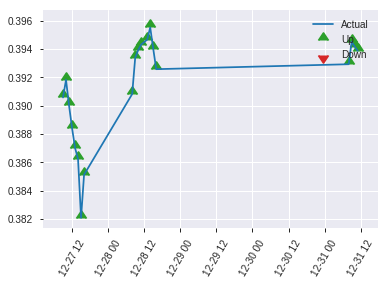


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2783849291892403
RMSE: 0.5276219566974448
LogLoss: 0.7584188032741153
Mean Per-Class Error: 0.41903929403929396
AUC: 0.5557775557775557
pr_auc: 0.44474041144403675
Gini: 0.11155511155511144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30400246381759644: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    129  0.9773   (129.0/132.0)
1      0    91   0        (0.0/91.0)
Total  3    220  0.5785   (129.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304002     0.585209  219
max f2                       0.304002     0.77911   219
max f0point5                 0.634984     0.503513  83
max accuracy                 0.685284     0.605381  46
max precision                0.685284     0.531915  46
max recall                   0.304002     1         219
max specificity              0.877314     0.992424  0
max absolute_mcc             0.634984     0.164235  83
max min_per_class_accuracy   0.607274     0.56044   108
max mean_per_class_accuracy  0.634984     0.580961  83

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 58.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.828395           0.81685   0.81685            0.333333         0.850822  0.333333                    0.850822            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.824242           1.22527   0.98022            0.5              0.824651  0.4                         0.840354            0.010989        0.021978                   22.5275   -1.97802
    3        0.0313901                   0.815883           0         0.700157           0                0.820442  0.285714                    0.834664            0               0.021978                   -100      -29.9843
    4        0.0403587                   0.80421            2.45055   1.08913            1                0.811413  0.444444                    0.829497            0.021978        0.043956                   145.055   8.91331
    5        0.0538117                   0.794742           0.81685   1.02106            0.333333         0.799812  0.416667                    0.822076            0.010989        0.0549451                  -18.315   2.10623
    6        0.103139                    0.754997           1.33666   1.172              0.545455         0.771363  0.478261                    0.797822            0.0659341       0.120879                   33.6663   17.2002
    7        0.152466                    0.719813           0.891109  1.08112            0.363636         0.738883  0.441176                    0.778753            0.043956        0.164835                   -10.8891  8.11248
    8        0.201794                    0.686859           1.78222   1.2525             0.727273         0.700793  0.511111                    0.759696            0.0879121       0.252747                   78.2218   25.2503
    9        0.300448                    0.657968           0.891109  1.13384            0.363636         0.674635  0.462687                    0.731766            0.0879121       0.340659                   -10.8891  13.3836
    10       0.399103                    0.627165           1.33666   1.18397            0.545455         0.640855  0.483146                    0.709293            0.131868        0.472527                   33.6663   18.3973
    11       0.502242                    0.605305           0.958911  1.13776            0.391304         0.616362  0.464286                    0.690209            0.0989011       0.571429                   -4.10893  13.7755
    12       0.600897                    0.55053            0.668332  1.06069            0.272727         0.574488  0.432836                    0.67121             0.0659341       0.637363                   -33.1668  6.06856
    13       0.699552                    0.500964           1.0025    1.05248            0.409091         0.525083  0.429487                    0.650602            0.0989011       0.736264                   0.24975   5.24796
    14       0.798206                    0.455373           0.668332  1.005              0.272727         0.477054  0.410112                    0.629153            0.0659341       0.802198                   -33.1668  0.500062
    15       0.896861                    0.404715           0.891109  0.992473           0.363636         0.433872  0.405                       0.607672            0.0879121       0.89011                    -10.8891  -0.752747
    16       1                           0.286691           1.06546   1                  0.434783         0.351332  0.408072                    0.581233    

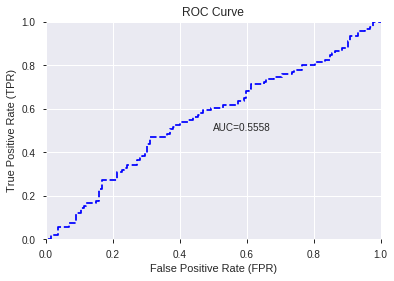

This function is available for GLM models only


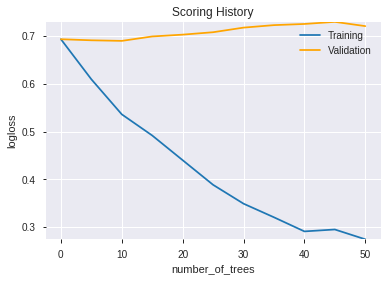

--2019-08-27 16:49:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.112
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.112|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_164851_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_164851_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MFI_12',
 'BOP',
 'STOCH_slowd',
 'hour',
 'WILLR_30',
 'MACDFIX_hist_8',
 'BBANDS_upperband_8_2_4',
 'PLUS_DM_14',
 'MACDFIX_hist_14',
 'ATR_8',
 'ATR_30',
 'ADX_12',
 'CMO_24',
 'ROC_8',
 'BBANDS_lowerband_8_4_5',
 'PLUS_DM_20',
 'STDDEV_12',
 'day',
 'aroonup_14',
 'BBANDS_lowerband_30_7_5',
 'BBANDS_upperband_12_6_2',
 'BBANDS_upperband_8_5_5',
 'BBANDS_lowerband_20_7_4',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_upperband_8_8_4',
 'dayofweek',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_20_2_3',
 'MA_14_4',
 'CDLSPINNINGTOP',
 'BBANDS_middleband_30_5_3',
 'CORREL_8',
 'MAVP_30_2',
 'MAVP_30_1',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_8_8_5',
 'days_in_month',
 'MIDPRICE_20',
 'LINEARREG_30',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_middleband_14_7_3',
 'BBANDS_middleband_24_2_2',
 'BBANDS_middleband_14_4_4',
 'MINMAX_min_12',
 'CDLMARUBOZU',
 'CDLADVANCEBLOCK']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 13] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_164917_model_3  0.528472  0.724402              0.496212  0.514859  0.265079
1  DeepLearning_grid_1_AutoML_20190827_164917_model_2  0.525808  0.889921              0.484848  0.553039  0.305852
2  DeepLearning_grid_1_AutoML_20190827_164917_model_4  0.524143  0.853430              0.488636  0.548543  0.300900
3  DeepLearning_grid_1_AutoML_20190827_164917_model_1  0.514735  5.051449              0.474442  0.746491  0.557249
4  DeepLearning_grid_1_AutoML_20190827_164917_model_5  0.500000  0.686649              0.500000  0.496742  0.246752
5  DeepLearning_grid_1_AutoML_20190827_164917_model_9  0.500000  0.686876              0.500000  0.496856  0.246866
6  DeepLearning_grid_1_AutoML_20190827_164917_model_7  0.500000  0.693450              0.500000  0.500151  0.250151
7  DeepLearning_grid_1_AutoML_20190827_164917_model_6  0.500000  0.687084              0.500000  0.496961  0.246970
8  DeepLearning_grid_1_AutoML_20190827_164917_model_8  0.500000  0.683829              0.500000  0.495324  0.245346
9               DeepLearning_1_AutoML_20190827_164917  0.477522  0.803812              0.474817  0.544755  0.296758

variable  relative_importance  scaled_importance  percentage
0             CDLADVANCEBLOCK             1.000000           1.000000    0.003183
1              CDLEVENINGSTAR             0.993939           0.993939    0.003163
2              CDLMORNINGSTAR             0.903379           0.903379    0.002875
3             CDLSHOOTINGSTAR             0.902827           0.902827    0.002873
4                CDLTHRUSTING             0.896609           0.896609    0.002854
...                       ...                  ...                ...         ...
1032  BBANDS_lowerband_24_1_3             0.242266           0.242266    0.000771
1033                MAVP_24_0             0.241930           0.241930    0.000770
1034             CDLENGULFING             0.240354           0.240354    0.000765
1035               MACDFIX_12             0.229966           0.229966    0.000732
1036       CDLSEPARATINGLINES             0.213015           0.213015    0.000678

[1037 rows x 4 columns]

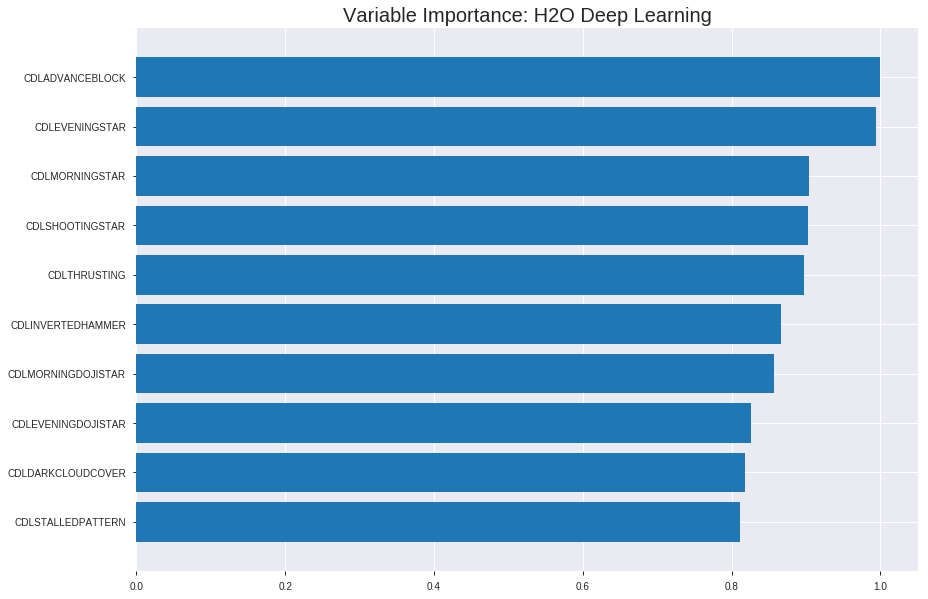

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_164917_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2944207766038305
RMSE: 0.5426055442066828
LogLoss: 0.8665280360201291
Mean Per-Class Error: 0.4266938573723891
AUC: 0.5696749474725004
pr_auc: 0.5460725822615076
Gini: 0.13934989494500072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42233212695014977: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      66   709   0.9148   (709.0/775.0)
1      26   757   0.0332   (26.0/783.0)
Total  92   1466  0.4718   (735.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422332     0.673188  346
max f2                       0.150434     0.835824  394
max f0point5                 0.509319     0.58961   287
max accuracy                 0.52173      0.574454  277
max precision                0.990387     0.75      0
max recall                   0.150434     1         394
max specificity              0.990387     0.99871   0
max absolute_mcc             0.509319     0.168329  287
max min_per_class_accuracy   0.638198     0.53129   202
max mean_per_class_accuracy  0.52173      0.573306  277

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 67.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.982936           1.24361   1.24361            0.625            0.987305  0.625                       0.987305            0.0127714       0.0127714                  24.3614   24.3614
    2        0.0205392                   0.980453           1.24361   1.24361            0.625            0.981618  0.625                       0.984462            0.0127714       0.0255428                  24.3614   24.3614
    3        0.0301669                   0.974548           0.795913  1.10073            0.4              0.977773  0.553191                    0.982327            0.00766284      0.0332056                  -20.4087  10.0731
    4        0.0404365                   0.968364           1.36798   1.1686             0.6875           0.971631  0.587302                    0.97961             0.0140485       0.0472542                  36.7976   16.8603
    5        0.0500642                   0.963536           1.06122   1.14795            0.533333         0.966109  0.576923                    0.977014            0.0102171       0.0574713                  6.12175   14.7952
    6        0.100128                    0.941179           1.0204    1.08418            0.512821         0.953524  0.544872                    0.965269            0.0510856       0.108557                   2.04015   8.41766
    7        0.150193                    0.917205           1.12244   1.09693            0.564103         0.930762  0.551282                    0.953767            0.0561941       0.164751                   12.2442   9.69316
    8        0.200257                    0.884619           1.24999   1.1352             0.628205         0.899466  0.570513                    0.940192            0.0625798       0.227331                   24.9992   13.5197
    9        0.300385                    0.821191           1.07142   1.11394            0.538462         0.854899  0.559829                    0.911761            0.10728         0.33461                    7.14216   11.3938
    10       0.399872                    0.732844           1.00131   1.08592            0.503226         0.776352  0.545746                    0.878071            0.0996169       0.434227                   0.13101   8.59168
    11       0.5                         0.637405           0.969381  1.06258            0.487179         0.692098  0.534018                    0.840829            0.0970626       0.53129                    -3.06186  6.25798
    12       0.600128                    0.566592           1.19897   1.08534            0.602564         0.593864  0.545455                    0.799624            0.120051        0.651341                   19.8972   8.53361
    13       0.699615                    0.52879            1.14252   1.09347            0.574194         0.545218  0.549541                    0.763447            0.113665        0.765006                   14.252    9.34678
    14       0.799743                    0.498691           0.905606  1.06995            0.455128         0.513633  0.537721                    0.73217             0.0906769       0.855683                   -9.43937  6.99475
    15       0.899872                    0.457574           0.714281  1.03037            0.358974         0.478963  0.517832                    0.703996            0.0715198       0.927203                   -28.5719  3.03726
    16       1                           0.0436052          0.727036  1                  0.365385         0.377434  0.502567                    0.671298         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2508365960772052
RMSE: 0.5008358973528207
LogLoss: 0.6955600599871962
Mean Per-Class Error: 0.43087334837254265
AUC: 0.5637890750886239
pr_auc: 0.5579755109620217
Gini: 0.12757815017724772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17496322016667074: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    214  0        (0.0/214.0)
Total  0    446  0.5202   (232.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.174963     0.648485  399
max f2                       0.174963     0.821813  399
max f0point5                 0.49788      0.543478  268
max accuracy                 0.551373     0.573991  150
max precision                0.696518     1         0
max recall                   0.174963     1         399
max specificity              0.696518     1         0
max absolute_mcc             0.592201     0.157366  68
max min_per_class_accuracy   0.53073      0.523364  197
max mean_per_class_accuracy  0.551373     0.569127  150

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 52.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.664899           1.66729   1.66729            0.8              0.678072  0.8                         0.678072            0.0186916       0.0186916                  66.729    66.729
    2        0.0201794                   0.650599           0.521028  1.15784            0.25             0.659481  0.555556                    0.66981             0.0046729       0.0233645                  -47.8972  15.784
    3        0.0313901                   0.644424           1.66729   1.33979            0.8              0.647921  0.642857                    0.661992            0.0186916       0.0420561                  66.729    33.9786
    4        0.0403587                   0.636178           1.04206   1.27362            0.5              0.642227  0.611111                    0.6576              0.00934579      0.0514019                  4.20561   27.3624
    5        0.0515695                   0.632263           1.66729   1.3592             0.8              0.634598  0.652174                    0.6526              0.0186916       0.0700935                  66.729    35.9204
    6        0.100897                    0.609524           1.51572   1.43572            0.727273         0.620757  0.688889                    0.637032            0.0747664       0.14486                    51.5718   43.5722
    7        0.150224                    0.594088           1.13679   1.33756            0.545455         0.602935  0.641791                    0.625836            0.0560748       0.200935                   13.6788   33.7565
    8        0.201794                    0.581535           1.08736   1.27362            0.521739         0.58856   0.611111                    0.61631             0.0560748       0.257009                   8.73629   27.3624
    9        0.300448                    0.563735           1.08942   1.21314            0.522727         0.572288  0.58209                     0.601855            0.107477        0.364486                   8.94223   21.314
    10       0.401345                    0.547353           0.926272  1.14102            0.444444         0.554773  0.547486                    0.590019            0.0934579       0.457944                   -7.37279  14.1022
    11       0.5                         0.529977           0.663127  1.04673            0.318182         0.538294  0.502242                    0.579813            0.0654206       0.523364                   -33.6873  4.6729
    12       0.600897                    0.512919           1.11153   1.05761            0.533333         0.519975  0.507463                    0.569766            0.11215         0.635514                   11.1526   5.76092
    13       0.699552                    0.493724           0.947324  1.04206            0.454545         0.503365  0.5                         0.560402            0.0934579       0.728972                   -5.26763  4.20561
    14       0.800448                    0.466676           0.879958  1.02162            0.422222         0.483433  0.490196                    0.5507              0.088785        0.817757                   -12.0042  2.16236
    15       0.899103                    0.427125           0.899958  1.00827            0.431818         0.447261  0.483791                    0.53935             0.088785        0.906542                   -10.0042  0.827371
    16       1                           0.174963           0.926272  1                  0.444444         0.360128  0.479821                    0.521267            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:51:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:51:43  2 min 23.399 sec  517 obs/sec       0.455071  1             709        0.67071          3.23292             -0.799455      0.534803        0.433231           1.24361          0.487805                         0.706515           4.35368               -0.999914        0.479989          0.447446             0.833645           0.520179
    2019-08-27 16:51:53  2 min 33.218 sec  559 obs/sec       3.7086    8             5778       0.631831         3.00266             -0.596882      0.575846        0.566674           1.36798          0.497433                         0.690448           7.94052               -0.909986        0.54546           0.495912             1.25047            0.495516
    2019-08-27 16:52:03  2 min 42.968 sec  562 obs/sec       6.94865   15            10826      0.650492         4.35091             -0.692603      0.544855        0.534248           1.36798          0.497433                         0.692681           12.4529               -0.922357        0.516919          0.486729             0.416822           0.520179
    2019-08-27 16:52:11  2 min 51.718 sec  558 obs/sec       9.7285    21            15157      0.559693         1.04588             -0.253056      0.614186        0.613802           1.49234          0.487163                         0.596708           1.31207               -0.426565        0.570265          0.523169             0.416822           0.520179
    2019-08-27 16:52:20  3 min  0.204 sec  558 obs/sec       12.4936   27            19465      0.540427         0.851007            -0.168275      0.618018        0.62216            1.6167           0.464698                         0.619733           1.30938               -0.538784        0.557767          0.509149             1.25047            0.520179
    2019-08-27 16:52:28  3 min  8.683 sec  559 obs/sec       15.258    33            23772      0.607379         1.14533             -0.475674      0.579671        0.581708           1.6167           0.47561                          0.67008            2.14774               -0.798961        0.536708          0.497188             0.833645           0.508969
    2019-08-27 16:52:37  3 min 17.070 sec  562 obs/sec       18.0526   39            28126      0.506549         0.714542            -0.0263936     0.571261        0.54874            0.87053          0.496149                         0.507322           0.709771              -0.0311826       0.546205          0.508453             1.66729            0.506726
    2019-08-27 16:52:46  3 min 26.489 sec  563 obs/sec       21.2279   46            33073      0.539866         0.799862            -0.165852      0.579077        0.585633           1.49234          0.492298                         0.611101           1.14429               -0.496213        0.535268          0.496823             0.416822           0.488789
    2019-08-27 16:52:55

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLADVANCEBLOCK          1.0                    1.0                  0.0031826267857704388
CDLEVENINGSTAR           0.9939394593238831     0.9939394593238831   0.0031633383466783778
CDLMORNINGSTAR           0.9033792614936829     0.9033792614936829   0.0028751190353393124
CDLSHOOTINGSTAR          0.9028273820877075     0.9028273820877075   0.0028733626091593406
CDLTHRUSTING             0.8966087698936462     0.8966087698936462   0.002853571087420202
---                      ---                    ---                  ---
BBANDS_lowerband_24_1_3  0.24226568639278412    0.24226568639278412  0.0007710412627867356
MAVP_24_0                0.24193020164966583    0.24193020164966583  0.0007699735400570701
CDLENGULFING             0.24035386741161346    0.24035386741161346  0.0007649566564877176
MACDFIX_12               0.22996631264686584    0.22996631264686584  0.0007318969464547745
CDLSEPARATINGLINES       0.21301481127738953    0.21301481127738953  0.0006779466441372548


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.5814696485623003)

('auc', 0.5284715284715285)

('logloss', 0.7244021721084324)

('mean_per_class_error', 0.44667832167832167)

('rmse', 0.5148586452201255)

('mse', 0.26507942455790307)

deeplearning prediction progress: |███████████████████████████████████████| 100%


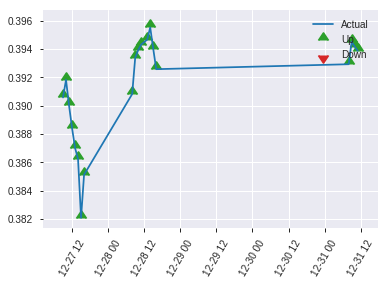


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26507942455790307
RMSE: 0.5148586452201255
LogLoss: 0.7244021721084324
Mean Per-Class Error: 0.44667832167832167
AUC: 0.5284715284715285
pr_auc: 0.43334845823735646
Gini: 0.0569430569430569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19737947564386474: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197379     0.58147   221
max f2                       0.197379     0.776451  221
max f0point5                 0.554581     0.475728  105
max accuracy                 0.706076     0.600897  1
max precision                0.71482      1         0
max recall                   0.197379     1         221
max specificity              0.71482      1         0
max absolute_mcc             0.445329     0.169649  201
max min_per_class_accuracy   0.554581     0.538462  105
max mean_per_class_accuracy  0.554581     0.553322  105

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 54.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.69997            1.6337    1.6337             0.666667         0.707231  0.666667                    0.707231            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.686361           0         0.98022            0                0.691925  0.4                         0.701108            0               0.021978                   -100      -1.97802
    3        0.0313901                   0.682595           2.45055   1.40031            1                0.684222  0.571429                    0.696284            0.021978        0.043956                   145.055   40.0314
    4        0.0403587                   0.67401            0         1.08913            0                0.678913  0.444444                    0.692424            0               0.043956                   -100      8.91331
    5        0.0538117                   0.671335           0.81685   1.02106            0.333333         0.673007  0.416667                    0.68757             0.010989        0.0549451                  -18.315   2.10623
    6        0.103139                    0.624782           0.891109  0.958911           0.363636         0.643299  0.391304                    0.666397            0.043956        0.0989011                  -10.8891  -4.10893
    7        0.152466                    0.612839           1.33666   1.08112            0.545455         0.617795  0.441176                    0.650673            0.0659341       0.164835                   33.6663   8.11248
    8        0.201794                    0.601256           1.55944   1.19805            0.636364         0.606223  0.488889                    0.639807            0.0769231       0.241758                   55.9441   19.8046
    9        0.300448                    0.581849           0.891109  1.09726            0.363636         0.591197  0.447761                    0.623846            0.0879121       0.32967                    -10.8891  9.72609
    10       0.399103                    0.566039           1.11389   1.10137            0.454545         0.574344  0.449438                    0.611609            0.10989         0.43956                    11.3886   10.1371
    11       0.502242                    0.551247           1.06546   1.094              0.434783         0.558331  0.446429                    0.600668            0.10989         0.549451                   6.54563   9.39953
    12       0.600897                    0.53793            0.77972   1.0424             0.318182         0.54407   0.425373                    0.591376            0.0769231       0.626374                   -22.028   4.23979
    13       0.699552                    0.517606           0.77972   1.00535            0.318182         0.526976  0.410256                    0.582294            0.0769231       0.703297                   -22.028   0.535362
    14       0.798206                    0.495736           0.891109  0.991233           0.363636         0.508953  0.404494                    0.573229            0.0879121       0.791209                   -10.8891  -0.876651
    15       0.896861                    0.447086           0.556943  0.943462           0.227273         0.47893   0.385                       0.562856            0.0549451       0.846154                   -44.3057  -5.65385
    16       1                           0.160996           1.49164   1                  0.608696         0.38014   0.408072                    0.544011     

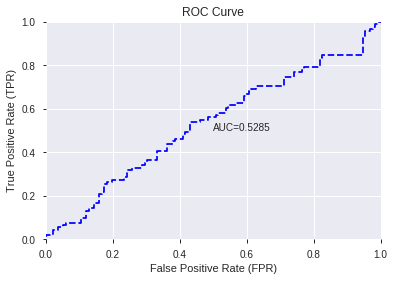

This function is available for GLM models only


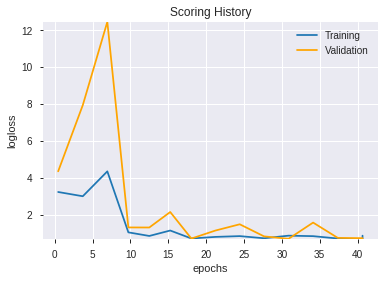

--2019-08-27 17:13:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_164917_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_164917_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLADVANCEBLOCK',
 'CDLEVENINGSTAR',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'hour',
 'CDLGAPSIDESIDEWHITE',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CDL3WHITESOLDIERS',
 'CDLLADDERBOTTOM',
 'CDLUNIQUE3RIVER',
 'CDLHOMINGPIGEON',
 'CDLHIKKAKEMOD',
 'CDLMATCHINGLOW',
 'CDLTAKURI',
 'CDLINNECK',
 'is_month_end',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDL3INSIDE',
 'CDLHAMMER',
 'CORREL_8',
 'CORREL_24',
 'CORREL_14',
 'CDLRICKSHAWMAN',
 'Volume',
 'aroondown_14',
 'SAREXT',
 'days_in_month',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CORREL_20',
 'HT_TRENDMODE',
 'aroonup_12',
 'aroondown_12',
 'BOP',
 'CORREL_12',
 'CDLTASUKIGAP',
 'VAR_30',
 'aroondown_30',
 'CORREL_30',
 'AROONOSC_8',
 'CDLHARAMICROSS',
 'STOCHRSI_fastk',
 'day',
 'weekday_name',
 'TRANGE',
 'STOCHRSI_fastd',
 'DX_30',
 'BETA_20',
 

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190827_171406_model_1  0.544123  0.694733              0.496212  0.50077  0.25077

variable  relative_importance  scaled_importance    percentage
0                         hour         2.522471e-02           1.000000  1.760224e-02
1                        DX_30         2.034328e-02           0.806482  1.419590e-02
2           CDLCLOSINGMARUBOZU         2.000156e-02           0.792935  1.395744e-02
3                       Volume         1.884657e-02           0.747147  1.315146e-02
4                        DX_24         1.809014e-02           0.717160  1.262362e-02
...                        ...                  ...                ...           ...
1032    LINEARREG_INTERCEPT_24         1.852703e-06           0.000073  1.292849e-06
1033                  MEDPRICE         8.596957e-07           0.000034  5.999106e-07
1034                   MA_12_2         6.243883e-07           0.000025  4.357090e-07
1035   BBANDS_lowerband_24_1_2         2.621120e-07           0.000010  1.829063e-07
1036  BBANDS_middleband_12_2_2         1.713743e-07           0.000007  1.195879e-07

[1037 rows x 4 columns]

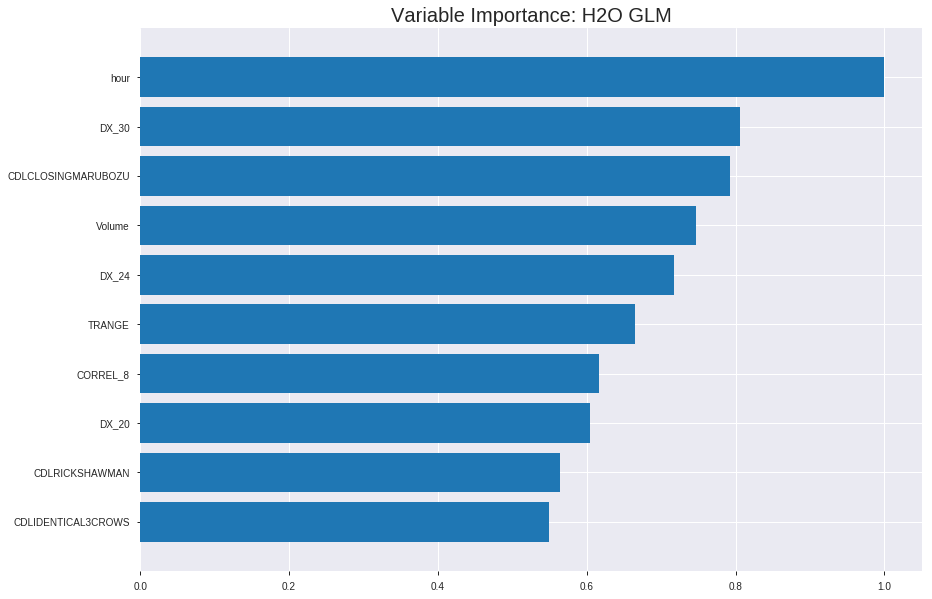

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_171406_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24239381890018194
RMSE: 0.49233506771322105
LogLoss: 0.6778004798339731
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2159.805536138753
Residual deviance: 2112.02629516266
AIC: 4188.02629516266
AUC: 0.6235603345280765
pr_auc: 0.6186814077594271
Gini: 0.24712066905615293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41993714298829893: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   727   0.9381   (727.0/775.0)
1      13   770   0.0166   (13.0/783.0)
Total  61   1497  0.475    (740.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419937     0.675439  360
max f2                       0.393318     0.837977  382
max f0point5                 0.503123     0.601999  189
max accuracy                 0.503123     0.598845  189
max precision                0.638801     1         0
max recall                   0.382353     1         388
max specificity              0.638801     1         0
max absolute_mcc             0.503123     0.19778   189
max min_per_class_accuracy   0.506386     0.595147  180
max mean_per_class_accuracy  0.503123     0.598679  189

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.590742           1.74106   1.74106            0.875            0.600597  0.875                       0.600597            0.0178799       0.0178799                  74.106    74.106
    2        0.0205392                   0.580197           1.6167    1.67888            0.8125           0.58498   0.84375                     0.592789            0.0166028       0.0344828                  61.6699   67.8879
    3        0.0301669                   0.574991           0.928565  1.43942            0.466667         0.577303  0.723404                    0.587847            0.00893997      0.0434227                  -7.14347  43.9417
    4        0.0404365                   0.569961           1.36798   1.42127            0.6875           0.572353  0.714286                    0.583912            0.0140485       0.0574713                  36.7976   42.1273
    5        0.0500642                   0.568248           1.45917   1.42856            0.733333         0.568947  0.717949                    0.581034            0.0140485       0.0715198                  45.9174   42.8562
    6        0.100128                    0.554489           1.40305   1.41581            0.705128         0.560997  0.711538                    0.571015            0.0702427       0.141762                   40.3052   41.5807
    7        0.150193                    0.544916           1.17346   1.33503            0.589744         0.54988   0.67094                     0.56397             0.0587484       0.200511                   17.3462   33.5025
    8        0.200257                    0.538137           1.12244   1.28188            0.564103         0.541214  0.644231                    0.558281            0.0561941       0.256705                   12.2442   28.1879
    9        0.300385                    0.526314           1.28826   1.28401            0.647436         0.531776  0.645299                    0.549446            0.128991        0.385696                   28.8257   28.4005
    10       0.399872                    0.516271           1.05266   1.22645            0.529032         0.521149  0.616372                    0.542406            0.104725        0.490421                   5.26593   22.6447
    11       0.5                         0.506151           1.04591   1.19029            0.525641         0.511371  0.598203                    0.536191            0.104725        0.595147                   4.59115   19.0294
    12       0.600128                    0.495692           0.880096  1.13854            0.442308         0.501281  0.572193                    0.530367            0.0881226       0.683269                   -11.9904  13.8539
    13       0.699615                    0.484307           0.872937  1.10077            0.43871          0.489848  0.553211                    0.524605            0.0868455       0.770115                   -12.7063  10.077
    14       0.799743                    0.469214           0.841831  1.06835            0.423077         0.477255  0.536918                    0.518677            0.0842912       0.854406                   -15.8169  6.83505
    15       0.899872                    0.444763           0.727036  1.03037            0.365385         0.458593  0.517832                    0.511991            0.0727969       0.927203                   -27.2964  3.03726
    16       1                           0.310363           0.727036  1                  0.365385         0.417876  0.502567                    0.502567           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2468692106807906
RMSE: 0.49685934697939477
LogLoss: 0.686899301840685
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 618.4838984721613
Residual deviance: 612.7141772418911
AIC: 2688.714177241891
AUC: 0.5816044956493716
pr_auc: 0.5405608130081007
Gini: 0.1632089912987431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3750224247429853: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    214  0        (0.0/214.0)
Total  1    445  0.5179   (231.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375022     0.649469  398
max f2                       0.375022     0.822444  398
max f0point5                 0.493924     0.564516  237
max accuracy                 0.525415     0.573991  133
max precision                0.571301     0.625     22
max recall                   0.375022     1         398
max specificity              0.60904      0.99569   0
max absolute_mcc             0.499171     0.152131  226
max min_per_class_accuracy   0.50821      0.551724  196
max mean_per_class_accuracy  0.499171     0.575129  226

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.592384           0.833645  0.833645           0.4              0.602794  0.4                         0.602794            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.580487           1.04206   0.926272           0.5              0.585826  0.444444                    0.595253            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.577934           1.25047   1.04206            0.6              0.579548  0.5                         0.589644            0.0140187       0.0327103                  25.0467   4.20561
    4        0.0403587                   0.573419           2.08411   1.27362            1                0.574541  0.611111                    0.586288            0.0186916       0.0514019                  108.411   27.3624
    5        0.0515695                   0.571573           1.25047   1.26859            0.6              0.572762  0.608696                    0.583347            0.0140187       0.0654206                  25.0467   26.859
    6        0.100897                    0.557317           1.23152   1.25047            0.590909         0.564803  0.6                         0.574281            0.0607477       0.126168                   23.1521   25.0467
    7        0.150224                    0.54774            0.947324  1.15093            0.454545         0.552423  0.552239                    0.567104            0.046729        0.172897                   -5.26763  15.0928
    8        0.201794                    0.540925           1.3592    1.20415            0.652174         0.544642  0.577778                    0.561364            0.0700935       0.242991                   35.9204   20.4154
    9        0.300448                    0.528621           1.13679   1.18203            0.545455         0.535547  0.567164                    0.552887            0.11215         0.35514                    13.6788   18.2034
    10       0.401345                    0.519512           1.15784   1.17595            0.555556         0.523921  0.564246                    0.545605            0.116822        0.471963                   15.784    17.5952
    11       0.5                         0.507822           0.852591  1.11215            0.409091         0.512664  0.533632                    0.539105            0.0841121       0.556075                   -14.7409  11.215
    12       0.600897                    0.496577           1.15784   1.11982            0.555556         0.501807  0.537313                    0.532842            0.116822        0.672897                   15.784    11.9821
    13       0.699552                    0.483812           0.757859  1.06878            0.363636         0.488923  0.512821                    0.526649            0.0747664       0.747664                   -24.2141  6.87755
    14       0.800448                    0.469373           0.972586  1.05665            0.466667         0.477355  0.507003                    0.520435            0.0981308       0.845794                   -2.74143  5.66507
    15       0.899103                    0.45168            0.663127  1.01347            0.318182         0.461877  0.486284                    0.51401             0.0654206       0.911215                   -33.6873  1.3471
    16       1                           0.362134           0.879958  1                  0.422222         0.424393  0.479821                    0.504968          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:14:09  0.000 sec   2            4         1038          1.37211           1.37623
    2019-08-27 17:14:11  2.029 sec   4            2.9       1038          1.36891           1.37525
    2019-08-27 17:14:14  4.059 sec   6            2.1       1038          1.36513           1.37437
    2019-08-27 17:14:16  6.069 sec   8            1.6       1038          1.36071           1.37386
    2019-08-27 17:14:18  8.141 sec   10           1.1       1038          1.3556            1.3738
    2019-08-27 17:14:20  10.188 sec  12           0.82      1038          1.34983           1.37431
    2019-08-27 17:14:22  12.256 sec  14           0.6       1038          1.34346           1.3756
    2019-08-27 17:14:24  14.396 sec  16           0.44      1038          1.33659           1.37783
    2019-08-27 17:14:26  16.424 sec  18           0.32      1038          1.32937           1.38114
    2019-08-27 17:14:28  18.478 sec  20           0.23      1038          1.32197           1.38573

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.5814696485623003)

('auc', 0.5441225441225441)

('logloss', 0.6947334059094757)

('mean_per_class_error', 0.4328588078588078)

('rmse', 0.500769724124348)

('mse', 0.2507703165995756)

glm prediction progress: |████████████████████████████████████████████████| 100%


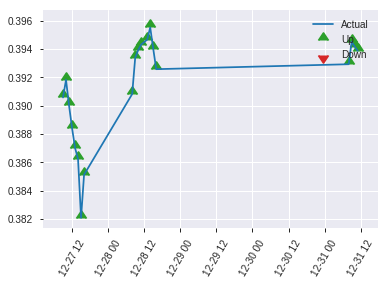


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2507703165995756
RMSE: 0.500769724124348
LogLoss: 0.6947334059094757
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 309.5705785684792
Residual deviance: 309.85109903562625
AIC: 2385.8510990356262
AUC: 0.5441225441225441
pr_auc: 0.4391096284476076
Gini: 0.08824508824508825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4021639766269723: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    131  0.9924   (131.0/132.0)
1      0    91   0        (0.0/91.0)
Total  1    222  0.5874   (131.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402164     0.58147   221
max f2                       0.402164     0.776451  221
max f0point5                 0.513913     0.488323  94
max accuracy                 0.5447       0.600897  35
max precision                0.599223     0.666667  2
max recall                   0.402164     1         221
max specificity              0.612704     0.992424  0
max absolute_mcc             0.517512     0.134582  82
max min_per_class_accuracy   0.510278     0.56044   107
max mean_per_class_accuracy  0.513913     0.567141  94

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.598823           1.6337    1.6337             0.666667         0.605496  0.666667                    0.605496            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.584038           0         0.98022            0                0.591095  0.4                         0.599736            0               0.021978                   -100      -1.97802
    3        0.0313901                   0.581551           1.22527   1.05024            0.5              0.582982  0.428571                    0.594949            0.010989        0.032967                   22.5275   5.02355
    4        0.0403587                   0.576849           0         0.81685            0                0.579457  0.333333                    0.591506            0               0.032967                   -100      -18.315
    5        0.0538117                   0.566879           1.6337    1.02106            0.666667         0.571708  0.416667                    0.586557            0.021978        0.0549451                  63.37     2.10623
    6        0.103139                    0.55582            0.891109  0.958911           0.363636         0.560069  0.391304                    0.573889            0.043956        0.0989011                  -10.8891  -4.10893
    7        0.152466                    0.54572            1.78222   1.22527            0.727273         0.549774  0.5                         0.566087            0.0879121       0.186813                   78.2218   22.5275
    8        0.201794                    0.538108           0.668332  1.08913            0.272727         0.541565  0.444444                    0.560093            0.032967        0.21978                    -33.1668  8.91331
    9        0.300448                    0.525136           1.33666   1.17041            0.545455         0.531645  0.477612                    0.550752            0.131868        0.351648                   33.6663   17.0412
    10       0.399103                    0.515132           1.11389   1.15644            0.454545         0.519474  0.47191                     0.54302             0.10989         0.461538                   11.3886   15.6439
    11       0.502242                    0.508947           0.958911  1.11588            0.391304         0.512139  0.455357                    0.536678            0.0989011       0.56044                    -4.10893  11.5875
    12       0.600897                    0.498714           1.0025    1.09726            0.409091         0.503639  0.447761                    0.531254            0.0989011       0.659341                   0.24975   9.72609
    13       0.699552                    0.486926           0.668332  1.03677            0.272727         0.492191  0.423077                    0.525745            0.0659341       0.725275                   -33.1668  3.67709
    14       0.798206                    0.471216           0.77972   1.005              0.318182         0.480085  0.410112                    0.520102            0.0769231       0.802198                   -22.028   0.500062
    15       0.896861                    0.456663           0.77972   0.98022            0.318182         0.463918  0.4                         0.513921            0.0769231       0.879121                   -22.028   -1.97802
    16       1                           0.386512           1.172     1                  0.478261         0.433575  0.408072                    0.505635       

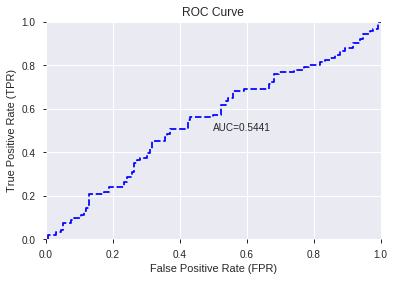

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


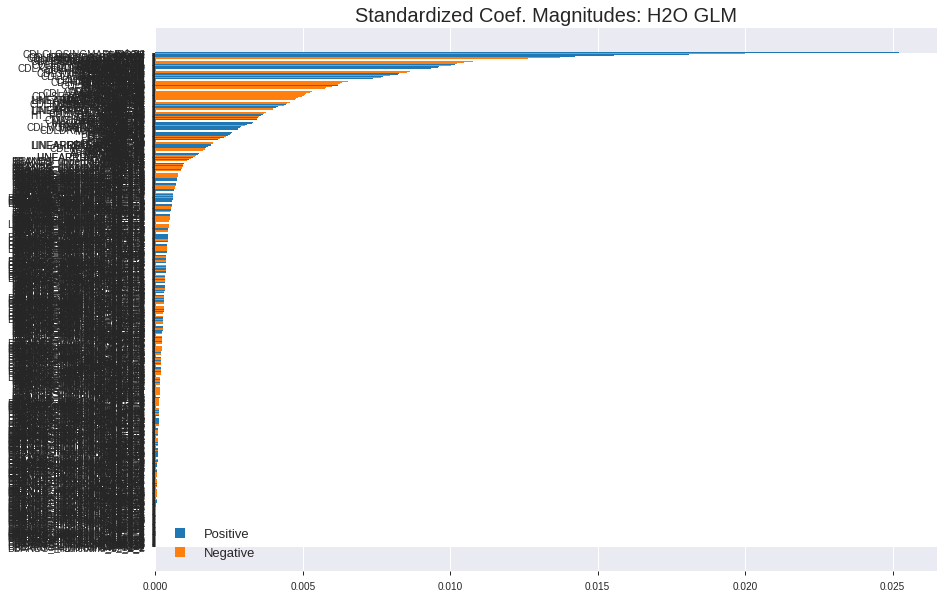

'log_likelihood'
--2019-08-27 17:14:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_171406_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_171406_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['hour',
 'DX_30',
 'CDLCLOSINGMARUBOZU',
 'Volume',
 'DX_24',
 'TRANGE',
 'CORREL_8',
 'DX_20',
 'CDLRICKSHAWMAN',
 'CDLIDENTICAL3CROWS',
 'CDLDARKCLOUDCOVER',
 'DIV',
 'SUB',
 'CDLEVENINGSTAR',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'aroonup_12',
 'CDLHAMMER',
 'aroondown_14',
 'STOCHF_fastk',
 'CORREL_24',
 'CDLHIGHWAVE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLLONGLINE',
 'days_in_month',
 'BETA_20',
 'ADX_24',
 'CDLUNIQUE3RIVER',
 'CDLXSIDEGAP3METHODS',
 'CDLHIKKAKEMOD',
 'aroondown_30',
 'ADOSC',
 'CDLHOMINGPIGEON',
 'CDL3OUTSIDE',
 'WILLR_14',
 'PLUS_DM_8',
 'is_month_start',
 'HT_DCPERIOD',
 'CDL3WHITESOLDIERS',
 'WILLR_12',
 'CDLINNECK',
 'CDLONNECK',
 'CDLHIKKAKE',
 'weekday_name',
 'CDLLADDERBOTTOM',
 'aroondown_12',
 'WILLR_8',
 'CDLHARAMI',
 'ADX_20',
 'STOCHRSI_fastd',
 'MINUS_DM_8',
 'DX_14',
 'MFI_14',
 'CDLHANGINGMAN',
 'aroondown_8',
 'PLUS_DM_12',
 'CDLBELTHOLD',
 'CDLHARAMICROSS',
 'MFI_30',
 'BOP',
 'MINUS_DI_12',
 'MINUS_D

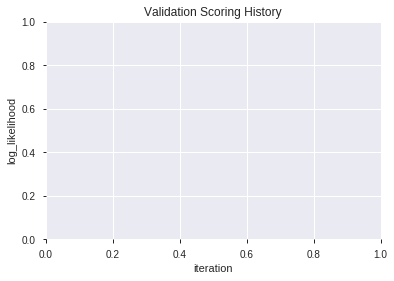

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_171501_model_2  0.507076  0.701901              0.488636  0.504245  0.254263
1  XGBoost_grid_1_AutoML_20190827_171501_model_4  0.498834  0.703575              0.500000  0.505019  0.255044
2  XGBoost_grid_1_AutoML_20190827_171501_model_5  0.493673  0.760585              0.492424  0.529736  0.280620
3  XGBoost_grid_1_AutoML_20190827_171501_model_6  0.489261  0.732288              0.474817  0.518165  0.268495
4               XGBoost_1_AutoML_20190827_171501  0.487512  0.717426              0.500000  0.511298  0.261426
5  XGBoost_grid_1_AutoML_20190827_171501_model_1  0.486097  0.725761              0.500000  0.515142  0.265371
6               XGBoost_2_AutoML_20190827_171501  0.478771  0.713049              0.500000  0.509039  0.259121
7               XGBoost_3_AutoML_20190827_171501  0.477356  0.715017              0.496212  0.510540  0.260651
8  XGBoost_grid_1_AutoML_20190827_171501_model_3  0.472694  0.712198              0.488636  0.509133  0.259217
9  XGBoost_grid_1_AutoML_20190827_171501_model_7  0.468032  0.735569              0.500000  0.519245  0.269615

variable  relative_importance  scaled_importance  percentage
0                        BOP           150.426239           1.000000    0.024878
1                   STDDEV_8           120.341698           0.800005    0.019903
2                       hour           110.142258           0.732201    0.018216
3               MACDEXT_hist            99.169762           0.659258    0.016401
4                      CCI_8            97.387566           0.647411    0.016107
..                       ...                  ...                ...         ...
308   BBANDS_lowerband_8_0_2             0.600158           0.003990    0.000099
309  BBANDS_lowerband_12_7_2             0.474082           0.003152    0.000078
310              MIDPRICE_12             0.394487           0.002622    0.000065
311   BBANDS_lowerband_8_1_4             0.365963           0.002433    0.000061
312  BBANDS_lowerband_12_0_3             0.193844           0.001289    0.000032

[313 rows x 4 columns]

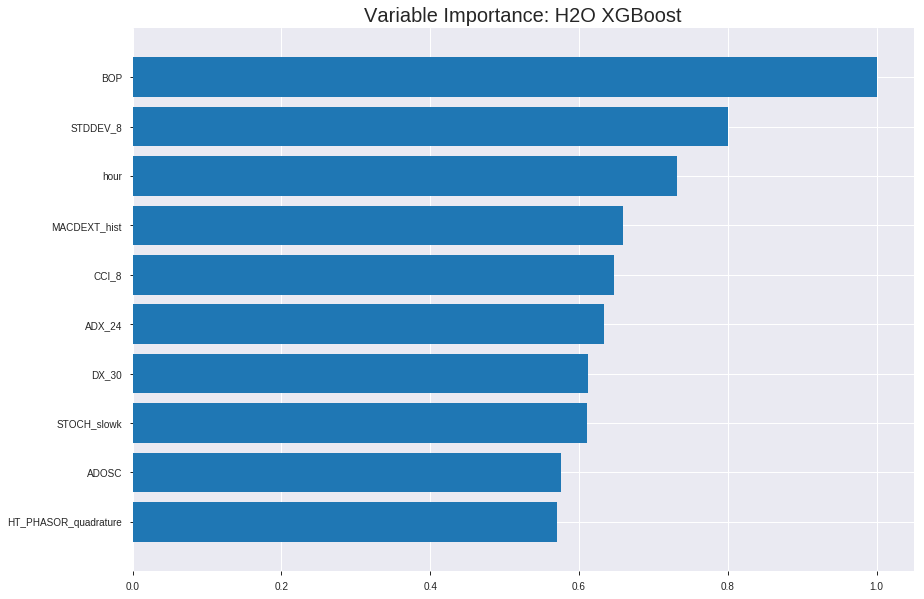

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_171501_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17575066915361606
RMSE: 0.41922627440752813
LogLoss: 0.5408996892015157
Mean Per-Class Error: 0.10462077205125042
AUC: 0.9611222345816339
pr_auc: 0.960336112804965
Gini: 0.9222444691632679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.501217782497406: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      694  81   0.1045   (81.0/775.0)
1      82   701  0.1047   (82.0/783.0)
Total  776  782  0.1046   (163.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501218     0.895847  207
max f2                       0.455345     0.924708  250
max f0point5                 0.526194     0.917603  183
max accuracy                 0.501218     0.895379  207
max precision                0.769975     1         0
max recall                   0.357229     1         343
max specificity              0.769975     1         0
max absolute_mcc             0.501218     0.790754  207
max min_per_class_accuracy   0.501218     0.895275  207
max mean_per_class_accuracy  0.501218     0.895379  207

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.732522           1.98978   1.98978            1                0.745271  1                           0.745271            0.0204342       0.0204342                  98.9783   98.9783
    2        0.0205392                   0.709313           1.98978   1.98978            1                0.720128  1                           0.7327              0.0204342       0.0408685                  98.9783   98.9783
    3        0.0301669                   0.694033           1.98978   1.98978            1                0.701894  1                           0.722868            0.0191571       0.0600255                  98.9783   98.9783
    4        0.0404365                   0.682433           1.98978   1.98978            1                0.687311  1                           0.713838            0.0204342       0.0804598                  98.9783   98.9783
    5        0.0500642                   0.672727           1.98978   1.98978            1                0.67739   1                           0.706829            0.0191571       0.0996169                  98.9783   98.9783
    6        0.100128                    0.646251           1.96427   1.97703            0.987179         0.659208  0.99359                     0.683018            0.0983397       0.197957                   96.4273   97.7028
    7        0.150193                    0.624259           1.93876   1.96427            0.974359         0.635148  0.987179                    0.667062            0.0970626       0.295019                   93.8763   96.4273
    8        0.200257                    0.607408           1.98978   1.97065            1                0.6161    0.990385                    0.654321            0.0996169       0.394636                   98.9783   97.065
    9        0.300385                    0.573771           1.92601   1.95577            0.967949         0.589938  0.982906                    0.63286             0.192848        0.587484                   92.6008   95.577
    10       0.399872                    0.534928           1.78439   1.91313            0.896774         0.556474  0.961477                    0.613855            0.177522        0.765006                   78.4386   91.313
    11       0.5                         0.501356           1.2755    1.78544            0.641026         0.518857  0.897304                    0.594831            0.127714        0.89272                    27.5502   78.5441
    12       0.600128                    0.462938           0.663261  1.59821            0.333333         0.481566  0.803209                    0.575934            0.0664112       0.959132                   -33.6739  59.8211
    13       0.699615                    0.427434           0.295258  1.41293            0.148387         0.445946  0.710092                    0.557449            0.0293742       0.988506                   -70.4742  41.2928
    14       0.799743                    0.39306            0.10204   1.2488             0.0512821        0.410827  0.627608                    0.539092            0.0102171       0.998723                   -89.796   24.8804
    15       0.899872                    0.355314           0.012755  1.11127            0.00641026       0.373229  0.558488                    0.520636            0.00127714      1                          -98.7245  11.127
    16       1                           0.275744           0         1                  0                0.329146  0.502567                    0.501463            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25246665420307807
RMSE: 0.5024605996524285
LogLoss: 0.6986690876746027
Mean Per-Class Error: 0.4358282307444409
AUC: 0.5414518208185627
pr_auc: 0.496042408458902
Gini: 0.08290364163712538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534581959247589: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      0    214  0        (0.0/214.0)
Total  2    444  0.5157   (230.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353458     0.650456  397
max f2                       0.353458     0.823077  397
max f0point5                 0.491868     0.554675  237
max accuracy                 0.500965     0.560538  219
max precision                0.537901     0.550633  143
max recall                   0.353458     1         397
max specificity              0.727225     0.99569   0
max absolute_mcc             0.491868     0.130246  237
max min_per_class_accuracy   0.506561     0.538793  200
max mean_per_class_accuracy  0.491868     0.564172  237

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.691612           0         0                  0                0.707858  0                           0.707858            0               0                          -100       -100
    2        0.0201794                   0.673881           1.04206   0.463136           0.5              0.686087  0.222222                    0.698182            0.00934579      0.00934579                 4.20561    -53.6864
    3        0.0313901                   0.662323           0.833645  0.595461           0.4              0.668372  0.285714                    0.687536            0.00934579      0.0186916                  -16.6355   -40.4539
    4        0.0403587                   0.651567           1.04206   0.694704           0.5              0.656777  0.333333                    0.6807              0.00934579      0.0280374                  4.20561    -30.5296
    5        0.0515695                   0.64389            1.66729   0.906136           0.8              0.648222  0.434783                    0.67364             0.0186916       0.046729                   66.729     -9.38643
    6        0.100897                    0.613316           1.13679   1.0189             0.545455         0.627041  0.488889                    0.650858            0.0560748       0.102804                   13.6788    1.88993
    7        0.150224                    0.596251           0.947324  0.995397           0.454545         0.60431   0.477612                    0.635574            0.046729        0.149533                   -5.26763   -0.460315
    8        0.201794                    0.58411            0.996749  0.995742           0.478261         0.588377  0.477778                    0.623512            0.0514019       0.200935                   -0.325071  -0.425753
    9        0.300448                    0.553857           1.32625   1.10427            0.636364         0.567584  0.529851                    0.605148            0.130841        0.331776                   32.6253    10.4268
    10       0.401345                    0.530145           1.20415   1.12938            0.577778         0.540632  0.541899                    0.588929            0.121495        0.453271                   20.4154    12.9379
    11       0.5                         0.506269           0.899958  1.08411            0.431818         0.517253  0.520179                    0.574786            0.088785        0.542056                   -10.0042   8.41121
    12       0.600897                    0.489562           1.15784   1.09649            0.555556         0.498954  0.526119                    0.562053            0.116822        0.658879                   15.784     9.64918
    13       0.699552                    0.471315           0.710493  1.04206            0.340909         0.48071   0.5                         0.550582            0.0700935       0.728972                   -28.9507   4.20561
    14       0.800448                    0.446917           0.787331  1.00995            0.377778         0.461104  0.484594                    0.539303            0.0794393       0.808411                   -21.2669   0.99479
    15       0.899103                    0.418914           0.947324  1.00308            0.454545         0.433825  0.481297                    0.527729            0.0934579       0.901869                   -5.26763   0.307642
    16       1                           0.30926            0.972586  1                  0.466667         0.395746  0.479821              


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:15:21  3.313 sec   0                  0.5              0.693147            0.5             0                  1                0.497433                         0.5                0.693147              0.5               0                    1                  0.520179
    2019-08-27 17:15:22  4.405 sec   5                  0.489627         0.672594            0.818468        0.814718           1.98978          0.261874                         0.499242           0.691632              0.540404          0.510526             1.25047            0.517937
    2019-08-27 17:15:22  4.642 sec   10                 0.480241         0.654299            0.868852        0.869695           1.98978          0.226573                         0.498997           0.691153              0.553084          0.498043             0.416822           0.517937
    2019-08-27 17:15:23  4.887 sec   15                 0.470406         0.635411            0.898841        0.898525           1.98978          0.175866                         0.498717           0.690607              0.55968           0.515066             0.416822           0.513453
    2019-08-27 17:15:23  5.120 sec   20                 0.462595         0.620582            0.915068        0.912356           1.98978          0.161104                         0.49969            0.692583              0.545047          0.506082             0.833645           0.520179
    2019-08-27 17:15:23  5.360 sec   25                 0.45446          0.605301            0.926784        0.927155           1.98978          0.156611                         0.499745           0.692736              0.547394          0.507083             0.416822           0.515695
    2019-08-27 17:15:23  5.599 sec   30                 0.446183         0.589907            0.936168        0.935898           1.98978          0.140565                         0.500536           0.69441               0.542439          0.5008               0                  0.517937
    2019-08-27 17:15:24  5.853 sec   35                 0.439898         0.578317            0.941909        0.942344           1.98978          0.138639                         0.501126           0.695704              0.542006          0.499377             0.416822           0.517937
    2019-08-27 17:15:24  6.095 sec   40                 0.433328         0.56629             0.948091        0.94831            1.98978          0.125802                         0.501638           0.69681               0.540153          0.498755             0.416822           0.517937
    2019-08-27 17:15:24  6.339 sec   45                 0.425934         0.552983            0.95723         0.955754           1.98978          0.114891                         0.502351           0.698299              0.534855          0.494011             0                  0.517937
    2019-08-27 17:15:24  6.587 sec   50                 0.419226         0.5409              0.961122        0.960336           1.98978          0.104621                         0.502461           0.698669              0.541452          0.496042             0                  0.515695

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      150.42623901367188     1.0                    0.024878393165278026
STDDEV_8                 120.3416976928711      0.8000046965339174     0.019902831374439732
hour                     110.14225769042969     0.7322011001047438     0.01821598684445491
MACDEXT_hist             99.16976165771484      0.6592584000501505     0.01640128967395979
CCI_8                    97.38756561279297      0.6474107592621634     0.016106539408355262
---                      ---                    ---                    ---
BBANDS_lowerband_8_0_2   0.6001583337783813     0.003989718400948882   9.925778299755064e-05
BBANDS_lowerband_12_7_2  0.47408199310302734    0.0031515910801967147  7.840652198931713e-05
MIDPRICE_12              0.39448702335357666    0.0026224615196137604  6.52426287457636e-05
BBANDS_lowerband_8_1_4   0.3659634590148926     0.0024328432420731537  6.052523068578557e-05
BBANDS_lowerband_12_0_3  0.1938435137271881     0.0012886283337149055  3.205900233007651e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.5852090032154341)

('auc', 0.507076257076257)

('logloss', 0.7019008132021172)

('mean_per_class_error', 0.45329670329670324)

('rmse', 0.5042449123667985)

('mse', 0.2542629316478002)

xgboost prediction progress: |████████████████████████████████████████████| 100%


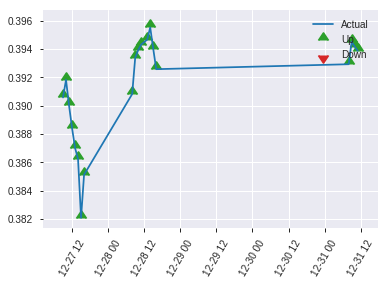


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2542629316478002
RMSE: 0.5042449123667985
LogLoss: 0.7019008132021172
Mean Per-Class Error: 0.45329670329670324
AUC: 0.507076257076257
pr_auc: 0.4128623858106506
Gini: 0.014152514152514062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39563116431236267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    129  0.9773   (129.0/132.0)
1      0    91   0        (0.0/91.0)
Total  3    220  0.5785   (129.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395631     0.585209  219
max f2                       0.395631     0.77911   219
max f0point5                 0.495901     0.472855  119
max accuracy                 0.651766     0.596413  0
max precision                0.651766     1         0
max recall                   0.395631     1         219
max specificity              0.651766     1         0
max absolute_mcc             0.436133     0.106867  186
max min_per_class_accuracy   0.499898     0.515152  110
max mean_per_class_accuracy  0.495901     0.546703  119

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.64024            0.81685   0.81685            0.333333         0.647292  0.333333                    0.647292            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.639241           1.22527   0.98022            0.5              0.639694  0.4                         0.644253            0.010989        0.021978                   22.5275   -1.97802
    3        0.0313901                   0.62947            1.22527   1.05024            0.5              0.635523  0.428571                    0.641758            0.010989        0.032967                   22.5275   5.02355
    4        0.0403587                   0.623612           1.22527   1.08913            0.5              0.628143  0.444444                    0.638733            0.010989        0.043956                   22.5275   8.91331
    5        0.0538117                   0.61575            1.6337    1.22527            0.666667         0.620438  0.5                         0.634159            0.021978        0.0659341                  63.37     22.5275
    6        0.103139                    0.599648           1.11389   1.172              0.454545         0.607211  0.478261                    0.621271            0.0549451       0.120879                   11.3886   17.2002
    7        0.152466                    0.582361           0.668332  1.00905            0.272727         0.591286  0.411765                    0.61157             0.032967        0.153846                   -33.1668  0.904977
    8        0.201794                    0.563183           1.33666   1.08913            0.545455         0.572187  0.444444                    0.601943            0.0659341       0.21978                    33.6663   8.91331
    9        0.300448                    0.545771           0.77972   0.987535           0.318182         0.553307  0.402985                    0.585973            0.0769231       0.296703                   -22.028   -1.24651
    10       0.399103                    0.520735           1.11389   1.01877            0.454545         0.530774  0.41573                     0.572328            0.10989         0.406593                   11.3886   1.87677
    11       0.502242                    0.499685           1.172     1.05024            0.478261         0.510148  0.428571                    0.559559            0.120879        0.527473                   17.2002   5.02355
    12       0.600897                    0.482152           1.0025    1.0424             0.409091         0.49148   0.425373                    0.548382            0.0989011       0.626374                   0.24975   4.23979
    13       0.699552                    0.458576           0.891109  1.02106            0.363636         0.469329  0.416667                    0.537234            0.0879121       0.714286                   -10.8891  2.10623
    14       0.798206                    0.444972           0.668332  0.977466           0.272727         0.451916  0.398876                    0.526689            0.0659341       0.78022                    -33.1668  -2.25336
    15       0.896861                    0.423411           1.0025    0.98022            0.409091         0.434295  0.4                         0.516525            0.0989011       0.879121                   0.24975   -1.97802
    16       1                           0.382033           1.172     1                  0.478261         0.40937   0.408072                    0.505473    

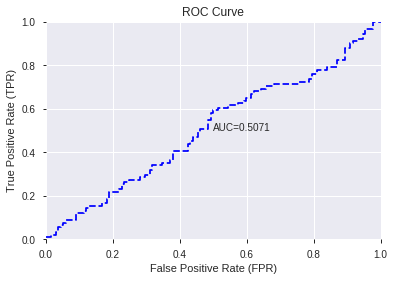

This function is available for GLM models only


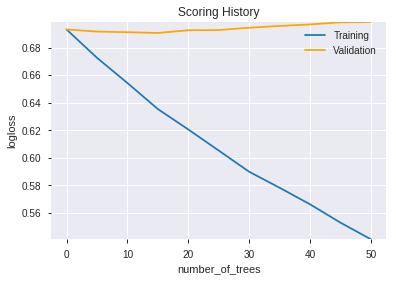

--2019-08-27 17:15:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_171501_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_171501_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STDDEV_8',
 'hour',
 'MACDEXT_hist',
 'CCI_8',
 'ADX_24',
 'DX_30',
 'STOCH_slowk',
 'ADOSC',
 'HT_PHASOR_quadrature',
 'Volume',
 'STOCHF_fastk',
 'STOCH_slowd',
 'DX_8',
 'TRANGE',
 'MFI_8',
 'HT_DCPERIOD',
 'CORREL_30',
 'HT_PHASOR_inphase',
 'MFI_14',
 'ROC_12',
 'DIV',
 'BETA_8',
 'MFI_12',
 'MACDFIX_hist_24',
 'STDDEV_12',
 'PLUS_DM_8',
 'STOCHRSI_fastd',
 'STDDEV_24',
 'CCI_12',
 'BETA_20',
 'BETA_14',
 'BETA_12',
 'MFI_30',
 'ADXR_8',
 'NATR_8',
 'MACDFIX_hist_20',
 'BETA_30',
 'STDDEV_20',
 'ADXR_12',
 'aroondown_30',
 'SUB',
 'STDDEV_30',
 'AD',
 'CMO_12',
 'MINUS_DI_30',
 'DX_24',
 'ADXR_14',
 'ADX_12',
 'CCI_14',
 'aroonup_12',
 'CORREL_8',
 'BETA_24',
 'WILLR_12',
 'aroonup_30',
 'PLUS_DI_30',
 'ADX_14',
 'CCI_20',
 'ADX_20',
 'PLUS_DM_14',
 'PLUS_DM_12',
 'AROONOSC_20',
 'MOM_14',
 'AROONOSC_14',
 'aroonup_20',
 'LINEARREG_ANGLE_12',
 'LINEARREG_ANGLE_8',
 'DX_12',
 'AROONOSC_24',
 'APO',
 'OBV',
 'MACDEXT_signal',
 'PLUS_DI_8',
 'MFI_20',
 'CMO_24',
 'PLUS_DM_3

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

59

['BBANDS_lowerband_14_6_5',
 'BBANDS_lowerband_24_0_2',
 'BBANDS_middleband_24_7_3',
 'BOP',
 'CCI_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'MACDFIX_hist_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'aroondown_14',
 'AROONOSC_14',
 'MACDFIX_14',
 'MOM_14',
 'PLUS_DM_14',
 'RSI_14',
 'aroondown_20',
 'CMO_20',
 'MINUS_DM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'RSI_20',
 'CCI_24',
 'DX_24',
 'MACDFIX_24',
 'PLUS_DM_24',
 'ROCR100_24',
 'WILLR_24',
 'AROONOSC_30',
 'CCI_30',
 'MFI_30',
 'MOM_30',
 'RSI_30',
 'MACDEXT',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ATR_30',
 'NATR_30',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'BETA_12',
 'LINEARREG_ANGLE_12',
 'BETA_14',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_171714_model_6  0.540626  0.698292              0.500000  0.502310  0.252316
1  DeepLearning_grid_1_AutoML_20190827_171714_model_7  0.538711  0.703621              0.471404  0.505362  0.255390
2  DeepLearning_grid_1_AutoML_20190827_171714_model_1  0.535465  1.262805              0.496212  0.585659  0.342996
3  DeepLearning_grid_1_AutoML_20190827_171714_model_9  0.530345  0.685118              0.490343  0.495974  0.245990
4  DeepLearning_grid_1_AutoML_20190827_171714_model_4  0.529387  0.887171              0.496212  0.557998  0.311362
5  DeepLearning_grid_1_AutoML_20190827_171714_model_3  0.522977  0.888633              0.496212  0.554904  0.307919
6  DeepLearning_grid_1_AutoML_20190827_171714_model_5  0.517566  0.683625              0.496212  0.495107  0.245131
7  DeepLearning_grid_1_AutoML_20190827_171714_model_8  0.516026  0.680651              0.492424  0.493739  0.243778
8  DeepLearning_grid_1_AutoML_20190827_171714_model_2  0.507659  1.857054              0.474817  0.672776  0.452628
9               DeepLearning_1_AutoML_20190827_171714  0.483683  0.954040              0.481061  0.581790  0.338480

variable  relative_importance  scaled_importance  percentage
0                      DX_24             1.000000           1.000000    0.022248
1               aroondown_14             0.882174           0.882174    0.019626
2             STOCHRSI_fastk             0.878995           0.878995    0.019556
3                        BOP             0.877764           0.877764    0.019528
4                     MFI_30             0.869600           0.869600    0.019347
5                     TRANGE             0.864415           0.864415    0.019231
6                  CORREL_14             0.860328           0.860328    0.019140
7                    BETA_14             0.848011           0.848011    0.018866
8         CDLCLOSINGMARUBOZU             0.835886           0.835886    0.018597
9    BBANDS_lowerband_24_0_2             0.825808           0.825808    0.018372
10  BBANDS_middleband_24_7_3             0.825671           0.825671    0.018369
11            STOCHRSI_fastd             0.816684           0.816684    0.018169
12                    BETA_8             0.814427           0.814427    0.018119
13               STOCH_slowk             0.803511           0.803511    0.017876
14                PLUS_DM_14             0.800550           0.800550    0.017810
15               AROONOSC_30             0.798614           0.798614    0.017767
16               STOCH_slowd             0.791341           0.791341    0.017606
17              STOCHF_fastd             0.789022           0.789022    0.017554
18                    MOM_30             0.787724           0.787724    0.017525
19                   NATR_30             0.787094           0.787094    0.017511
20   BBANDS_lowerband_14_6_5             0.785456           0.785456    0.017475
21                   BETA_12             0.784209           0.784209    0.017447
22                MACDFIX_24             0.784040           0.784040    0.017443
23      HT_PHASOR_quadrature             0.767220           0.767220    0.017069
24           MACDFIX_hist_12             0.764958           0.764958    0.017019
25                    RSI_30             0.762006           0.762006    0.016953
26                    ATR_30             0.761952           0.761952    0.016952
27                PLUS_DM_24             0.761049           0.761049    0.016932
28              MACDEXT_hist             0.759579           0.759579    0.016899
29                    ULTOSC             0.755123           0.755123    0.016800
30              aroondown_20             0.753363           0.753363    0.016761
31              STOCHF_fastk             0.752409           0.752409    0.016739
32                    CCI_12             0.749735           0.749735    0.016680
33                ROCR100_24             0.733733           0.733733    0.016324
34               MINUS_DM_12             0.729338           0.729338    0.016226
35        LINEARREG_ANGLE_14             0.727814           0.727814    0.016192
36                  WILLR_24             0.726909           0.726909    0.016172
37               MINUS_DM_20             0.724300           0.724300    0.016114
38                     CCI_8             0.722072           0.722072    0.016064
39                    MOM_12             0.721665           0.721665    0.016055
40        LINEARREG_ANGLE_12             0.720985           0.720985    0.016040
41                   MACDEXT             0.715827           0.715827    0.015926
42                   WILLR_8             0.714880           0.714880    0.015904
43                    RSI_20             0.712065           0.712065    0.015842
44                MACDFIX_14             0.709412           0.709412    0.015783
45        LINEARREG_SLOPE_14             0.709028           0.709028    0.015774
46         LINEARREG_SLOPE_8             0.702434           0.702434    0.015628
47                    ROC_12             0.701091           0.701091    0.015598
48         LINEARREG_ANGLE_8             0.699057  

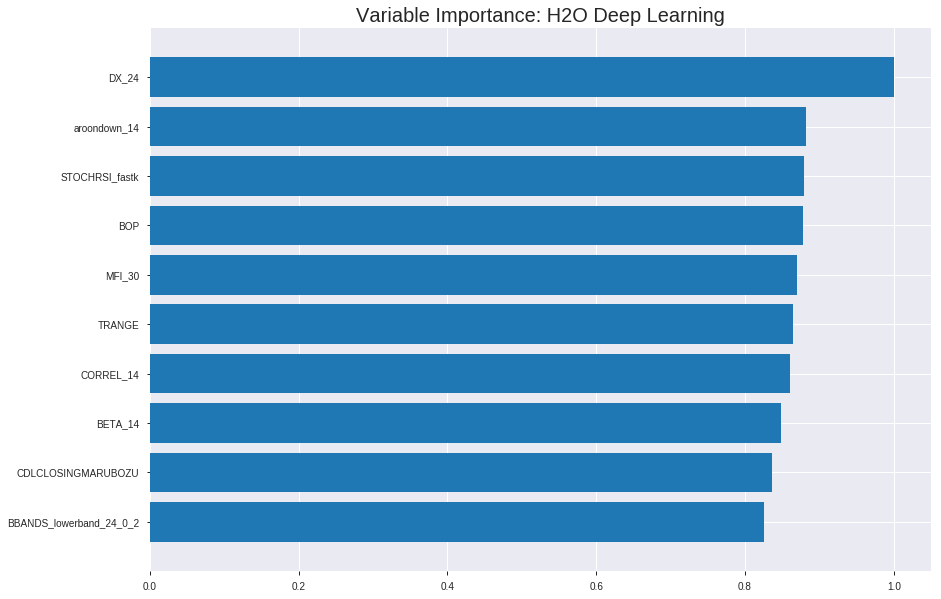

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_171714_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23872952109531784
RMSE: 0.488599550854601
LogLoss: 0.6687826154993584
Mean Per-Class Error: 0.4218011782639146
AUC: 0.6104939644872904
pr_auc: 0.5984976666216749
Gini: 0.22098792897458086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3693838239554682: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      128  647   0.8348   (647.0/775.0)
1      39   744   0.0498   (39.0/783.0)
Total  167  1391  0.4403   (686.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369384     0.684453  308
max f2                       0.31025      0.838388  346
max f0point5                 0.406929     0.592875  275
max accuracy                 0.486705     0.578306  187
max precision                0.748928     1         0
max recall                   0.148942     1         386
max specificity              0.748928     1         0
max absolute_mcc             0.406929     0.189635  275
max min_per_class_accuracy   0.492198     0.572158  181
max mean_per_class_accuracy  0.486705     0.578199  187

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 47.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.677271           1.49234   1.49234            0.75             0.700625  0.75                        0.700625            0.0153257       0.0153257                  49.2337   49.2337
    2        0.0205392                   0.656216           1.36798   1.43016            0.6875           0.668239  0.71875                     0.684432            0.0140485       0.0293742                  36.7976   43.0156
    3        0.0301669                   0.644739           1.59183   1.48175            0.8              0.64993   0.744681                    0.673421            0.0153257       0.0446999                  59.1826   48.1753
    4        0.0404365                   0.631687           1.86542   1.57919            0.9375           0.63896   0.793651                    0.664669            0.0191571       0.063857                   86.5421   57.9193
    5        0.0500642                   0.620555           1.32652   1.5306             0.666667         0.627389  0.769231                    0.6575              0.0127714       0.0766284                  32.6522   53.0602
    6        0.100128                    0.583396           1.09693   1.31377            0.551282         0.600646  0.660256                    0.629073            0.054917        0.131545                   9.69316   31.3767
    7        0.150193                    0.557325           1.14795   1.2585             0.576923         0.569556  0.632479                    0.609234            0.0574713       0.189017                   14.7952   25.8495
    8        0.200257                    0.538837           1.17346   1.23724            0.589744         0.547199  0.621795                    0.593725            0.0587484       0.247765                   17.3462   23.7237
    9        0.300385                    0.518002           1.08418   1.18622            0.544872         0.527643  0.596154                    0.571698            0.108557        0.356322                   8.41766   18.6217
    10       0.399872                    0.504037           1.1682    1.18173            0.587097         0.510916  0.5939                      0.556576            0.11622         0.472542                   16.8195   18.1733
    11       0.5                         0.49125            1.0204    1.14943            0.512821         0.498083  0.577664                    0.544862            0.102171        0.574713                   2.04015   14.9425
    12       0.600128                    0.472732           0.982136  1.12151            0.49359          0.481596  0.563636                    0.534307            0.0983397       0.673052                   -1.78636  12.1514
    13       0.699615                    0.446998           0.924286  1.09347            0.464516         0.461577  0.549541                    0.523964            0.091954        0.765006                   -7.57138  9.34678
    14       0.799743                    0.415289           1.05867   1.08911            0.532051         0.432396  0.547352                    0.5125              0.106003        0.871009                   5.86665   8.91107
    15       0.899872                    0.365204           0.816321  1.05876            0.410256         0.391963  0.532097                    0.499088            0.0817369       0.952746                   -18.3679  5.87575
    16       1                           0.0275107          0.471936  1                  0.237179         0.279463  0.502567                    0.477097         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25046740838578485
RMSE: 0.5004671901191774
LogLoss: 0.6964499634048235
Mean Per-Class Error: 0.4465839510151466
AUC: 0.5550878182404125
pr_auc: 0.5157688844142422
Gini: 0.11017563648082507
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.058968940890548535: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    232  1        (232.0/232.0)
1      0    214  0        (0.0/214.0)
Total  0    446  0.5202   (232.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0589689    0.648485  399
max f2                       0.0589689    0.821813  399
max f0point5                 0.481668     0.550071  262
max accuracy                 0.546463     0.558296  79
max precision                0.549416     0.602564  69
max recall                   0.0589689    1         399
max specificity              0.710459     0.99569   0
max absolute_mcc             0.546463     0.115111  79
max min_per_class_accuracy   0.506769     0.53271   195
max mean_per_class_accuracy  0.487962     0.553416  254

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.677305           0.833645  0.833645           0.4              0.693646  0.4                         0.693646            0.00934579      0.00934579                 -16.6355   -16.6355
    2        0.0201794                   0.625681           0.521028  0.694704           0.25             0.651926  0.333333                    0.675104            0.0046729       0.0140187                  -47.8972   -30.5296
    3        0.0313901                   0.607821           0.833645  0.744326           0.4              0.616921  0.357143                    0.654324            0.00934579      0.0233645                  -16.6355   -25.5674
    4        0.0403587                   0.600909           1.04206   0.810488           0.5              0.604125  0.388889                    0.643169            0.00934579      0.0327103                  4.20561    -18.9512
    5        0.0515695                   0.595585           1.66729   0.996749           0.8              0.599342  0.478261                    0.633641            0.0186916       0.0514019                  66.729     -0.325071
    6        0.100897                    0.566437           1.32625   1.15784            0.636364         0.580161  0.555556                    0.607495            0.0654206       0.116822                   32.6253    15.784
    7        0.150224                    0.556817           1.32625   1.21314            0.636364         0.56048   0.58209                     0.592057            0.0654206       0.182243                   32.6253    21.314
    8        0.201794                    0.546635           1.26859   1.22731            0.608696         0.550229  0.588889                    0.581368            0.0654206       0.247664                   26.859     22.731
    9        0.300448                    0.532792           0.852591  1.10427            0.409091         0.539131  0.529851                    0.567499            0.0841121       0.331776                   -14.7409   10.4268
    10       0.401345                    0.518849           1.0189    1.08281            0.488889         0.526037  0.519553                    0.557076            0.102804        0.434579                   1.88993    8.28069
    11       0.5                         0.506549           0.99469   1.06542            0.477273         0.511999  0.511211                    0.548182            0.0981308       0.53271                    -0.531011  6.54206
    12       0.600897                    0.496317           1.06521   1.06539            0.511111         0.500392  0.511194                    0.540157            0.107477        0.640187                   6.52129    6.53857
    13       0.699552                    0.477183           0.99469   1.05542            0.477273         0.487087  0.50641                     0.532673            0.0981308       0.738318                   -0.531011  5.54158
    14       0.800448                    0.450064           0.926272  1.03914            0.444444         0.464288  0.498599                    0.524053            0.0934579       0.831776                   -7.37279   3.91372
    15       0.899103                    0.396253           0.852591  1.01867            0.409091         0.426454  0.488778                    0.513344            0.0841121       0.915888                   -14.7409   1.86683
    16       1                           0.0589689          0.833645  1                  0.4              0.332178  0.479821                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:20:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:20:35  1 min 44.834 sec  1017 obs/sec      1.99615   1             3110       0.54756          0.843114            -0.199317      0.561431        0.552004           1.36798          0.491656                         0.546879           0.850995              -0.19826         0.561432          0.513965             1.25047            0.520179
    2019-08-27 17:20:41  1 min 50.421 sec  1915 obs/sec      9.98074   5             15550      0.499399         0.691657            0.00237822     0.574307        0.568137           1.49234          0.469833                         0.502409           0.698753              -0.0113064       0.551633          0.513595             0.833645           0.520179
    2019-08-27 17:20:47  1 min 56.418 sec  2512 obs/sec      21.9544   11            34205      0.4886           0.668783            0.0450567      0.610494        0.598498           1.49234          0.440308                         0.500467           0.69645               -0.00350417      0.555088          0.515769             0.833645           0.520179
    2019-08-27 17:20:53  2 min  2.242 sec  2790 obs/sec      33.93     17            52863      0.482113         0.65518             0.0702443      0.639541        0.635743           1.86542          0.418485                         0.505313           0.705829              -0.0230329       0.525983          0.483633             0.833645           0.520179
    2019-08-27 17:20:58  2 min  8.516 sec  2960 obs/sec      45.9076   23            71524      0.475064         0.639541            0.0972321      0.677559        0.671183           1.98978          0.412709                         0.50225            0.701407              -0.0106651       0.537957          0.502927             1.66729            0.513453
    2019-08-27 17:21:10  2 min 19.143 sec  3083 obs/sec      67.8639   34            105732     0.466774         0.620352            0.128466       0.718931        0.716235           1.98978          0.360719                         0.509517           0.720109              -0.040126        0.518057          0.483678             0.833645           0.517937
    2019-08-27 17:21:15  2 min 24.696 sec  3163 obs/sec      79.844    40            124397     0.454655         0.597149            0.173132       0.754874        0.748478           1.98978          0.343389                         0.516308           0.732625              -0.0680351       0.505871          0.484945             0.833645           0.517937
    2019-08-27 17:21:16  2 min 25.211 sec  3161 obs/sec      79.844    40            124397     0.4886           0.668783            0.0450567      0.610494        0.598498           1.49234          0.440308                         0.500467           0.69645               -0.00350417      0.555088          0.515769             0.833645           0.520179

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
DX_24           1.0                    1.0                  0.022247755721392166
aroondown_14    0.8821742534637451     0.8821742534637451   0.0196263972947629
STOCHRSI_fastk  0.8789945840835571     0.8789945840835571   0.019555656787117685
BOP             0.877764105796814      0.877764105796814    0.019528281406773748
MFI_30          0.8696004152297974     0.8696004152297974   0.01934665761325373
---             ---                    ---                  ---
CCI_30          0.673342227935791      0.673342227935791    0.014980353404013443
RSI_14          0.671454668045044      0.671454668045044    0.014938359432654605
MOM_14          0.6678022742271423     0.6678022742271423   0.014857101867195606
ROC_20          0.6666098237037659     0.6666098237037659   0.014830572519241681
CCI_24          0.6618094444274902     0.6618094444274902   0.014723774853733067


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6143497757847534)

('F1', 0.5796178343949044)

('auc', 0.5406260406260406)

('logloss', 0.6982917861729243)

('mean_per_class_error', 0.43339993339993343)

('rmse', 0.5023103332858079)

('mse', 0.25231567092569934)

deeplearning prediction progress: |███████████████████████████████████████| 100%


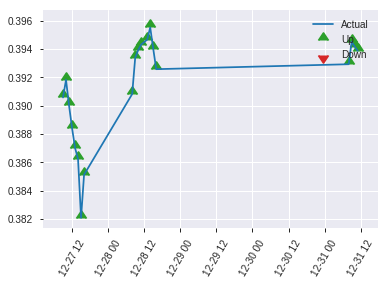


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25231567092569934
RMSE: 0.5023103332858079
LogLoss: 0.6982917861729243
Mean Per-Class Error: 0.43339993339993343
AUC: 0.5406260406260406
pr_auc: 0.45469229868320765
Gini: 0.08125208125208117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2631798804889544: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    91   0        (0.0/91.0)
Total  0    223  0.5919   (132.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26318      0.579618  222
max f2                       0.26318      0.775128  222
max f0point5                 0.501775     0.492487  126
max accuracy                 0.571852     0.61435   20
max precision                0.608804     1         0
max recall                   0.26318      1         222
max specificity              0.608804     1         0
max absolute_mcc             0.376549     0.139689  205
max min_per_class_accuracy   0.512011     0.516484  108
max mean_per_class_accuracy  0.501775     0.5666    126

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.598348           1.6337    1.6337             0.666667         0.604932  0.666667                    0.604932            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.590767           1.22527   1.47033            0.5              0.593873  0.6                         0.600509            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.584928           1.22527   1.40031            0.5              0.587728  0.571429                    0.596857            0.010989        0.043956                   22.5275   40.0314
    4        0.0403587                   0.581459           1.22527   1.36142            0.5              0.58315   0.555556                    0.593811            0.010989        0.0549451                  22.5275   36.1416
    5        0.0538117                   0.578001           1.6337    1.42949            0.666667         0.57939   0.583333                    0.590206            0.021978        0.0769231                  63.37     42.9487
    6        0.103139                    0.569257           1.33666   1.38509            0.545455         0.57435   0.565217                    0.582623            0.0659341       0.142857                   33.6663   38.5093
    7        0.152466                    0.563705           1.11389   1.29735            0.454545         0.56619   0.529412                    0.577306            0.0549451       0.197802                   11.3886   29.735
    8        0.201794                    0.55592            0.891109  1.19805            0.363636         0.559527  0.488889                    0.57296             0.043956        0.241758                   -10.8891  19.8046
    9        0.300448                    0.542729           0.556943  0.987535           0.227273         0.549931  0.402985                    0.565398            0.0549451       0.296703                   -44.3057  -1.24651
    10       0.399103                    0.529028           1.33666   1.07384            0.545455         0.536874  0.438202                    0.558347            0.131868        0.428571                   33.6663   7.38363
    11       0.502242                    0.511129           0.958911  1.05024            0.391304         0.517862  0.428571                    0.550033            0.0989011       0.527473                   -4.10893  5.02355
    12       0.600897                    0.495711           1.33666   1.09726            0.545455         0.503968  0.447761                    0.54247             0.131868        0.659341                   33.6663   9.72609
    13       0.699552                    0.47313            0.77972   1.05248            0.318182         0.484791  0.429487                    0.534336            0.0769231       0.736264                   -22.028   5.24796
    14       0.798206                    0.446191           0.891109  1.03253            0.363636         0.459277  0.421348                    0.525059            0.0879121       0.824176                   -10.8891  3.25349
    15       0.896861                    0.396093           0.445554  0.967967           0.181818         0.420723  0.395                       0.513582            0.043956        0.868132                   -55.4446  -3.2033
    16       1                           0.26318            1.27855   1                  0.521739         0.344959  0.408072                    0.496191            

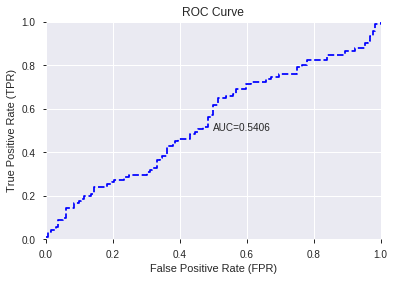

This function is available for GLM models only


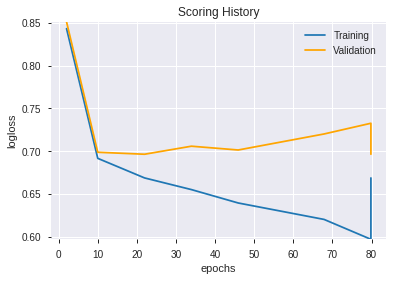

--2019-08-27 17:24:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_171714_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_171714_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DX_24',
 'aroondown_14',
 'STOCHRSI_fastk',
 'BOP',
 'MFI_30',
 'TRANGE',
 'CORREL_14',
 'BETA_14',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_24_0_2',
 'BBANDS_middleband_24_7_3',
 'STOCHRSI_fastd',
 'BETA_8',
 'STOCH_slowk',
 'PLUS_DM_14',
 'AROONOSC_30',
 'STOCH_slowd',
 'STOCHF_fastd',
 'MOM_30',
 'NATR_30',
 'BBANDS_lowerband_14_6_5',
 'BETA_12',
 'MACDFIX_24',
 'HT_PHASOR_quadrature',
 'MACDFIX_hist_12',
 'RSI_30',
 'ATR_30',
 'PLUS_DM_24',
 'MACDEXT_hist',
 'ULTOSC',
 'aroondown_20',
 'STOCHF_fastk',
 'CCI_12',
 'ROCR100_24',
 'MINUS_DM_12',
 'LINEARREG_ANGLE_14',
 'WILLR_24',
 'MINUS_DM_20',
 'CCI_8',
 'MOM_12',
 'LINEARREG_ANGLE_12',
 'MACDEXT',
 'WILLR_8',
 'RSI_20',
 'MACDFIX_14',
 'LINEARREG_SLOPE_14',
 'LINEARREG_SLOPE_8',
 'ROC_12',
 'LINEARREG_ANGLE_8',
 'AROONOSC_14',
 'CMO_20',
 'RSI_8',
 'ROCR_20',
 'ROCP_20',
 'CCI_30',
 'RSI_14',
 'MOM_14',
 'ROC_20',
 'CCI_24']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_172411_model_1  0.504995  0.695782                   0.5  0.501283  0.251284

variable  relative_importance  scaled_importance  percentage
0                      DX_24             0.080848           1.000000    0.083518
1                     TRANGE             0.071958           0.890041    0.074334
2         CDLCLOSINGMARUBOZU             0.060097           0.743334    0.062082
3                     MFI_30             0.034980           0.432658    0.036135
4                 PLUS_DM_14             0.034372           0.425138    0.035506
5               aroondown_14             0.033719           0.417064    0.034832
6                MINUS_DM_12             0.031306           0.387214    0.032339
7               STOCHF_fastk             0.026806           0.331556    0.027691
8                     RSI_30             0.024726           0.305836    0.025543
9             STOCHRSI_fastd             0.023753           0.293798    0.024537
10                    ATR_30             0.023507           0.290756    0.024283
11              MACDEXT_hist             0.023507           0.290754    0.024283
12               AROONOSC_30             0.022184           0.274387    0.022916
13           MACDFIX_hist_12             0.020903           0.258541    0.021593
14                   WILLR_8             0.020731           0.256421    0.021416
15                    MOM_30             0.019796           0.244848    0.020449
16                    BETA_8             0.019446           0.240521    0.020088
17        LINEARREG_ANGLE_12             0.019147           0.236828    0.019779
18                   NATR_30             0.019133           0.236650    0.019764
19                  WILLR_24             0.018287           0.226186    0.018891
20               MINUS_DM_20             0.018111           0.224018    0.018709
21                    CMO_20             0.017983           0.222423    0.018576
22                    RSI_20             0.017684           0.218730    0.018268
23                   BETA_12             0.017148           0.212102    0.017714
24                    ULTOSC             0.016858           0.208510    0.017414
25        LINEARREG_ANGLE_14             0.015832           0.195821    0.016355
26        LINEARREG_SLOPE_14             0.015756           0.194881    0.016276
27                PLUS_DM_24             0.014191           0.175531    0.014660
28      HT_PHASOR_quadrature             0.012739           0.157567    0.013160
29                MACDFIX_14             0.012244           0.151443    0.012648
30                    RSI_14             0.011690           0.144588    0.012076
31                MACDFIX_24             0.011475           0.141934    0.011854
32               STOCH_slowk             0.010761           0.133097    0.011116
33              STOCHF_fastd             0.010668           0.131950    0.011020
34                    MOM_14             0.010239           0.126639    0.010577
35               AROONOSC_14             0.010237           0.126622    0.010575
36                ROCR100_24             0.009606           0.118811    0.009923
37                       BOP             0.008901           0.110093    0.009195
38                    ROC_12             0.008649           0.106979    0.008935
39                   BETA_14             0.008516           0.105332    0.008797
40                   MACDEXT             0.007995           0.098886    0.008259
41                     CCI_8             0.007971           0.098596    0.008235
42              aroondown_20             0.007687           0.095077    0.007941
43   BBANDS_lowerband_24_0_2             0.007407           0.091622    0.007652
44   BBANDS_lowerband_14_6_5             0.006805           0.084171    0.007030
45                    MOM_12             0.005486           0.067856    0.005667
46  BBANDS_middleband_24_7_3             0.004460           0.055166    0.004607
47                    CCI_12             0.004268           0.052794    0.004409
48                    CCI_24             0.004167  

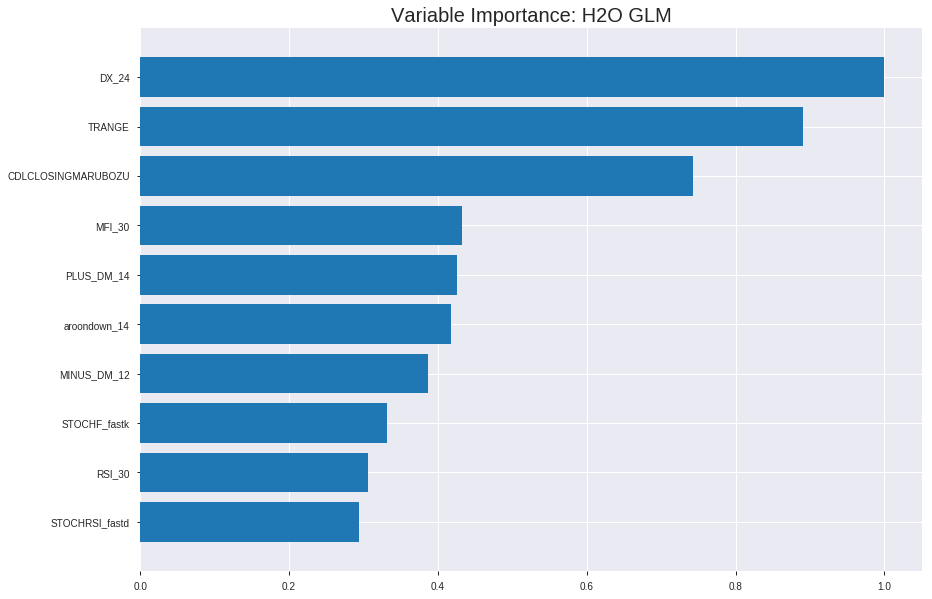

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_172411_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24470915705735072
RMSE: 0.49468086384794663
LogLoss: 0.6824619045694867
Null degrees of freedom: 1557
Residual degrees of freedom: 1498
Null deviance: 2159.805536138753
Residual deviance: 2126.5512946385206
AIC: 2246.5512946385206
AUC: 0.5922366415358629
pr_auc: 0.5804191968167889
Gini: 0.18447328307172572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37367162161362427: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   764   0.9858   (764.0/775.0)
1      1    782   0.0013   (1.0/783.0)
Total  12   1546  0.491    (765.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373672     0.671533  387
max f2                       0.373672     0.835827  387
max f0point5                 0.483288     0.583899  244
max accuracy                 0.483288     0.568678  244
max precision                0.634355     1         0
max recall                   0.349714     1         393
max specificity              0.634355     1         0
max absolute_mcc             0.527476     0.149152  126
max min_per_class_accuracy   0.505916     0.56129   182
max mean_per_class_accuracy  0.527476     0.568418  126

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.599308           1.6167    1.6167             0.8125           0.609566  0.8125                      0.609566            0.0166028       0.0166028                  61.6699    61.6699
    2        0.0205392                   0.587211           1.11925   1.36798            0.5625           0.592474  0.6875                      0.60102             0.0114943       0.0280971                  11.9253    36.7976
    3        0.0301669                   0.578951           1.06122   1.27007            0.533333         0.582207  0.638298                    0.595016            0.0102171       0.0383142                  6.12175    27.0074
    4        0.0404365                   0.574286           1.11925   1.23177            0.5625           0.576443  0.619048                    0.590299            0.0114943       0.0498084                  11.9253    23.177
    5        0.0500642                   0.571209           0.928565  1.17346            0.466667         0.572859  0.589744                    0.586945            0.00893997      0.0587484                  -7.14347   17.3462
    6        0.100128                    0.558066           1.24999   1.21173            0.628205         0.564225  0.608974                    0.575585            0.0625798       0.121328                   24.9992    21.1727
    7        0.150193                    0.547715           1.32652   1.24999            0.666667         0.552858  0.628205                    0.56801             0.0664112       0.187739                   32.6522    24.9992
    8        0.200257                    0.539459           1.14795   1.22448            0.576923         0.543539  0.615385                    0.561892            0.0574713       0.245211                   14.7952    22.4482
    9        0.300385                    0.527414           1.22448   1.22448            0.615385         0.532576  0.615385                    0.55212             0.122605        0.367816                   22.4482    22.4482
    10       0.399872                    0.516339           0.949961  1.15618            0.477419         0.521818  0.581059                    0.544581            0.0945083       0.462324                   -5.00391   15.6182
    11       0.5                         0.505799           0.994891  1.12388            0.5              0.511051  0.564827                    0.537866            0.0996169       0.561941                   -0.510856  12.3883
    12       0.600128                    0.495087           0.969381  1.0981             0.487179         0.500305  0.551872                    0.531599            0.0970626       0.659004                   -3.06186   9.81048
    13       0.699615                    0.483333           1.0655    1.09347            0.535484         0.489416  0.549541                    0.525601            0.106003        0.765006                   6.54966    9.34678
    14       0.799743                    0.468147           0.816321  1.05877            0.410256         0.476404  0.532103                    0.519441            0.0817369       0.846743                   -18.3679   5.87689
    15       0.899872                    0.443066           0.714281  1.02044            0.358974         0.456147  0.512839                    0.512399            0.0715198       0.918263                   -28.5719   2.04379
    16       1                           0.222264           0.816321  1                  0.410256         0.414213  0.502567                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24666717450261813
RMSE: 0.4966559921138757
LogLoss: 0.6865355121388498
Null degrees of freedom: 445
Residual degrees of freedom: 386
Null deviance: 618.4838984721613
Residual deviance: 612.389676827854
AIC: 732.389676827854
AUC: 0.5801039316790203
pr_auc: 0.524471222751821
Gini: 0.1602078633580406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43902447013971413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   207  0.8922   (207.0/232.0)
1      11   203  0.0514   (11.0/214.0)
Total  36   410  0.4888   (218.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439024     0.650641  365
max f2                       0.296649     0.821813  399
max f0point5                 0.489104     0.565523  236
max accuracy                 0.525182     0.573991  140
max precision                0.636527     1         0
max recall                   0.296649     1         399
max specificity              0.636527     1         0
max absolute_mcc             0.489104     0.154624  236
max min_per_class_accuracy   0.501734     0.556075  195
max mean_per_class_accuracy  0.489104     0.575854  236

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.59628            0.833645  0.833645           0.4              0.612097  0.4                         0.612097            0.00934579      0.00934579                 -16.6355  -16.6355
    2        0.0201794                   0.587511           1.04206   0.926272           0.5              0.594031  0.444444                    0.604068            0.00934579      0.0186916                  4.20561   -7.37279
    3        0.0313901                   0.582039           0.416822  0.744326           0.2              0.585426  0.357143                    0.59741             0.0046729       0.0233645                  -58.3178  -25.5674
    4        0.0403587                   0.57432            1.04206   0.810488           0.5              0.578693  0.388889                    0.593251            0.00934579      0.0327103                  4.20561   -18.9512
    5        0.0515695                   0.569259           1.25047   0.906136           0.6              0.571902  0.434783                    0.58861             0.0140187       0.046729                   25.0467   -9.38643
    6        0.100897                    0.55595            1.23152   1.06521            0.590909         0.561128  0.511111                    0.575174            0.0607477       0.107477                   23.1521   6.52129
    7        0.150224                    0.548847           1.32625   1.15093            0.636364         0.552231  0.552239                    0.56764             0.0654206       0.172897                   32.6253   15.0928
    8        0.201794                    0.541317           1.26859   1.181              0.608696         0.545455  0.566667                    0.561971            0.0654206       0.238318                   26.859    18.0997
    9        0.300448                    0.52914            1.18415   1.18203            0.568182         0.535119  0.567164                    0.553154            0.116822        0.35514                    18.4155   18.2034
    10       0.401345                    0.516738           1.06521   1.15267            0.511111         0.523362  0.553073                    0.545664            0.107477        0.462617                   6.52129   15.2665
    11       0.5                         0.501259           0.947324  1.11215            0.454545         0.509138  0.533632                    0.538457            0.0934579       0.556075                   -5.26763  11.215
    12       0.600897                    0.489054           1.20415   1.1276             0.577778         0.494946  0.541045                    0.531151            0.121495        0.67757                    20.4154   12.7598
    13       0.699552                    0.477434           0.805225  1.08214            0.386364         0.483361  0.519231                    0.524412            0.0794393       0.757009                   -19.4775  8.21352
    14       0.800448                    0.466565           0.833645  1.05081            0.4              0.472563  0.504202                    0.517876            0.0841121       0.841121                   -16.6355  5.08128
    15       0.899103                    0.444704           0.899958  1.03426            0.431818         0.457721  0.496259                    0.511276            0.088785        0.929907                   -10.0042  3.42601
    16       1                           0.296649           0.694704  1                  0.333333         0.417549  0.479821                    0.501819     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:24:11  0.000 sec   2            3.7       60            1.38155           1.38186
    2019-08-27 17:24:11  0.014 sec   4            2.3       60            1.37972           1.38022
    2019-08-27 17:24:11  0.028 sec   6            1.4       60            1.37751           1.37844
    2019-08-27 17:24:11  0.042 sec   8            0.9       60            1.37488           1.37668
    2019-08-27 17:24:12  0.056 sec   10           0.56      60            1.37186           1.37506
    2019-08-27 17:24:12  0.072 sec   12           0.35      60            1.36849           1.37377
    2019-08-27 17:24:12  0.086 sec   14           0.21      60            1.36492           1.37307
    2019-08-27 17:24:12  0.103 sec   16           0.13      60            1.36144           1.37311
    2019-08-27 17:24:12  0.118 sec   18           0.083     60            1.35827           1.37405
    2019-08-27 17:24:12  0.134 sec   20           0.051     60            1.35557           1.37594
    2019-08-27 17:24:12  0.147 sec   22           0.032     60            1.35334           1.37871
    2019-08-27 17:24:12  0.163 sec   24           0.02      60            1.35155           1.38216

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6098654708520179)

('F1', 0.5796178343949044)

('auc', 0.5049950049950049)

('logloss', 0.6957815723157225)

('mean_per_class_error', 0.45521145521145523)

('rmse', 0.5012828392914233)

('mse', 0.2512844849680708)

glm prediction progress: |████████████████████████████████████████████████| 100%


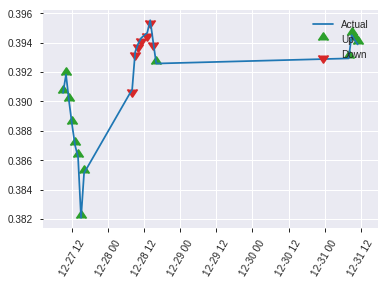


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2512844849680708
RMSE: 0.5012828392914233
LogLoss: 0.6957815723157225
Null degrees of freedom: 222
Residual degrees of freedom: 163
Null deviance: 309.5705785684792
Residual deviance: 310.31858125281224
AIC: 430.31858125281224
AUC: 0.5049950049950049
pr_auc: 0.42553649374878394
Gini: 0.009990009990009874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36740886811058304: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    91   0        (0.0/91.0)
Total  0    223  0.5919   (132.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367409     0.579618  222
max f2                       0.367409     0.775128  222
max f0point5                 0.502353     0.463158  95
max accuracy                 0.571986     0.609865  9
max precision                0.599411     1         0
max recall                   0.367409     1         222
max specificity              0.599411     1         0
max absolute_mcc             0.571986     0.128701  9
max min_per_class_accuracy   0.496856     0.507576  111
max mean_per_class_accuracy  0.502353     0.544789  95

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.584342           0.81685   0.81685            0.333333         0.59195   0.333333                    0.59195             0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.575718           2.45055   1.47033            1                0.576361  0.6                         0.585714            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.572627           2.45055   1.75039            1                0.574024  0.714286                    0.582374            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.571999           1.22527   1.6337             0.5              0.572241  0.666667                    0.580122            0.010989        0.0659341                  22.5275   63.37
    5        0.0538117                   0.565614           0.81685   1.42949            0.333333         0.569286  0.583333                    0.577413            0.010989        0.0769231                  -18.315   42.9487
    6        0.103139                    0.549374           0.668332  1.06546            0.272727         0.55566   0.434783                    0.567009            0.032967        0.10989                    -33.1668  6.54563
    7        0.152466                    0.538202           0.891109  1.00905            0.363636         0.54254   0.411765                    0.559093            0.043956        0.153846                   -10.8891  0.904977
    8        0.201794                    0.532174           1.11389   1.03468            0.454545         0.535171  0.422222                    0.553245            0.0549451       0.208791                   11.3886   3.46764
    9        0.300448                    0.515375           1.11389   1.06069            0.454545         0.52325   0.432836                    0.543396            0.10989         0.318681                   11.3886   6.06856
    10       0.399103                    0.507001           1.33666   1.1289             0.545455         0.511838  0.460674                    0.535595            0.131868        0.450549                   33.6663   12.8905
    11       0.502242                    0.496856           0.639274  1.02836            0.26087          0.500831  0.419643                    0.528456            0.0659341       0.516484                   -36.0726  2.83556
    12       0.600897                    0.485422           0.77972   0.987535           0.318182         0.491044  0.402985                    0.522314            0.0769231       0.593407                   -22.028   -1.24651
    13       0.699552                    0.477782           1.0025    0.989645           0.409091         0.481668  0.403846                    0.516582            0.0989011       0.692308                   0.24975   -1.0355
    14       0.798206                    0.463317           0.891109  0.977466           0.363636         0.469765  0.398876                    0.510795            0.0879121       0.78022                    -10.8891  -2.25336
    15       0.896861                    0.442939           1.0025    0.98022            0.409091         0.453975  0.4                         0.504545            0.0989011       0.879121                   0.24975   -1.97802
    16       1                           0.367409           1.172     1                  0.478261         0.413306  0.408072                    0.495135        

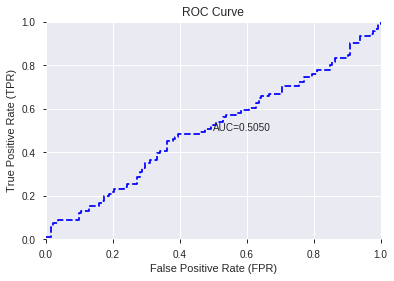

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


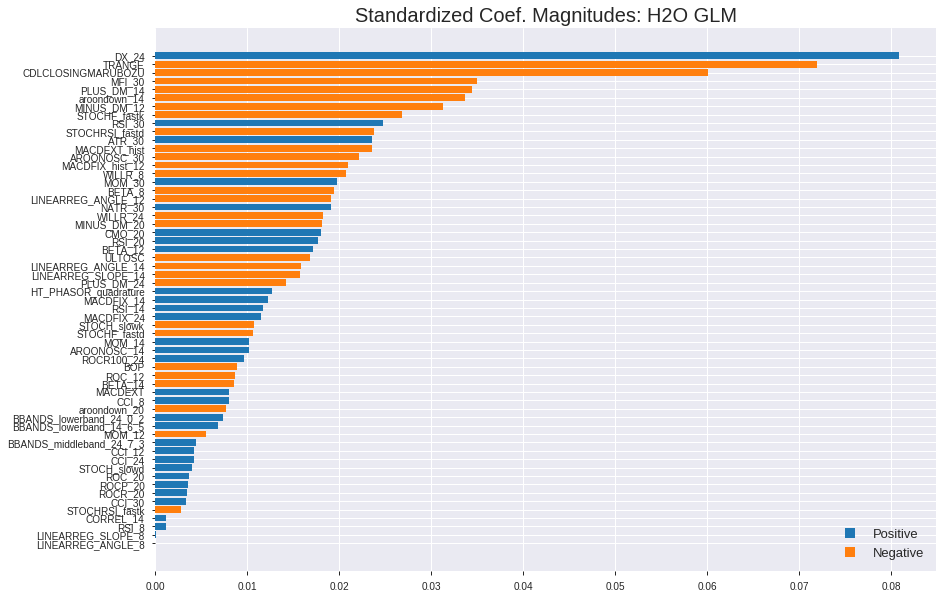

'log_likelihood'
--2019-08-27 17:24:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_172411_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_172411_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['DX_24',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'MFI_30',
 'PLUS_DM_14',
 'aroondown_14',
 'MINUS_DM_12',
 'STOCHF_fastk',
 'RSI_30',
 'STOCHRSI_fastd',
 'ATR_30',
 'MACDEXT_hist',
 'AROONOSC_30',
 'MACDFIX_hist_12',
 'WILLR_8',
 'MOM_30',
 'BETA_8',
 'LINEARREG_ANGLE_12',
 'NATR_30',
 'WILLR_24',
 'MINUS_DM_20',
 'CMO_20',
 'RSI_20',
 'BETA_12',
 'ULTOSC',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'PLUS_DM_24',
 'HT_PHASOR_quadrature',
 'MACDFIX_14',
 'RSI_14',
 'MACDFIX_24',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MOM_14',
 'AROONOSC_14',
 'ROCR100_24',
 'BOP',
 'ROC_12',
 'BETA_14',
 'MACDEXT',
 'CCI_8',
 'aroondown_20',
 'BBANDS_lowerband_24_0_2',
 'BBANDS_lowerband_14_6_5',
 'MOM_12',
 'BBANDS_middleband_24_7_3',
 'CCI_12',
 'CCI_24',
 'STOCH_slowd',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'CCI_30',
 'STOCHRSI_fastk',
 'CORREL_14',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8']

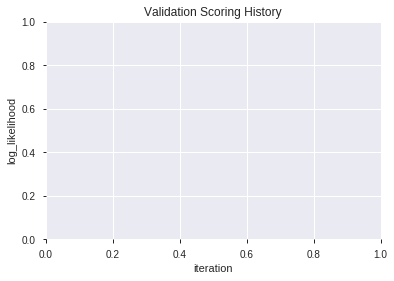

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_172425_model_5  0.504163  0.796643              0.490343  0.540381  0.292012
1  XGBoost_grid_1_AutoML_20190827_172425_model_6  0.481185  0.726221              0.500000  0.515698  0.265944
2  XGBoost_grid_1_AutoML_20190827_172425_model_4  0.479021  0.715575              0.500000  0.510757  0.260872
3               XGBoost_2_AutoML_20190827_172425  0.475025  0.731925              0.500000  0.518055  0.268381
4               XGBoost_3_AutoML_20190827_172425  0.466200  0.725245              0.500000  0.515209  0.265440
5  XGBoost_grid_1_AutoML_20190827_172425_model_2  0.466117  0.729059              0.500000  0.517134  0.267427
6               XGBoost_1_AutoML_20190827_172425  0.465534  0.727105              0.480311  0.515902  0.266154
7  XGBoost_grid_1_AutoML_20190827_172425_model_7  0.464535  0.734774              0.496212  0.519183  0.269551
8  XGBoost_grid_1_AutoML_20190827_172425_model_1  0.460664  0.741671              0.500000  0.522791  0.273311
9  XGBoost_grid_1_AutoML_20190827_172425_model_3  0.445887  0.729209              0.496212  0.516955  0.267242

variable  relative_importance  scaled_importance  percentage
0                      CCI_8           853.624207           1.000000    0.039353
1                        BOP           768.974731           0.900835    0.035450
2    BBANDS_lowerband_14_6_5           662.618042           0.776241    0.030547
3                     TRANGE           655.131592           0.767471    0.030202
4                STOCH_slowd           605.673157           0.709531    0.027922
5    BBANDS_lowerband_24_0_2           602.551514           0.705874    0.027778
6       HT_PHASOR_quadrature           594.745972           0.696730    0.027418
7                      DX_24           548.792297           0.642897    0.025300
8                    WILLR_8           528.540588           0.619172    0.024366
9                MINUS_DM_12           522.154907           0.611692    0.024072
10                    CCI_12           485.651428           0.568929    0.022389
11                     RSI_8           470.751160           0.551474    0.021702
12                PLUS_DM_14           470.481110           0.551157    0.021690
13                    MOM_12           452.498474           0.530091    0.020861
14                   NATR_30           451.058624           0.528404    0.020794
15                   BETA_14           450.328033           0.527548    0.020761
16                    BETA_8           445.041107           0.521355    0.020517
17               STOCH_slowk           433.698212           0.508067    0.019994
18                    MOM_14           431.880829           0.505938    0.019910
19              STOCHF_fastk           429.924805           0.503646    0.019820
20            STOCHRSI_fastd           415.147430           0.486335    0.019139
21                    ULTOSC           406.654022           0.476385    0.018747
22           MACDFIX_hist_12           403.775482           0.473013    0.018614
23              MACDEXT_hist           397.474243           0.465631    0.018324
24                    MFI_30           397.295959           0.465423    0.018316
25                ROCR100_24           396.626892           0.464639    0.018285
26                    CMO_20           384.013397           0.449862    0.017703
27                PLUS_DM_24           373.730316           0.437816    0.017229
28                   BETA_12           368.712494           0.431938    0.016998
29  BBANDS_middleband_24_7_3           367.280884           0.430261    0.016932
30                    ATR_30           357.572601           0.418888    0.016484
31                    ROC_20           338.808411           0.396906    0.015619
32                    CCI_24           331.653961           0.388525    0.015290
33               MINUS_DM_20           327.206177           0.383314    0.015084
34                    MOM_30           322.393524           0.377676    0.014863
35                   MACDEXT           322.245758           0.377503    0.014856
36        LINEARREG_ANGLE_12           309.937775           0.363085    0.014288
37                MACDFIX_14           304.205292           0.356369    0.014024
38                    RSI_30           302.164246           0.353978    0.013930
39                    CCI_30           300.809814           0.352391    0.013868
40               AROONOSC_30           296.859680           0.347764    0.013685
41                    RSI_14           292.927063           0.343157    0.013504
42                    ROC_12           286.146881           0.335214    0.013192
43                  WILLR_24           258.236206           0.302517    0.011905
44              aroondown_14           257.900970           0.302125    0.011889
45                 CORREL_14           241.561234           0.282983    0.011136
46         LINEARREG_ANGLE_8           238.061707           0.278884    0.010975
47        LINEARREG_ANGLE_14           218.148895           0.255556    0.010057
48               AROONOSC_14           214.255646  

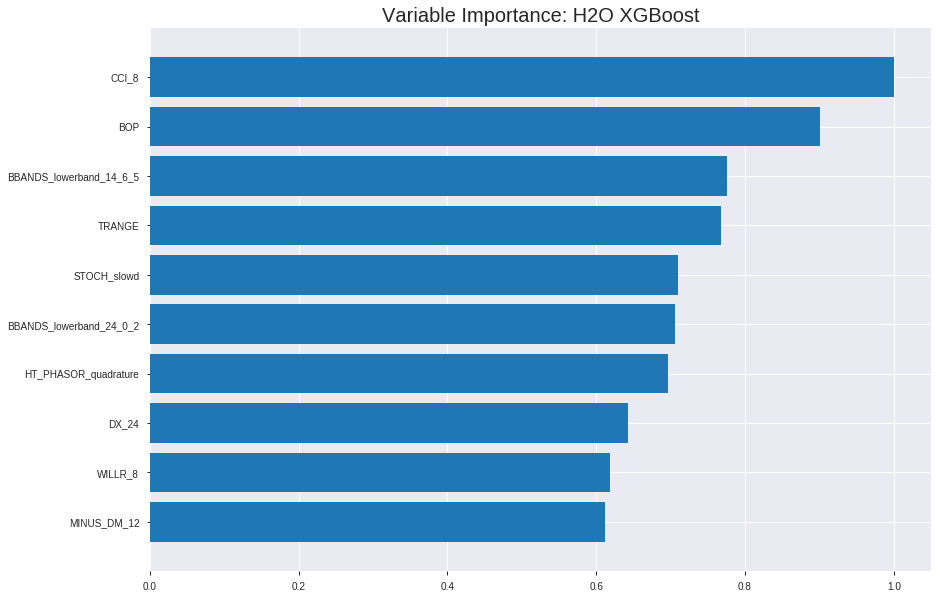

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_172425_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04141841023159988
RMSE: 0.2035151351413449
LogLoss: 0.21868116304694193
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987228607918263
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5244924426078796: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      775  0    0        (0.0/775.0)
1      0    783  0        (0.0/783.0)
Total  775  783  0        (0.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.524492     1        197
max f2                       0.524492     1        197
max f0point5                 0.524492     1        197
max accuracy                 0.524492     1        197
max precision                0.942921     1        0
max recall                   0.524492     1        197
max specificity              0.942921     1        0
max absolute_mcc             0.524492     1        197
max min_per_class_accuracy   0.524492     1        197
max mean_per_class_accuracy  0.524492     1        197

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102696                   0.903416           1.98978    1.98978            1                0.915822  1                           0.915822            0.0204342       0.0204342                  98.9783  98.9783
    2        0.0205392                   0.894793           1.98978    1.98978            1                0.898555  1                           0.907189            0.0204342       0.0408685                  98.9783  98.9783
    3        0.0301669                   0.888922           1.98978    1.98978            1                0.892265  1                           0.902426            0.0191571       0.0600255                  98.9783  98.9783
    4        0.0404365                   0.883852           1.98978    1.98978            1                0.886075  1                           0.898273            0.0204342       0.0804598                  98.9783  98.9783
    5        0.0500642                   0.879079           1.98978    1.98978            1                0.881207  1                           0.894991            0.0191571       0.0996169                  98.9783  98.9783
    6        0.100128                    0.860089           1.98978    1.98978            1                0.867848  1                           0.88142             0.0996169       0.199234                   98.9783  98.9783
    7        0.150193                    0.844549           1.98978    1.98978            1                0.852001  1                           0.871614            0.0996169       0.298851                   98.9783  98.9783
    8        0.200257                    0.830711           1.98978    1.98978            1                0.837401  1                           0.86306             0.0996169       0.398467                   98.9783  98.9783
    9        0.300385                    0.798715           1.98978    1.98978            1                0.814197  1                           0.846772            0.199234        0.597701                   98.9783  98.9783
    10       0.399872                    0.759581           1.98978    1.98978            1                0.780262  1                           0.830225            0.197957        0.795658                   98.9783  98.9783
    11       0.5                         0.607426           1.98978    1.98978            1                0.718414  1                           0.807834            0.199234        0.994891                   98.9783  98.9783
    12       0.600128                    0.247591           0.0510201  1.66631            0.025641         0.299034  0.837433                    0.722943            0.00510856      1                          -94.898  66.631
    13       0.699615                    0.200484           0          1.42936            0                0.221663  0.718349                    0.65166             0               1                          -100     42.9358
    14       0.799743                    0.17162            0          1.2504             0                0.185826  0.628411                    0.593338            0               1                          -100     25.0401
    15       0.899872                    0.141493           0          1.11127            0                0.157284  0.558488                    0.544818            0               1                          -100     11.127
    16       1                           0.0701886          0          1                  0                0.118616  0.502567                    0.502143          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26505252213402575
RMSE: 0.5148325185281382
LogLoss: 0.7287449985996334
Mean Per-Class Error: 0.4575008056719304
AUC: 0.538863599742185
pr_auc: 0.5169452044661214
Gini: 0.07772719948437001
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2587681710720062: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   221  0.9526   (221.0/232.0)
1      3    211  0.014    (3.0/214.0)
Total  14   432  0.5022   (224.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258768     0.653251  385
max f2                       0.162947     0.823711  396
max f0point5                 0.258768     0.543254  385
max accuracy                 0.676418     0.553812  79
max precision                0.888751     1         0
max recall                   0.162947     1         396
max specificity              0.888751     1         0
max absolute_mcc             0.676418     0.1053    79
max min_per_class_accuracy   0.498011     0.537383  199
max mean_per_class_accuracy  0.611825     0.542499  115

Gains/Lift Table: Avg response rate: 47.98 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.850935           1.25047   1.25047            0.6              0.869729  0.6                         0.869729            0.0140187       0.0140187                  25.0467   25.0467
    2        0.0201794                   0.832144           1.56308   1.38941            0.75             0.844283  0.666667                    0.85842             0.0140187       0.0280374                  56.3084   38.9408
    3        0.0313901                   0.823499           0.833645  1.19092            0.4              0.82816   0.571429                    0.847613            0.00934579      0.0373832                  -16.6355  19.0921
    4        0.0403587                   0.811003           1.04206   1.15784            0.5              0.817789  0.555556                    0.840985            0.00934579      0.046729                   4.20561   15.784
    5        0.0515695                   0.799097           1.25047   1.17798            0.6              0.804097  0.565217                    0.832966            0.0140187       0.0607477                  25.0467   17.7976
    6        0.100897                    0.738801           0.947324  1.06521            0.454545         0.766667  0.511111                    0.800553            0.046729        0.107477                   -5.26763  6.52129
    7        0.150224                    0.697326           1.32625   1.15093            0.636364         0.720632  0.552239                    0.77431             0.0654206       0.172897                   32.6253   15.0928
    8        0.201794                    0.672469           1.3592    1.20415            0.652174         0.682934  0.577778                    0.750959            0.0700935       0.242991                   35.9204   20.4154
    9        0.300448                    0.599205           0.947324  1.11982            0.454545         0.631249  0.537313                    0.711651            0.0934579       0.336449                   -5.26763  11.9821
    10       0.401345                    0.555733           0.833645  1.04788            0.4              0.575546  0.502793                    0.677435            0.0841121       0.420561                   -16.6355  4.78776
    11       0.5                         0.496276           1.18415   1.07477            0.568182         0.525887  0.515695                    0.647533            0.116822        0.537383                   18.4155   7.47664
    12       0.600897                    0.463392           0.694704  1.01095            0.333333         0.478274  0.485075                    0.619113            0.0700935       0.607477                   -30.5296  1.09499
    13       0.699552                    0.405825           1.08942   1.02202            0.522727         0.434395  0.490385                    0.593063            0.107477        0.714953                   8.94223   2.20165
    14       0.800448                    0.355546           1.06521   1.02746            0.511111         0.381972  0.492997                    0.566455            0.107477        0.82243                    6.52129   2.74615
    15       0.899103                    0.300716           0.899958  1.01347            0.431818         0.329318  0.486284                    0.540435            0.088785        0.911215                   -10.0042  1.3471
    16       1                           0.137167           0.879958  1                  0.422222         0.257026  0.479821                    0.51184            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:24:33  3.234 sec   0                  0.5              0.693147            0.5             0                  1                0.497433                         0.5                0.693147              0.5               0                    1                  0.520179
    2019-08-27 17:24:33  3.577 sec   5                  0.445798         0.589779            0.97425         0.97267            1.98978          0.07638                          0.50034            0.693855              0.527604          0.496113             0.833645           0.517937
    2019-08-27 17:24:33  3.873 sec   10                 0.399572         0.508636            0.996771        0.995467           1.98978          0.0243902                        0.500087           0.693486              0.549347          0.513556             1.66729            0.515695
    2019-08-27 17:24:34  4.157 sec   15                 0.363389         0.448875            0.99923         0.997941           1.98978          0.00770218                       0.503278           0.700286              0.53688           0.498036             0.833645           0.506726
    2019-08-27 17:24:34  4.424 sec   20                 0.333253         0.401316            0.999828        0.998551           1.98978          0.00577664                       0.506553           0.707661              0.530182          0.493202             0.416822           0.502242
    2019-08-27 17:24:34  4.742 sec   25                 0.303285         0.355939            0.999873        0.998597           1.98978          0.00385109                       0.506515           0.708414              0.543536          0.500627             0.416822           0.497758
    2019-08-27 17:24:34  5.078 sec   30                 0.277392         0.318358            0.999969        0.998692           1.98978          0.00192555                       0.507806           0.711658              0.543677          0.50135              0.833645           0.491031
    2019-08-27 17:24:35  5.387 sec   35                 0.25631          0.288685            0.999991        0.998714           1.98978          0.000641849                      0.511258           0.719237              0.53555           0.505642             1.25047            0.502242
    2019-08-27 17:24:35  5.693 sec   40                 0.23746          0.262902            0.999998        0.998721           1.98978          0.000641849                      0.513306           0.724085              0.533022          0.506445             1.25047            0.502242
    2019-08-27 17:24:35  6.044 sec   45                 0.218971         0.238565            1               0.998723           1.98978          0                                0.514223           0.726451              0.535278          0.517373             1.66729            0.5
    2019-08-27 17:24:36  6.401 sec   50                 0.203515         0.218681            1               0.998723           1.98978          0                                0.514833           0.728745              0.538864          0.516945             1.25047            0.502242

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CCI_8                    853.6242065429688      1.0                  0.03935281827771103
BOP                      768.9747314453125      0.9008351983825856   0.03545040386011566
BBANDS_lowerband_14_6_5  662.6180419921875      0.776240923011868    0.030547267983008723
TRANGE                   655.131591796875       0.7674707286594475   0.030202136118397713
STOCH_slowd              605.6731567382812      0.7095313746913918   0.027922059250564842
---                      ---                    ---                  ---
LINEARREG_SLOPE_14       133.6473846435547      0.15656466114615425  0.006161260658796013
RSI_20                   129.8997802734375      0.15217443375874878  0.005988492838221617
ROCR_20                  101.75043487548828     0.11919816014538769  0.0046907835352389396
LINEARREG_SLOPE_8        94.20342254638672      0.11035701872595012  0.004342859703592269
CDLCLOSINGMARUBOZU       43.57462692260742      0.05104661581596563  0.0020088281958978256


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.5825242718446603)

('auc', 0.5041625041625042)

('logloss', 0.796642833575606)

('mean_per_class_error', 0.4381451881451881)

('rmse', 0.5403811236248798)

('mse', 0.2920117587700876)

xgboost prediction progress: |████████████████████████████████████████████| 100%


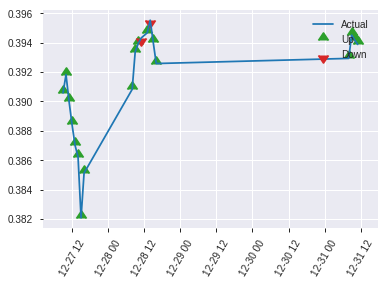


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2920117587700876
RMSE: 0.5403811236248798
LogLoss: 0.796642833575606
Mean Per-Class Error: 0.4381451881451881
AUC: 0.5041625041625042
pr_auc: 0.39605603369196485
Gini: 0.008325008325008376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23437321186065674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    128  0.9697   (128.0/132.0)
1      1    90   0.011    (1.0/91.0)
Total  5    218  0.5785   (129.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234373     0.582524  217
max f2                       0.212767     0.776451  221
max f0point5                 0.513796     0.486486  115
max accuracy                 0.896911     0.587444  0
max precision                0.513796     0.465517  115
max recall                   0.212767     1         221
max specificity              0.896911     0.992424  0
max absolute_mcc             0.513796     0.1217    115
max min_per_class_accuracy   0.536287     0.545455  109
max mean_per_class_accuracy  0.513796     0.561855  115

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 54.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.87455            0         0                  0                0.88503   0                           0.88503             0               0                          -100      -100
    2        0.0224215                   0.86103            1.22527   0.49011            0.5              0.865875  0.2                         0.877368            0.010989        0.010989                   22.5275   -50.989
    3        0.0313901                   0.841607           2.45055   1.05024            1                0.852753  0.428571                    0.870335            0.021978        0.032967                   145.055   5.02355
    4        0.0403587                   0.836219           0         0.81685            0                0.838291  0.333333                    0.863214            0               0.032967                   -100      -18.315
    5        0.0538117                   0.828601           0.81685   0.81685            0.333333         0.831856  0.333333                    0.855375            0.010989        0.043956                   -18.315   -18.315
    6        0.103139                    0.7889             0.891109  0.852365           0.363636         0.810475  0.347826                    0.833901            0.043956        0.0879121                  -10.8891  -14.7635
    7        0.152466                    0.7618             1.11389   0.936975           0.454545         0.776742  0.382353                    0.815408            0.0549451       0.142857                   11.3886   -6.30252
    8        0.201794                    0.74349            1.11389   0.98022            0.454545         0.751589  0.4                         0.799808            0.0549451       0.197802                   11.3886   -1.97802
    9        0.300448                    0.668837           0.556943  0.841233           0.227273         0.702046  0.343284                    0.767707            0.0549451       0.252747                   -44.3057  -15.8767
    10       0.399103                    0.589866           1.33666   0.963699           0.545455         0.633847  0.393258                    0.734618            0.131868        0.384615                   33.6663   -3.63008
    11       0.502242                    0.5273             1.70473   1.11588            0.695652         0.557798  0.455357                    0.698307            0.175824        0.56044                    70.473    11.5875
    12       0.600897                    0.46954            0.77972   1.06069            0.318182         0.488906  0.432836                    0.663928            0.0769231       0.637363                   -22.028   6.06856
    13       0.699552                    0.435136           0.668332  1.00535            0.272727         0.451892  0.410256                    0.634025            0.0659341       0.703297                   -33.1668  0.535362
    14       0.798206                    0.380591           1.11389   1.01877            0.454545         0.411089  0.41573                     0.606471            0.10989         0.813187                   11.3886   1.87677
    15       0.896861                    0.322841           0.77972   0.992473           0.318182         0.355478  0.405                       0.578862            0.0769231       0.89011                    -22.028   -0.752747
    16       1                           0.202196           1.06546   1                  0.434783         0.264992  0.408072                    0.54649     

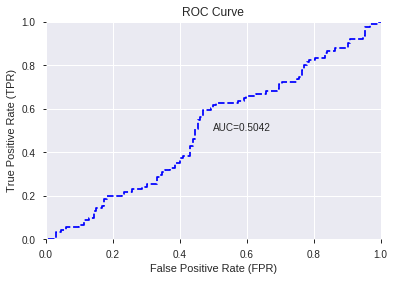

This function is available for GLM models only


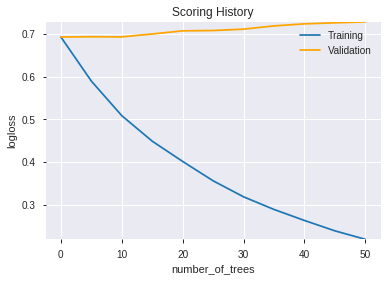

--2019-08-27 17:24:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_172425_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_172425_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9fff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CCI_8',
 'BOP',
 'BBANDS_lowerband_14_6_5',
 'TRANGE',
 'STOCH_slowd',
 'BBANDS_lowerband_24_0_2',
 'HT_PHASOR_quadrature',
 'DX_24',
 'WILLR_8',
 'MINUS_DM_12',
 'CCI_12',
 'RSI_8',
 'PLUS_DM_14',
 'MOM_12',
 'NATR_30',
 'BETA_14',
 'BETA_8',
 'STOCH_slowk',
 'MOM_14',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'MACDFIX_hist_12',
 'MACDEXT_hist',
 'MFI_30',
 'ROCR100_24',
 'CMO_20',
 'PLUS_DM_24',
 'BETA_12',
 'BBANDS_middleband_24_7_3',
 'ATR_30',
 'ROC_20',
 'CCI_24',
 'MINUS_DM_20',
 'MOM_30',
 'MACDEXT',
 'LINEARREG_ANGLE_12',
 'MACDFIX_14',
 'RSI_30',
 'CCI_30',
 'AROONOSC_30',
 'RSI_14',
 'ROC_12',
 'WILLR_24',
 'aroondown_14',
 'CORREL_14',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_14',
 'AROONOSC_14',
 'STOCHF_fastd',
 'aroondown_20',
 'STOCHRSI_fastk',
 'ROCP_20',
 'MACDFIX_24',
 'LINEARREG_SLOPE_14',
 'RSI_20',
 'ROCR_20',
 'LINEARREG_SLOPE_8',
 'CDLCLOSINGMARUBOZU']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.614
GLM             0.623
XGBoost         0.605
dtype: float64

DeepLearning    GLM  XGBoost
All          0.605  0.601    0.596
DLF          0.610  0.623    0.605
Fwe          0.601  0.601    0.596
RFE          0.614  0.610    0.587
XGBF         0.610  0.623    0.605





F1


DeepLearning    0.607
GLM             0.581
XGBoost         0.585
dtype: float64

DeepLearning    GLM  XGBoost
All          0.607  0.581    0.585
DLF          0.581  0.581    0.585
Fwe          0.581  0.581    0.585
RFE          0.580  0.580    0.583
XGBF         0.588  0.581    0.585





auc


DeepLearning    0.560
GLM             0.544
XGBoost         0.556
dtype: float64

DeepLearning    GLM  XGBoost
All          0.541  0.544    0.507
DLF          0.560  0.535    0.556
Fwe          0.528  0.544    0.507
RFE          0.541  0.505    0.504
XGBF         0.552  0.535    0.556





logloss


DeepLearning    2.716
GLM             0.696
XGBoost         0.797
dtype: float64

DeepLearning    GLM  XGBoost
All          2.716  0.695    0.702
DLF          0.673  0.693    0.758
Fwe          0.724  0.695    0.702
RFE          0.698  0.696    0.797
XGBF         0.941  0.693    0.758





mean_per_class_error


DeepLearning    0.447
GLM             0.455
XGBoost         0.453
dtype: float64

DeepLearning    GLM  XGBoost
All          0.430  0.433    0.453
DLF          0.434  0.441    0.419
Fwe          0.447  0.433    0.453
RFE          0.433  0.455    0.438
XGBF         0.432  0.441    0.419





rmse


DeepLearning    0.753
GLM             0.501
XGBoost         0.540
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.501    0.504
DLF          0.490  0.500    0.528
Fwe          0.515  0.501    0.504
RFE          0.502  0.501    0.540
XGBF         0.583  0.500    0.528





mse


DeepLearning    0.568
GLM             0.251
XGBoost         0.292
dtype: float64

DeepLearning    GLM  XGBoost
All          0.568  0.251    0.254
DLF          0.240  0.250    0.278
Fwe          0.265  0.251    0.254
RFE          0.252  0.251    0.292
XGBF         0.340  0.250    0.278

{'F1':       DeepLearning    GLM  XGBoost
 All          0.607    NaN      NaN
 DLF          0.581    NaN      NaN
 DLF            NaN  0.581      NaN
 DLF            NaN    NaN    0.585
 All            NaN  0.581      NaN
 All            NaN    NaN    0.585
 XGBF         0.588    NaN      NaN
 XGBF           NaN  0.581      NaN
 XGBF           NaN    NaN    0.585
 Fwe          0.581    NaN      NaN
 Fwe            NaN  0.581      NaN
 Fwe            NaN    NaN    0.585
 RFE          0.580    NaN      NaN
 RFE            NaN  0.580      NaN
 RFE            NaN    NaN    0.583,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.605    NaN      NaN
 DLF          0.610    NaN      NaN
 DLF            NaN  0.623      NaN
 DLF            NaN    NaN    0.605
 All            NaN  0.601      NaN
 All            NaN    NaN    0.596
 XGBF         0.610    NaN      NaN
 XGBF           NaN  0.623      NaN
 XGBF           NaN    NaN    0.605
 Fwe          0.601    NaN      NaN
 Fwe     